# Card Fraud Detection

# Part 1 - Objective

The objective of this project is to build a model that can reliably detect fraudulent transactions in a imbalanced dataset. 

We will preform data cleaning, data preprocessing, exploratory data analysis, model optimization, and dimensionality reduction to create a machinge learning model that can accurate differentiate fraudulent and nonfraudulent data.

# Part 2 - Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
 
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import mode
import sklearn
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings("ignore")

# Part 3 - Data Properties

In [2]:
# Path to data
file_path = "transactions.txt"

def import_data(path):
    transactions_line = []
    transactions = pd.DataFrame()
    
    for line in pd.read_json(file_path, lines=True, chunksize=100000):
        transactions_line.append(line)

    transactions = pd.concat(transactions_line)
    
    return transactions

transactions_df = import_data(file_path)

In [3]:
transactions = transactions_df.copy()

In [4]:
transactions.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

In [5]:
# Initial dimensions of data frame
initial_shape = transactions.shape
print(initial_shape)

(786363, 29)


In [6]:
# Take a quick peak at the data
transactions.head(5)

accountNumber  customerId  creditLimit  availableMoney  \
0      737265056   737265056         5000          5000.0   
1      737265056   737265056         5000          5000.0   
2      737265056   737265056         5000          5000.0   
3      737265056   737265056         5000          5000.0   
4      830329091   830329091         5000          5000.0   

   transactionDateTime  transactionAmount         merchantName acqCountry  \
0  2016-08-13T14:27:32              98.55                 Uber         US   
1  2016-10-11T05:05:54              74.51          AMC #191138         US   
2  2016-11-08T09:18:39               7.47           Play Store         US   
3  2016-12-10T02:14:50               7.47           Play Store         US   
4  2016-03-24T21:04:46              71.18  Tim Hortons #947751         US   

  merchantCountryCode posEntryMode posConditionCode merchantCategoryCode  \
0                  US           02               01            rideshare   
1                  US           09               01        entertainment   
2                  US           09               01           mobileapps   
3                  US           09               01           mobileapps   
4                  US           02               01             fastfood   

  currentExpDate accountOpenDate dateOfLastAddressChange  cardCVV  enteredCVV  \
0        06/2023      2015-03-14              2015-03-14      414         414   
1        02/2024      2015-03-14              2015-03-14      486         486   
2        08/2025      2015-03-14              2015-03-14      486         486   
3        08/2025      2015-03-14              2015-03-14      486         486   
4        10/2029      2015-08-06              2015-08-06      885         885   

   cardLast4Digits transactionType echoBuffer  currentBalance merchantCity  \
0             1803        PURCHASE                        0.0                
1              767        PURCHASE                        0.0                
2              767        PURCHASE                        0.0                
3              767        PURCHASE                        0.0                
4             3143        PURCHASE                        0.0                

  merchantState merchantZip  cardPresent posOnPremises recurringAuthInd  \
0                                  False                                  
1                                   True                                  
2                                  False                                  
3                                  False                                  
4                                   True                                  

   expirationDateKeyInMatch  isFraud  
0                     False    False  
1                     False    False  
2                     False    False  
3                     False    False  
4                     False    False

In [7]:
# Information about the columns and data dtyles
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

This is interesting that we do not have any null values, I will investigate further to see if that is truly the case

In [8]:
# Taking at the statistics look at the numerical columns
transactions.describe()

accountNumber    customerId    creditLimit  availableMoney  \
count   7.863630e+05  7.863630e+05  786363.000000   786363.000000   
mean    5.372326e+08  5.372326e+08   10759.464459     6250.725369   
std     2.554211e+08  2.554211e+08   11636.174890     8880.783989   
min     1.000881e+08  1.000881e+08     250.000000    -1005.630000   
25%     3.301333e+08  3.301333e+08    5000.000000     1077.420000   
50%     5.074561e+08  5.074561e+08    7500.000000     3184.860000   
75%     7.676200e+08  7.676200e+08   15000.000000     7500.000000   
max     9.993896e+08  9.993896e+08   50000.000000    50000.000000   

       transactionAmount        cardCVV     enteredCVV  cardLast4Digits  \
count      786363.000000  786363.000000  786363.000000    786363.000000   
mean          136.985791     544.467338     544.183857      4757.417799   
std           147.725569     261.524220     261.551254      2996.583810   
min             0.000000     100.000000       0.000000         0.000000   
25%            33.650000     310.000000     310.000000      2178.000000   
50%            87.900000     535.000000     535.000000      4733.000000   
75%           191.480000     785.000000     785.000000      7338.000000   
max          2011.540000     998.000000     998.000000      9998.000000   

       currentBalance  
count   786363.000000  
mean      4508.739089  
std       6457.442068  
min          0.000000  
25%        689.910000  
50%       2451.760000  
75%       5291.095000  
max      47498.810000

Here are the findings from the intial data property analysis:

<br>Total Observations: 786,363
<br>Columns: 29 Columns -> 28 Features and 1 Label
<br>DataTypes: Int, Object, Bool, and Float

<br>
<br>TransactionAmount: Ranginge from 0.00 to 2011.54    mean (126.99) > median (87.9) which implies right skewed data
<br>CreditLimit: Ranging from 250 to 50000              mean (10759) > median (7500) which implies right skewed data
<br>availableMoney: Ranging from -1005 to 50000         mean (6250.72) > median (3184.86) which implies right skewed data
<br>currentBalance: Ranging from 0 to 47498.81         mean (6457.44) > median (2451.76) which implies right skewed data

<br>
AccountNumber, customerId, cardCVV, enteredCVVm and cardKast4Digits should not be int columns as they have the summary statistics of these columns provide no value

After looking at the data types and the dataframe, I decided to adjust the datatypes of a few columns 

In [9]:
# Converting date columns from objects > datetime
transactions['transactionDateTime'] = pd.to_datetime(transactions['transactionDateTime'])
transactions['dateOfLastAddressChange'] = pd.to_datetime(transactions['dateOfLastAddressChange'])
transactions['currentExpDate'] = pd.to_datetime(transactions['currentExpDate'])
transactions['accountOpenDate'] = pd.to_datetime(transactions['accountOpenDate'])

# Converting a few numerical columns to objects. These columns are better represented as categorical data
transactions['accountNumber'] = transactions['accountNumber'].astype('string')
transactions['customerId'] = transactions['customerId'].astype('string')
transactions['cardCVV'] = transactions['cardCVV'].astype('string')
transactions['enteredCVV'] = transactions['enteredCVV'].astype('string')
transactions['cardLast4Digits'] = transactions['cardLast4Digits'].astype('string')

# Part 4 - Exploratory Data Analysis & Preprocessing Data

## Part 4A - Handling Missing Values

In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             786363 non-null  string        
 1   customerId                786363 non-null  string        
 2   creditLimit               786363 non-null  int64         
 3   availableMoney            786363 non-null  float64       
 4   transactionDateTime       786363 non-null  datetime64[ns]
 5   transactionAmount         786363 non-null  float64       
 6   merchantName              786363 non-null  object        
 7   acqCountry                786363 non-null  object        
 8   merchantCountryCode       786363 non-null  object        
 9   posEntryMode              786363 non-null  object        
 10  posConditionCode          786363 non-null  object        
 11  merchantCategoryCode      786363 non-null  object        
 12  cu

We seem to have '' which we capture as empty. I will look at the number of empty cells in each column and make appropiate preprocessing

In [11]:
transactions.replace('', pd.NA, inplace=True)
transactions.isnull().sum().sort_values(ascending=False)

recurringAuthInd            786363
posOnPremises               786363
merchantZip                 786363
merchantState               786363
merchantCity                786363
echoBuffer                  786363
acqCountry                    4562
posEntryMode                  4054
merchantCountryCode            724
transactionType                698
posConditionCode               409
accountNumber                    0
cardLast4Digits                  0
expirationDateKeyInMatch         0
cardPresent                      0
currentBalance                   0
dateOfLastAddressChange          0
enteredCVV                       0
cardCVV                          0
customerId                       0
accountOpenDate                  0
currentExpDate                   0
merchantCategoryCode             0
merchantName                     0
transactionAmount                0
transactionDateTime              0
availableMoney                   0
creditLimit                      0
isFraud             

Here we observe multiple columns with missing values. Hence we will need to find a way to address them

In [12]:
# Dropping the columns that are completely empty
transactions.drop(['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'], axis=1,inplace=True)

In [13]:
# Let's explore the columns with missing values
col_with_missing_values = ['acqCountry', 'posEntryMode', 'merchantCountryCode' , 'transactionType', 'posConditionCode']

for column in col_with_missing_values:
    print("-------------------------------------------------------------------------------------")
    print(column)
    print("Unique Values: ", transactions[column].unique())
    print(transactions[column].value_counts())
    print("Number of observations with missing values: ", transactions[column].isnull().sum())

-------------------------------------------------------------------------------------
acqCountry
Unique Values:  ['US' <NA> 'CAN' 'MEX' 'PR']
acqCountry
US     774709
MEX      3130
CAN      2424
PR       1538
Name: count, dtype: int64
Number of observations with missing values:  4562
-------------------------------------------------------------------------------------
posEntryMode
Unique Values:  ['02' '09' '05' '80' '90' <NA>]
posEntryMode
05    315035
09    236481
02    195934
90     19576
80     15283
Name: count, dtype: int64
Number of observations with missing values:  4054
-------------------------------------------------------------------------------------
merchantCountryCode
Unique Values:  ['US' 'CAN' <NA> 'PR' 'MEX']
merchantCountryCode
US     778511
MEX      3143
CAN      2426
PR       1559
Name: count, dtype: int64
Number of observations with missing values:  724
-------------------------------------------------------------------------------------
transactionType
Unique Val

In [14]:
# Setting the empty to mode of the column
for column in col_with_missing_values:
    column_mode = transactions[column].mode()[0]
    transactions[column].fillna(column_mode, inplace=True)

In [15]:
# Checking that the imputation was performed correctly
transactions.isnull().sum().sort_values(ascending=False)

accountNumber               0
currentExpDate              0
expirationDateKeyInMatch    0
cardPresent                 0
currentBalance              0
transactionType             0
cardLast4Digits             0
enteredCVV                  0
cardCVV                     0
dateOfLastAddressChange     0
accountOpenDate             0
merchantCategoryCode        0
customerId                  0
posConditionCode            0
posEntryMode                0
merchantCountryCode         0
acqCountry                  0
merchantName                0
transactionAmount           0
transactionDateTime         0
availableMoney              0
creditLimit                 0
isFraud                     0
dtype: int64

## Part 4B - Exploring uniqueness in the data

In [16]:
categorical_columns = transactions.select_dtypes(include=['object', 'bool', 'string']).columns.tolist()
categorical_columns

['accountNumber',
 'customerId',
 'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'transactionType',
 'cardPresent',
 'expirationDateKeyInMatch',
 'isFraud']

Here are the number of unique items in each column

In [17]:
unique_categories_data = []

for column in categorical_columns:
    unique_count = transactions[column].nunique()
    unique_categories_data.append({'Column': column, 'Number of Unique Values': unique_count})

# Create DataFrame from the list of dictionaries
unique_categories = pd.DataFrame(unique_categories_data)

# Display the resulting DataFrame
print(unique_categories)


                      Column  Number of Unique Values
0              accountNumber                     5000
1                 customerId                     5000
2               merchantName                     2490
3                 acqCountry                        4
4        merchantCountryCode                        4
5               posEntryMode                        5
6           posConditionCode                        3
7       merchantCategoryCode                       19
8                    cardCVV                      899
9                 enteredCVV                      976
10           cardLast4Digits                     5245
11           transactionType                        3
12               cardPresent                        2
13  expirationDateKeyInMatch                        2
14                   isFraud                        2


There are:
1. 5000 Users in the dataset
2. 2490 unique merchants
3. 4 countries
4. 5 posEntry 
5. 3 posConditions
etc,

We will investigate these further. It should be noted that cardCVV, enterCVV, and cardLast4Dighits do not add to much value as column. We might drop or employ feature engineering to these columns.


In [18]:
# Checking if the columns are the same so we can remove the one of the column
len(transactions[transactions['customerId'] == transactions['accountNumber']])

786363

In [19]:
# Number of unique credit cards 
transactions.groupby(['customerId'])['cardLast4Digits'].nunique().sum()

7380

In [20]:
transactions['creditLimit'].nunique()
transactions['creditLimit'].value_counts().sort_values(ascending=False)

# Note it might be worth converting this column to categorical

creditLimit
5000     201863
15000    139307
7500      97913
2500      75429
20000     68629
10000     56889
50000     48781
1000      36430
250       34025
500       27097
Name: count, dtype: int64

There are 10 cstegories of credit limit

## Part 4C - Finding Multiple Swipes

High level overview of the finding multiple script

1. Convert the transactionDateTime column to a datatime column
2. Remove empty and address verification observations
3. Sort by customerId, merchantName, and transactionDateTime
4. Isolate all the PURCHASE transactions
5. Remove all $0 purchases as they do not add much value for multiple swipes
6. Using this cleaned data, we will group byu customerId, merchantName, and transactionAmount since we want to find users that went to the same store and spend the same amount
7. I set the threshold to 10 minutes and I will apply it to the grouped data to figure other which match. If there is multiple transaction, we will not see the transaction made the earliest since the diff() will not apply to it. Hence, we will only capture repeat transactions in the 10minute timeframe
8. I isolate all the index that are multiple swipes within 10 minutes
9. The index are returned for removal

In [21]:
def find_multiple(transactions):
    print("Finding Mutliple Transactions")
    try:
        try:
            transactions['transactionDateTime'] = pd.to_datetime(transactions['transactionDateTime'])
            transactions['dateOfLastAddressChange'] = pd.to_datetime(transactions['dateOfLastAddressChange'])
            transactions['currentExpDate'] = pd.to_datetime(transactions['currentExpDate'])
            transactions['accountOpenDate'] = pd.to_datetime(transactions['accountOpenDate'])
        except:
            print("Nope")

        transactions = transactions.reset_index()

    
        sorted_transactions = transactions[['index', 'customerId', 'merchantCategoryCode', 'merchantName','transactionAmount','transactionType','transactionDateTime', 'cardLast4Digits']]
        sorted_transactions = sorted_transactions[sorted_transactions['transactionType'] == 'PURCHASE']
        sorted_transactions = sorted_transactions[sorted_transactions['transactionAmount'] != 0]
        sorted_transactions = sorted_transactions.sort_values(by = ['customerId', 'merchantName', 'transactionDateTime'], ascending=[True, True, True])


        sorted_transactions['difference'] = sorted_transactions.groupby(['customerId', 'merchantName', 'transactionAmount'])['transactionDateTime'].diff().dt.total_seconds() / 60
        
        time_diff = 10

        sorted_transactions = sorted_transactions[sorted_transactions['difference'] < time_diff]
        index_to_remove = sorted_transactions['index'].unique().tolist()
        return index_to_remove
    except:
        print("Error")

In [22]:
multiple_to_remove = find_multiple(transactions)
transaction_multiple = transactions.loc[multiple_to_remove]
transaction_multiple = transaction_multiple.sort_values(by = ['customerId', 'merchantName', 'transactionDateTime'], ascending=[True, True, True])

Finding Mutliple Transactions


In [23]:
transaction_multiple

accountNumber customerId  creditLimit  availableMoney  \
541956     100088067  100088067        50000        49275.09   
151518     100737756  100737756          250          177.98   
151427     100737756  100737756          250          -44.75   
151428     100737756  100737756          250         -535.03   
151513     100737756  100737756          250          250.00   
...              ...        ...          ...             ...   
389018     999086814  999086814        10000          503.05   
388400     999086814  999086814        10000         5450.99   
388759     999086814  999086814        10000         5418.98   
569654     999257059  999257059        15000        14177.84   
670027     999283629  999283629         2500         1368.90   

       transactionDateTime  transactionAmount             merchantName  \
541956 2016-10-16 18:01:02             411.35            Fresh Flowers   
151518 2016-07-10 14:32:06              43.25         34th BBQ #166379   
151427 2016-01-18 01:55:28             693.50              Franks Deli   
151428 2016-01-18 01:58:26             693.50              Franks Deli   
151513 2016-07-02 12:07:00             211.22  South Steakhouse #73819   
...                    ...                ...                      ...   
389018 2016-12-19 02:49:22              22.76                apple.com   
388400 2016-01-23 09:22:35             178.57                sears.com   
388759 2016-08-04 00:04:03             172.50              staples.com   
569654 2016-01-14 16:51:22              47.58         Wall Street News   
670027 2016-04-09 12:56:52             247.40           Delta Airlines   

       acqCountry merchantCountryCode posEntryMode posConditionCode  \
541956         US                  US           02               08   
151518         US                  US           02               01   
151427         US                  US           05               01   
151428         US                  US           05               01   
151513         US                  US           09               01   
...           ...                 ...          ...              ...   
389018         US                  US           05               01   
388400         US                  US           02               01   
388759         US                  US           05               01   
569654         US                  US           09               01   
670027         US                  US           05               01   

       merchantCategoryCode currentExpDate accountOpenDate  \
541956         online_gifts     2019-12-01      2014-01-09   
151518                 food     2029-03-01      2015-06-21   
151427                 food     2025-03-01      2015-06-21   
151428                 food     2025-03-01      2015-06-21   
151513                 food     2033-02-01      2015-06-21   
...                     ...            ...             ...   
389018        online_retail     2032-06-01      2014-11-01   
388400        online_retail     2032-08-01      2014-11-01   
388759        online_retail     2028-12-01      2014-11-01   
569654        subscriptions     2019-12-01      2015-10-25   
670027              airline     2021-08-01      2015-11-08   

       dateOfLastAddressChange cardCVV enteredCVV cardLast4Digits  \
541956              2014-01-09     402        402            2077   
151518              2015-06-21     463        463            4317   
151427              2015-06-21     463        463            4317   
151428              2015-06-21     463        463            4317   
151513              2015-06-21     463        463            4317   
...                        ...     ...        ...             ...   
389018              2016-01-06     126        126            6140   
388400              2016-01-06     715        715             252   
388759              2016-01-06     126        126            6140   
569654              2015-10-25     959        959            

In [24]:
transaction_multiple.describe()

creditLimit  availableMoney            transactionDateTime  \
count   7458.000000     7458.000000                           7458   
mean   10985.720032     6132.080935  2016-07-02 17:13:58.147626496   
min      250.000000     -614.390000            2016-01-01 01:52:37   
25%     5000.000000     1051.157500  2016-04-01 13:09:51.249999872   
50%     7500.000000     3064.635000     2016-07-04 13:45:57.500000   
75%    15000.000000     7424.777500     2016-10-02 11:47:01.500000   
max    50000.000000    49985.650000            2016-12-30 23:38:35   
std    11860.936145     8789.920217                            NaN   

       transactionAmount                 currentExpDate  \
count        7458.000000                           7458   
mean          148.058189  2026-10-12 23:16:33.403056896   
min             0.010000            2019-12-01 00:00:00   
25%            41.495000            2023-06-01 00:00:00   
50%           101.460000            2026-10-01 00:00:00   
75%           205.820000            2030-04-01 00:00:00   
max          1394.190000            2033-08-01 00:00:00   
std           147.774064                            NaN   

                     accountOpenDate        dateOfLastAddressChange  \
count                           7458                           7458   
mean   2014-02-18 17:35:57.683024896  2015-05-14 12:50:12.067578368   
min              1989-08-22 00:00:00            1989-08-22 00:00:00   
25%              2013-07-20 00:00:00            2014-12-12 00:00:00   
50%              2014-09-14 00:00:00            2016-01-26 00:00:00   
75%              2015-05-22 18:00:00            2016-06-14 00:00:00   
max              2015-12-31 00:00:00            2016-12-28 00:00:00   
std                              NaN                            NaN   

       currentBalance  
count     7458.000000  
mean      4853.639098  
min          0.000000  
25%        872.937500  
50%       2734.490000  
75%       5833.935000  
max      47267.450000  
std       6731.532088

In [25]:
num_multiple_trans = len(transaction_multiple)
total_amount_multiple_trans_clean = round(transaction_multiple['transactionAmount'].sum(), 2)

print("Total number of reversed transactions: ", num_multiple_trans, "observations, equaling $", total_amount_multiple_trans_clean)

Total number of reversed transactions:  7458 observations, equaling $ 1104217.97


## Part 4D - Finding Reversed Transactions

High level overview of the finding reversal script

1. Convert the transactionDateTime column to a datatime column
2. Remove empty and address verification observations
3. Sort by customerId, merchantName, and transactionDateTime
4. Isolate all the REVERSAL transactions
5. Left Merge the REVERSAL transaction only dataframe with cleaned dataset containing PURCHASE AND REVERSAL
6. Remove all observations from the merged dataframe where the purchase date is not before the reversal date since logically we can only refund if a transaction is actually made
7. Remove the observations where the reversal transactions matched with reversal
8. Isolate the index of the matched reversal and pruchase observations
9. Return the index for removal

In [26]:
def find_reversed(transactions):
    print("Finding Reversed Transactions")
    try:
        try:
            transactions['transactionDateTime'] = pd.to_datetime(transactions['transactionDateTime'])
            transactions['dateOfLastAddressChange'] = pd.to_datetime(transactions['dateOfLastAddressChange'])
            transactions['currentExpDate'] = pd.to_datetime(transactions['currentExpDate'])
            transactions['accountOpenDate'] = pd.to_datetime(transactions['accountOpenDate'])
        except:
            print("Nope")

        transactions = transactions.reset_index()

        transaction_reversed = transactions[['index', 'customerId', 'merchantCategoryCode', 'merchantName','transactionAmount','transactionType','transactionDateTime', 'cardLast4Digits']]
        transaction_reversed = transaction_reversed[~transaction_reversed['transactionType'].isin(['ADDRESS_VERIFICATION', pd.NA])]
        transaction_reversed = transaction_reversed[transaction_reversed['transactionAmount'] != 0]
        transaction_reversed = transaction_reversed.sort_values(by = ['customerId', 'merchantName', 'transactionDateTime'], ascending=[True, True, True])

        index_temp = transaction_reversed[transaction_reversed['transactionType'] == 'REVERSAL']
        index_temp

        merged_df = pd.merge(index_temp, transaction_reversed, on=['transactionAmount', 'merchantName', 'customerId', 'cardLast4Digits'], how='left')
        merged_df = merged_df[merged_df['transactionDateTime_y'] < merged_df['transactionDateTime_x']]
        merged_df = merged_df[merged_df['transactionType_y'] == 'PURCHASE']
        merged_df['transactionDateTime_y'] = pd.to_datetime(merged_df['transactionDateTime_y'])
        idx = merged_df.groupby(['transactionAmount', 'merchantName', 'customerId', 'transactionDateTime_x'])['transactionDateTime_y'].idxmax()
        combined_df = merged_df.loc[idx]

        purchase_index_to_remove = combined_df['index_y'].unique().tolist()
        reverse_index_to_remove = combined_df['index_x'].unique().tolist()
        return purchase_index_to_remove, reverse_index_to_remove
    except:
        print("Error")

In [27]:
purchase_index_to_remove, reverse_index_to_remove = find_reversed(transactions)
transaction_reversed = transactions.loc[purchase_index_to_remove + reverse_index_to_remove]
transaction_reversed = transaction_reversed.sort_values(by = ['customerId', 'merchantName', 'transactionDateTime'], ascending=[True, True, True])


Finding Reversed Transactions


In [28]:
transaction_reversed

accountNumber customerId  creditLimit  availableMoney  \
541963     100088067  100088067        50000        49834.20   
541964     100088067  100088067        50000        49811.88   
87919      100328049  100328049         5000         4648.84   
87920      100328049  100328049         5000         4605.10   
87935      100328049  100328049         5000         4077.06   
...              ...        ...          ...             ...   
670109     999283629  999283629         2500         2034.10   
670051     999283629  999283629         2500         2500.00   
670052     999283629  999283629         2500         2403.44   
670084     999283629  999283629         2500         1775.48   
670091     999283629  999283629         2500         2500.00   

       transactionDateTime  transactionAmount          merchantName  \
541963 2016-11-20 07:57:05              22.32            AMC #79863   
541964 2016-11-20 08:00:04              22.32            AMC #79863   
87919  2016-01-15 20:34:35              43.74                  Lyft   
87920  2016-01-15 20:36:18              43.74                  Lyft   
87935  2016-03-24 22:57:15             284.97     McDonalds #423357   
...                    ...                ...                   ...   
670109 2016-11-19 18:48:08             150.58  Franks Sandwitch Bar   
670051 2016-06-01 23:34:21              96.56                  Lyft   
670052 2016-06-07 18:32:39              96.56                  Lyft   
670084 2016-09-15 06:35:31             407.23             apple.com   
670091 2016-10-03 11:08:21             407.23             apple.com   

       acqCountry merchantCountryCode posEntryMode posConditionCode  \
541963         US                  US           09               01   
541964         US                  US           09               01   
87919          US                  US           09               08   
87920          US                  US           09               08   
87935          US                  US           02               08   
...           ...                 ...          ...              ...   
670109         US                  US           09               01   
670051         US                  US           05               08   
670052         US                  US           05               08   
670084         US                  US           05               01   
670091         US                  US           05               01   

       merchantCategoryCode currentExpDate accountOpenDate  \
541963        entertainment     2020-06-01      2014-01-09   
541964        entertainment     2020-06-01      2014-01-09   
87919             rideshare     2027-05-01      2014-01-07   
87920             rideshare     2027-05-01      2014-01-07   
87935              fastfood     2027-10-01      2014-01-07   
...                     ...            ...             ...   
670109                 food     2030-03-01      2015-11-08   
670051            rideshare     2029-06-01      2015-11-08   
670052            rideshare     2029-06-01      2015-11-08   
670084        online_retail     2030-06-01      2015-11-08   
670091        online_retail     2030-06-01      2015-11-08   

       dateOfLastAddressChange cardCVV enteredCVV cardLast4Digits  \
541963              2014-01-09     546        546            4615   
541964              2014-01-09     546        546            4615   
87919               2014-01-07     206        206            2941   
87920               2014-01-07     206        206            2941   
87935               2014-01-07     206        206            2941   
...                        ...     ...        ...             ...   
670109              2016-03-09     489        489            3016   
670051              2016-03-09     489        489            3016   
670052              2016-03-09     489        489            3016   
670084              2016-03-09     489        487            3016   
670091              2016-03-

In [29]:
transaction_reversed_only = transaction_reversed[transaction_reversed['transactionType'] == 'REVERSAL']

In [30]:
transaction_reversed_only

accountNumber customerId  creditLimit  availableMoney  \
541964     100088067  100088067        50000        49811.88   
87920      100328049  100328049         5000         4605.10   
87936      100328049  100328049         5000         3792.09   
151499     100737756  100737756          250          119.51   
151541     100737756  100737756          250          144.52   
...              ...        ...          ...             ...   
545581     999258704  999258704         5000         4865.17   
670038     999283629  999283629         2500         2500.00   
670109     999283629  999283629         2500         2034.10   
670052     999283629  999283629         2500         2403.44   
670091     999283629  999283629         2500         2500.00   

       transactionDateTime  transactionAmount          merchantName  \
541964 2016-11-20 08:00:04              22.32            AMC #79863   
87920  2016-01-15 20:36:18              43.74                  Lyft   
87936  2016-03-26 17:35:09             284.97     McDonalds #423357   
151499 2016-06-06 22:56:52              93.67      34th BBQ #436606   
151541 2016-08-24 20:21:19             501.29   Best Bistro #262998   
...                    ...                ...                   ...   
545581 2016-09-02 03:33:07              72.93               gap.com   
670038 2016-05-01 05:42:19             247.40        Delta Airlines   
670109 2016-11-19 18:48:08             150.58  Franks Sandwitch Bar   
670052 2016-06-07 18:32:39              96.56                  Lyft   
670091 2016-10-03 11:08:21             407.23             apple.com   

       acqCountry merchantCountryCode posEntryMode posConditionCode  \
541964         US                  US           09               01   
87920          US                  US           09               08   
87936          US                  US           02               08   
151499         US                  US           05               01   
151541         US                  US           05               01   
...           ...                 ...          ...              ...   
545581         US                  US           09               01   
670038         US                  US           05               01   
670109         US                  US           09               01   
670052         US                  US           05               08   
670091         US                  US           05               01   

       merchantCategoryCode currentExpDate accountOpenDate  \
541964        entertainment     2020-06-01      2014-01-09   
87920             rideshare     2027-05-01      2014-01-07   
87936              fastfood     2027-10-01      2014-01-07   
151499                 food     2026-05-01      2015-06-21   
151541                 food     2021-07-01      2015-06-21   
...                     ...            ...             ...   
545581        online_retail     2025-05-01      2015-12-22   
670038              airline     2021-08-01      2015-11-08   
670109                 food     2030-03-01      2015-11-08   
670052            rideshare     2029-06-01      2015-11-08   
670091        online_retail     2030-06-01      2015-11-08   

       dateOfLastAddressChange cardCVV enteredCVV cardLast4Digits  \
541964              2014-01-09     546        546            4615   
87920               2014-01-07     206        206            2941   
87936               2014-01-07     206        206            2941   
151499              2015-06-21     463        463            4317   
151541              2015-06-21     463        463            4317   
...                        ...     ...        ...             ...   
545581              2015-12-22     708        708            3757   
670038              2016-03-09     919        919            4157   
670109              2016-03-09     489        489            3016   
670052              2016-03-09     489        489            3016   
670091              2016-03-

In [31]:
transaction_reversed_only.describe()

creditLimit  availableMoney            transactionDateTime  \
count  17774.000000    17774.000000                          17774   
mean   10885.324069     6065.124926  2016-07-07 09:39:52.570383616   
min      250.000000     -440.580000            2016-01-01 01:54:16   
25%     5000.000000     1069.152500  2016-04-10 18:43:07.750000128   
50%     7500.000000     2998.420000     2016-07-07 17:08:35.500000   
75%    15000.000000     7278.767500  2016-10-03 21:44:14.249999872   
max    50000.000000    50000.000000            2016-12-30 23:16:52   
std    11753.996267     8759.883243                            NaN   

       transactionAmount                 currentExpDate  \
count       17774.000000                          17774   
mean          150.180185  2026-09-30 23:27:25.864745984   
min             0.020000            2019-12-01 00:00:00   
25%            42.127500            2023-05-01 00:00:00   
50%           103.960000            2026-10-01 00:00:00   
75%           207.472500            2030-03-01 00:00:00   
max          1435.640000            2033-08-01 00:00:00   
std           151.136800                            NaN   

                     accountOpenDate        dateOfLastAddressChange  \
count                          17774                          17774   
mean   2014-02-04 02:02:20.159783936  2015-05-18 09:18:46.544390656   
min              1989-08-22 00:00:00            1989-08-22 00:00:00   
25%              2013-07-03 00:00:00            2014-12-08 06:00:00   
50%              2014-09-08 00:00:00            2016-02-04 00:00:00   
75%              2015-04-23 00:00:00            2016-06-14 00:00:00   
max              2015-12-31 00:00:00            2016-12-28 00:00:00   
std                              NaN                            NaN   

       currentBalance  
count    17774.000000  
mean      4820.199143  
min          0.000000  
25%        890.355000  
50%       2799.500000  
75%       5769.480000  
max      47470.790000  
std       6587.946285

In [32]:
transaction_reversed_only['isFraud'].value_counts()

isFraud
False    17470
True       304
Name: count, dtype: int64

In [33]:
num_rev_trans = len(transactions[transactions['transactionType'] == 'REVERSAL'])
total_amount_rev_trans = round(transactions[transactions['transactionType'] == 'REVERSAL']['transactionAmount'].sum(), 2)
num_rev_trans_clean = len(transaction_reversed[transaction_reversed['transactionType'] == 'REVERSAL'])
total_amount_rev_trans_clean = round(transaction_reversed[transaction_reversed['transactionType'] == 'REVERSAL']['transactionAmount'].sum(), 2)

print("Total number of reversed transactions: ", num_rev_trans, "observations, equaling $", total_amount_rev_trans)
print("Total number of reversed transactions with purchase pairing: ", num_rev_trans_clean, "observations, equaling $", total_amount_rev_trans_clean)

Total number of reversed transactions:  20303 observations, equaling $ 2821792.5
Total number of reversed transactions with purchase pairing:  17774 observations, equaling $ 2669302.6


Something interesting about the reverse transactions is that we were unable to pair a few thousand transactions.

Since we were only provided transactions from 2016, if we wont be able to pair pruchase and reversal if user made a purchase before 2016.

## Part 4E - Exploring Unidentified Reverse Transactions

In [34]:
rev_trans_iden = transaction_reversed.loc[reverse_index_to_remove]
rev_trans_iden

accountNumber customerId  creditLimit  availableMoney  \
66675      577802389  577802389        10000         4075.43   
571992     693329001  693329001         2500          641.30   
621622     110426460  110426460         5000         4638.51   
194016     739642368  739642368         2500          631.70   
359328     382967566  382967566         5000         2234.57   
...              ...        ...          ...             ...   
225645     578853132  578853132        50000        11562.02   
609552     780227396  780227396        20000        12661.51   
682993     230163539  230163539          500          -80.25   
662679     746227891  746227891        20000        13281.77   
515314     375252798  375252798         1000          524.55   

       transactionDateTime  transactionAmount                   merchantName  \
66675  2016-07-05 07:01:47               0.02  Blue Mountain Online Services   
571992 2016-04-19 18:18:25               0.02                           Uber   
621622 2016-03-29 17:17:28               0.05                    AMC #191138   
194016 2016-12-23 11:44:52               0.06          Auntie Anne's #966901   
359328 2016-10-24 21:50:39               0.07                           Uber   
...                    ...                ...                            ...   
225645 2016-08-28 19:40:28            1180.85           Regal Cinemas #05791   
609552 2016-01-08 14:50:52            1265.94                    alibaba.com   
682993 2016-03-22 08:46:56            1338.25                     AMC #79863   
662679 2016-05-13 17:24:58            1350.93                    walmart.com   
515314 2016-04-09 16:59:56            1435.64       South Steakhouse #157238   

       acqCountry merchantCountryCode posEntryMode posConditionCode  \
66675          US                  US           09               01   
571992         US                  US           05               01   
621622         US                  US           05               01   
194016         US                  US           80               01   
359328         US                  US           02               01   
...           ...                 ...          ...              ...   
225645         US                  US           05               01   
609552         US                  US           05               08   
682993         US                  US           05               01   
662679         US                  US           09               01   
515314         US                  US           09               01   

       merchantCategoryCode currentExpDate accountOpenDate  \
66675          online_gifts     2023-10-01      2014-01-08   
571992            rideshare     2026-04-01      2013-02-07   
621622        entertainment     2031-01-01      2015-08-11   
194016             fastfood     2022-06-01      2015-12-22   
359328            rideshare     2022-09-01      2015-01-27   
...                     ...            ...             ...   
225645        entertainment     2030-04-01      2014-04-08   
609552        online_retail     2024-03-01      2014-06-04   
682993        entertainment     2031-07-01      2015-10-03   
662679        online_retail     2025-12-01      2014-09-14   
515314                 food     2022-05-01      2010-11-04   

       dateOfLastAddressChange cardCVV enteredCVV cardLast4Digits  \
66675               2014-01-08     111        111            6735   
571992              2016-02-17     153        153            2737   
621622              2015-08-11     606        606            4592   
194016              2016-07-13     331        331            1145   
359328              2016-07-16     866        866            1309   
...                        ...     ...        ...             ...   
225645              2016-04-17     302        302            2241   
609552              2014-06-04     195        195            6281   
682993              2015-10-03     260        260         

In [35]:
rev_trans_iden.describe()

creditLimit  availableMoney            transactionDateTime  \
count  17774.000000    17774.000000                          17774   
mean   10885.324069     6065.124926  2016-07-07 09:39:52.570383616   
min      250.000000     -440.580000            2016-01-01 01:54:16   
25%     5000.000000     1069.152500  2016-04-10 18:43:07.750000128   
50%     7500.000000     2998.420000     2016-07-07 17:08:35.500000   
75%    15000.000000     7278.767500  2016-10-03 21:44:14.249999872   
max    50000.000000    50000.000000            2016-12-30 23:16:52   
std    11753.996267     8759.883243                            NaN   

       transactionAmount                 currentExpDate  \
count       17774.000000                          17774   
mean          150.180185  2026-09-30 23:27:25.864746240   
min             0.020000            2019-12-01 00:00:00   
25%            42.127500            2023-05-01 00:00:00   
50%           103.960000            2026-10-01 00:00:00   
75%           207.472500            2030-03-01 00:00:00   
max          1435.640000            2033-08-01 00:00:00   
std           151.136800                            NaN   

                     accountOpenDate        dateOfLastAddressChange  \
count                          17774                          17774   
mean   2014-02-04 02:02:20.159783936  2015-05-18 09:18:46.544390912   
min              1989-08-22 00:00:00            1989-08-22 00:00:00   
25%              2013-07-03 00:00:00            2014-12-08 06:00:00   
50%              2014-09-08 00:00:00            2016-02-04 00:00:00   
75%              2015-04-23 00:00:00            2016-06-14 00:00:00   
max              2015-12-31 00:00:00            2016-12-28 00:00:00   
std                              NaN                            NaN   

       currentBalance  
count    17774.000000  
mean      4820.199143  
min          0.000000  
25%        890.355000  
50%       2799.500000  
75%       5769.480000  
max      47470.790000  
std       6587.946285

In [36]:
rev_trans_uniden = transactions[transactions['transactionType'] == 'REVERSAL']
rev_trans_uniden = rev_trans_uniden.drop(reverse_index_to_remove)
rev_trans_uniden

accountNumber customerId  creditLimit  availableMoney  \
73         574788567  574788567         2500         2432.72   
309        984504651  984504651        50000        19448.36   
329        984504651  984504651        50000        17158.66   
1151       114896048  114896048        15000         2616.81   
1254       114896048  114896048        15000         2652.85   
...              ...        ...          ...             ...   
785516     841351704  841351704        50000        24777.68   
785833     428856030  428856030          250          113.29   
786024     205026043  205026043         5000          692.68   
786106     899818521  899818521         2500          968.33   
786225     638498773  638498773        10000         4393.10   

       transactionDateTime  transactionAmount           merchantName  \
73     2016-10-07 10:23:57               3.87            Eazy Repair   
309    2016-03-29 07:45:09              36.97      Walgreens #310950   
329    2016-04-04 16:01:08             288.77            WSC #794510   
1151   2016-05-10 20:05:42              10.51                   Uber   
1254   2016-07-20 20:28:26               7.27             target.com   
...                    ...                ...                    ...   
785516 2016-11-26 19:02:41             121.42         Dallas Journal   
785833 2016-03-26 02:12:47              47.22  Hilton Hotels #863711   
786024 2016-11-02 22:44:38              67.48          Arbys #384282   
786106 2016-09-29 02:04:32              10.05          cheapfast.com   
786225 2016-11-06 22:54:25              49.39    Shake Shack #118502   

       acqCountry merchantCountryCode posEntryMode posConditionCode  \
73             US                  US           05               01   
309            US                  US           02               01   
329            US                  US           05               01   
1151           US                  US           05               01   
1254           US                  US           05               01   
...           ...                 ...          ...              ...   
785516         US                  US           02               08   
785833         US                  US           09               01   
786024         US                  US           09               01   
786106         US                  US           02               99   
786225         US                  US           05               01   

       merchantCategoryCode currentExpDate accountOpenDate  \
73                     auto     2022-10-01      2015-10-13   
309                  health     2021-09-01      2015-07-27   
329                  health     2020-02-01      2015-07-27   
1151              rideshare     2028-01-01      2015-12-19   
1254          online_retail     2022-04-01      2015-12-19   
...                     ...            ...             ...   
785516        subscriptions     2028-04-01      2015-12-17   
785833               hotels     2026-03-01      2009-08-17   
786024             fastfood     2020-02-01      2008-04-15   
786106        online_retail     2031-02-01      2013-06-15   
786225             fastfood     2029-06-01      2014-11-17   

       dateOfLastAddressChange cardCVV enteredCVV cardLast4Digits  \
73                  2015-10-13     579        579            4219   
309                 2016-03-26     640        640            8332   
329                 2016-03-26     640        640            8332   
1151                2015-12-19     773        773            8915   
1254                2016-06-10     773        773            8915   
...                        ...     ...        ...             ...   
785516              2015-12-17     651        651            7831   
785833              2009-08-17     990        990            7660   
786024              2008-04-15     198        198            3931   
786106              2013-06-15     421        421            3424   
786225          

In [37]:
rev_trans_uniden.describe()

creditLimit  availableMoney            transactionDateTime  \
count   2529.000000     2529.000000                           2529   
mean   10923.388691     6076.068173  2016-07-07 03:56:34.482008576   
min      250.000000     -216.670000            2016-01-01 03:12:54   
25%     5000.000000     1105.370000            2016-04-06 09:19:54   
50%     7500.000000     3138.080000            2016-07-06 19:25:27   
75%    15000.000000     7461.240000            2016-10-05 05:30:56   
max    50000.000000    50000.000000            2016-12-30 19:17:26   
std    11572.384486     8527.485359                            NaN   

       transactionAmount                 currentExpDate  \
count         2529.00000                           2529   
mean            60.29652  2026-09-25 13:00:38.434163712   
min              0.00000            2019-12-01 00:00:00   
25%              1.97000            2023-04-01 00:00:00   
50%             25.96000            2026-10-01 00:00:00   
75%             79.51000            2030-04-01 00:00:00   
max            820.13000            2033-08-01 00:00:00   
std             89.32087                            NaN   

                     accountOpenDate        dateOfLastAddressChange  \
count                           2529                           2529   
mean   2014-02-12 22:56:47.829181696  2015-05-21 03:39:13.024911104   
min              1989-08-22 00:00:00            1989-08-22 00:00:00   
25%              2013-08-10 00:00:00            2014-12-31 00:00:00   
50%              2014-09-30 00:00:00            2016-02-04 00:00:00   
75%              2015-05-09 00:00:00            2016-06-13 00:00:00   
max              2015-12-31 00:00:00            2016-12-25 00:00:00   
std                              NaN                            NaN   

       currentBalance  
count     2529.000000  
mean      4847.320518  
min          0.000000  
25%        855.220000  
50%       2842.550000  
75%       6030.260000  
max      47217.510000  
std       6557.029317

In [38]:
print("Total number of reversed transactions that we could not identify: ", num_rev_trans - num_rev_trans_clean, "observations, equaling $", round(total_amount_rev_trans - total_amount_rev_trans_clean, 2))

Total number of reversed transactions that we could not identify:  2529 observations, equaling $ 152489.9


## Part 4F - Removing Paired Reverse and Multiple Transactions 

Here we will remove the paired reversal observations and multiple tranasctions, please note that the order in which we do this matters. I have exmaine removing the in reverse order and found that fewer mutliple transactions were identified. A possible explanation for this would be the removal of an observation that would be used to justify a mutliple trenasactions.

A futher analysis of the order in which these script operate could be investigated in the futurwe.

In [39]:
multiple_index_to_remove = find_multiple(transactions)
transactions_cleaned = transactions.drop(multiple_index_to_remove)
purchase_index_to_remove, reverse_index_to_remove = find_reversed(transactions_cleaned)
transactions_cleaned = transactions_cleaned.drop(purchase_index_to_remove + reverse_index_to_remove)

print(len(multiple_index_to_remove))
print(len(purchase_index_to_remove + reverse_index_to_remove))
print(len(transactions_cleaned))

Finding Mutliple Transactions
Finding Reversed Transactions
7458
35548
743357


We will only

In [40]:
transactions_cleaned = transactions_cleaned[transactions_cleaned['transactionType'] == 'PURCHASE']

In [41]:
# Reinitializing the transaction data frame with the cleaned transactions
transactions = transactions_cleaned.copy()

Since the Address_Verification have no monetary impact on the customer, I decided to exclude these observations along with the remaining reversal tranasctions

It should be noted that feature engineering could be employed to count the number of Address_Verification or reversal tranasctions grouby customer to examine possible fraudulent detection, but I avoided it due to time constraints

After this step, we have removed 65704 observations from our original dataset. This is approximately 8.36%.

In [42]:
clean_shape = transactions.shape
print(initial_shape[0] - clean_shape[0])
print(round((initial_shape[0] - clean_shape[0]) / initial_shape[0] * 100 , 2))

65704
8.36


## Part 4G - Feature Engineering

Interesting Features that may improve the performance of the model


In [43]:
# Converting date columns from objects > datetime
transactions['transactionDateTime'] = pd.to_datetime(transactions['transactionDateTime'])
transactions['dateOfLastAddressChange'] = pd.to_datetime(transactions['dateOfLastAddressChange'])
transactions['currentExpDate'] = pd.to_datetime(transactions['currentExpDate'])
transactions['accountOpenDate'] = pd.to_datetime(transactions['accountOpenDate'])

# Converting a few numerical columns to objects. These columns are better represented as categorical data
transactions['accountNumber'] = transactions['accountNumber'].astype('string')
transactions['customerId'] = transactions['customerId'].astype('string')
transactions['cardCVV'] = transactions['cardCVV'].astype('string')
transactions['enteredCVV'] = transactions['enteredCVV'].astype('string')
transactions['cardLast4Digits'] = transactions['cardLast4Digits'].astype('string')

In [44]:
# Examining if the age of the transaction matter, maybe fraudulent transactions are more frequent when the card is just opened 
transactions['transactionDateTimeDiff'] = (transactions['transactionDateTime'] - transactions['accountOpenDate']).dt.days
# This data is only recent to 2017, we will use the maximum date
transactions['accountOpenDuration'] = (transactions['accountOpenDate'].max() - transactions['accountOpenDate']).dt.days
transactions['dateOfLastAddressChangeDiff'] = (transactions['dateOfLastAddressChange'] - transactions['accountOpenDate']).dt.days

# Examining if fraudulent activity are more prone in certian time of the date, maybe the scammers operate in a different country and execute fraud when card user is least aware (sleeping)
transactions['transactionHour'] = transactions['transactionDateTime'].dt.hour

# Examining if fraudulent activity are more prone in certian time of the week, maybe the users are spend more on the weekends
transactions['transactionDayOfWeek'] = transactions['transactionDateTime'].dt.dayofweek

# Features that explore the consumers spendage, maybe user are less likely to 
transactions['transactionToCreditLimitRatio'] = transactions['transactionAmount'] / transactions['creditLimit']
avg_transaction_amount = transactions.groupby('customerId')['transactionAmount'].mean()
transactions['avgTransactionAmountByCustomer'] = transactions['customerId'].map(avg_transaction_amount)
transactions['creditUtilizationRatio'] = transactions['currentBalance'] / transactions['creditLimit']

# Maybe fraud is more prevlant when spending outside home country
transactions['isInternational'] = (transactions['acqCountry'] != transactions['merchantCountryCode']).astype(int)

# Maybe inputting inaccurate card info could be a fradulent activity
transactions['sameCVV'] = transactions['cardCVV'] == transactions['enteredCVV']

# Maybe high transaction count are the result of fradulent acitivty
transactions['transactionCount'] = transactions.groupby(['accountOpenDate', 'customerId', 'cardLast4Digits', 'cardCVV'])['transactionAmount'].transform('count')


## Part 4H - Examining Data Imbalance

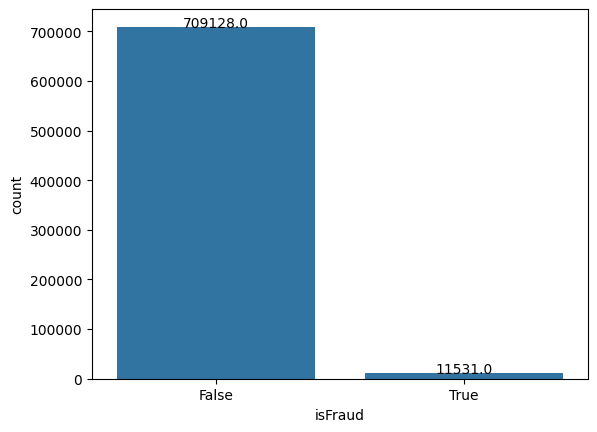

isFraud
False    709128
True      11531
Name: count, dtype: int64


In [45]:
sns.countplot(data=transactions, x='isFraud')
ax = plt.gca()

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{height}', ha='center')

plt.show()

print(transactions['isFraud'].value_counts())

In [46]:
minority_percent = round(transactions['isFraud'].value_counts()[True] / len(transactions) * 100, 2)
imbal_ratio = round(max(transactions['isFraud'].value_counts())/ min(transactions['isFraud'].value_counts()), 2)

print("After Data Cleaning")
print("Percentage of minority class: ", minority_percent, '%')
print("Imbalance Ratio: ", imbal_ratio)


After Data Cleaning
Percentage of minority class:  1.6 %
Imbalance Ratio:  61.5


The dataset is severly imbalanced, we will need to evaluate the model by employing undersampling, oversampling, and no sampling

## Part 4I - Data Visualization

We examine the correlation matrix of the numerical columns

<Axes: >

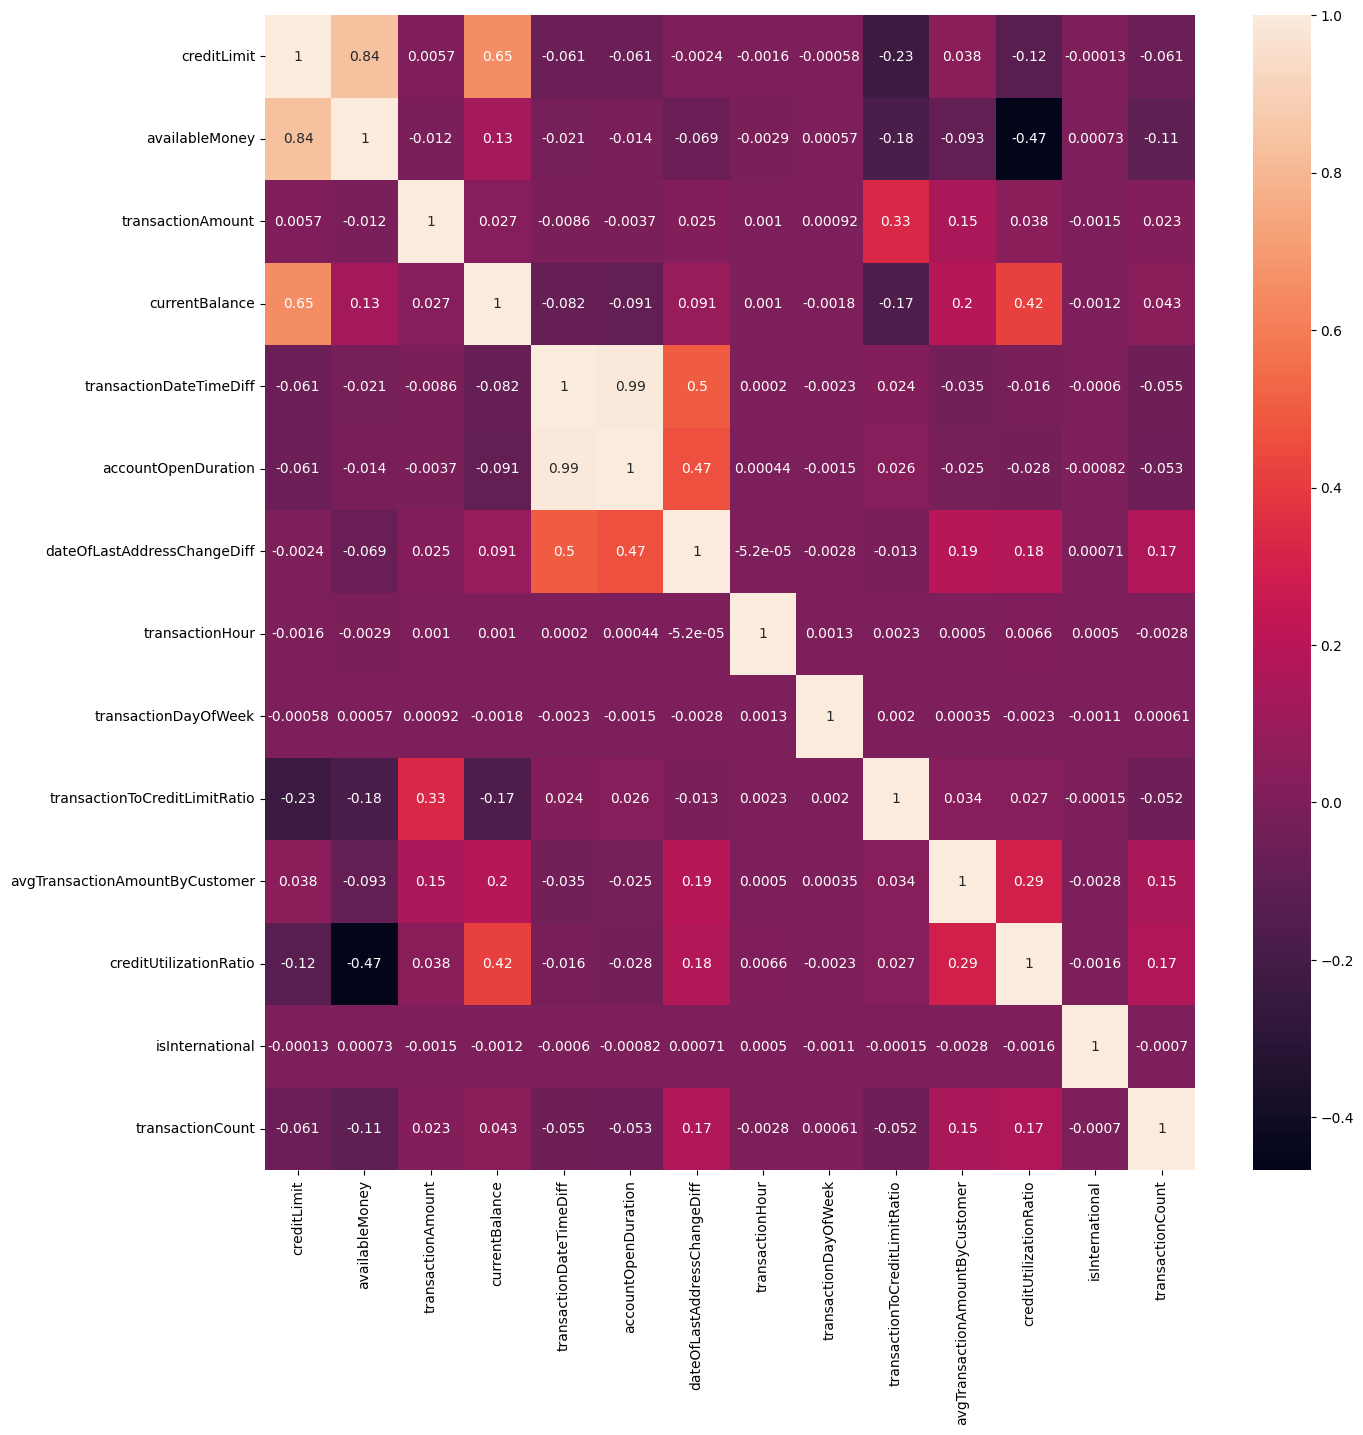

In [47]:
numerical_df = transactions.select_dtypes(include=['int', 'float'])
numerical_df

corr = numerical_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True)

In [48]:
corr.round(3)

creditLimit  availableMoney  \
creditLimit                           1.000           0.835   
availableMoney                        0.835           1.000   
transactionAmount                     0.006          -0.012   
currentBalance                        0.652           0.127   
transactionDateTimeDiff              -0.061          -0.021   
accountOpenDuration                  -0.061          -0.014   
dateOfLastAddressChangeDiff          -0.002          -0.069   
transactionHour                      -0.002          -0.003   
transactionDayOfWeek                 -0.001           0.001   
transactionToCreditLimitRatio        -0.229          -0.179   
avgTransactionAmountByCustomer        0.038          -0.093   
creditUtilizationRatio               -0.124          -0.467   
isInternational                      -0.000           0.001   
transactionCount                     -0.061          -0.110   

                                transactionAmount  currentBalance  \
creditLimit                                 0.006           0.652   
availableMoney                             -0.012           0.127   
transactionAmount                           1.000           0.027   
currentBalance                              0.027           1.000   
transactionDateTimeDiff                    -0.009          -0.082   
accountOpenDuration                        -0.004          -0.091   
dateOfLastAddressChangeDiff                 0.025           0.091   
transactionHour                             0.001           0.001   
transactionDayOfWeek                        0.001          -0.002   
transactionToCreditLimitRatio               0.334          -0.166   
avgTransactionAmountByCustomer              0.150           0.197   
creditUtilizationRatio                      0.038           0.420   
isInternational                            -0.002          -0.001   
transactionCount                            0.023           0.043   

                                transactionDateTimeDiff  accountOpenDuration  \
creditLimit                                      -0.061               -0.061   
availableMoney                                   -0.021               -0.014   
transactionAmount                                -0.009               -0.004   
currentBalance                                   -0.082               -0.091   
transactionDateTimeDiff                           1.000                0.989   
accountOpenDuration                               0.989                1.000   
dateOfLastAddressChangeDiff                       0.496                0.465   
transactionHour                                   0.000                0.000   
transactionDayOfWeek                             -0.002               -0.001   
transactionToCreditLimitRatio                     0.024                0.026   
avgTransactionAmountByCustomer                   -0.035               -0.025   
creditUtilizationRatio                           -0.016               -0.028   
isInternational                                  -0.001               -0.001   
transactionCount                                 -0.055               -0.053   

                                dateOfLastAddressChangeDiff  transactionHour  \
creditLimit                                          -0.002           -0.002   
availableMoney                                       -0.069           -0.003   
transactionAmount                                     0.025            0.001   
currentBalance                                        0.091            0.001   
transactionDateTimeDiff                               0.496            0.000   
accountOpenDuration                                   0.465            0.000   
dateOfLastAddressChangeDiff                           1.000           -0.000   
transactionHour                                      -0.000            1.000   
transactionDayOfWeek                                 -0.003            0.001   
transactionToCreditLimitRatio                    

Insert

Quick histogram of the numerical columns to see if there is anything worth investigating

array([[<Axes: title={'center': 'creditLimit'}>,
        <Axes: title={'center': 'availableMoney'}>,
        <Axes: title={'center': 'transactionDateTime'}>,
        <Axes: title={'center': 'transactionAmount'}>],
       [<Axes: title={'center': 'currentExpDate'}>,
        <Axes: title={'center': 'accountOpenDate'}>,
        <Axes: title={'center': 'dateOfLastAddressChange'}>,
        <Axes: title={'center': 'currentBalance'}>],
       [<Axes: title={'center': 'transactionDateTimeDiff'}>,
        <Axes: title={'center': 'accountOpenDuration'}>,
        <Axes: title={'center': 'dateOfLastAddressChangeDiff'}>,
        <Axes: title={'center': 'transactionHour'}>],
       [<Axes: title={'center': 'transactionDayOfWeek'}>,
        <Axes: title={'center': 'transactionToCreditLimitRatio'}>,
        <Axes: title={'center': 'avgTransactionAmountByCustomer'}>,
        <Axes: title={'center': 'creditUtilizationRatio'}>],
       [<Axes: title={'center': 'isInternational'}>,
        <Axes: title={'

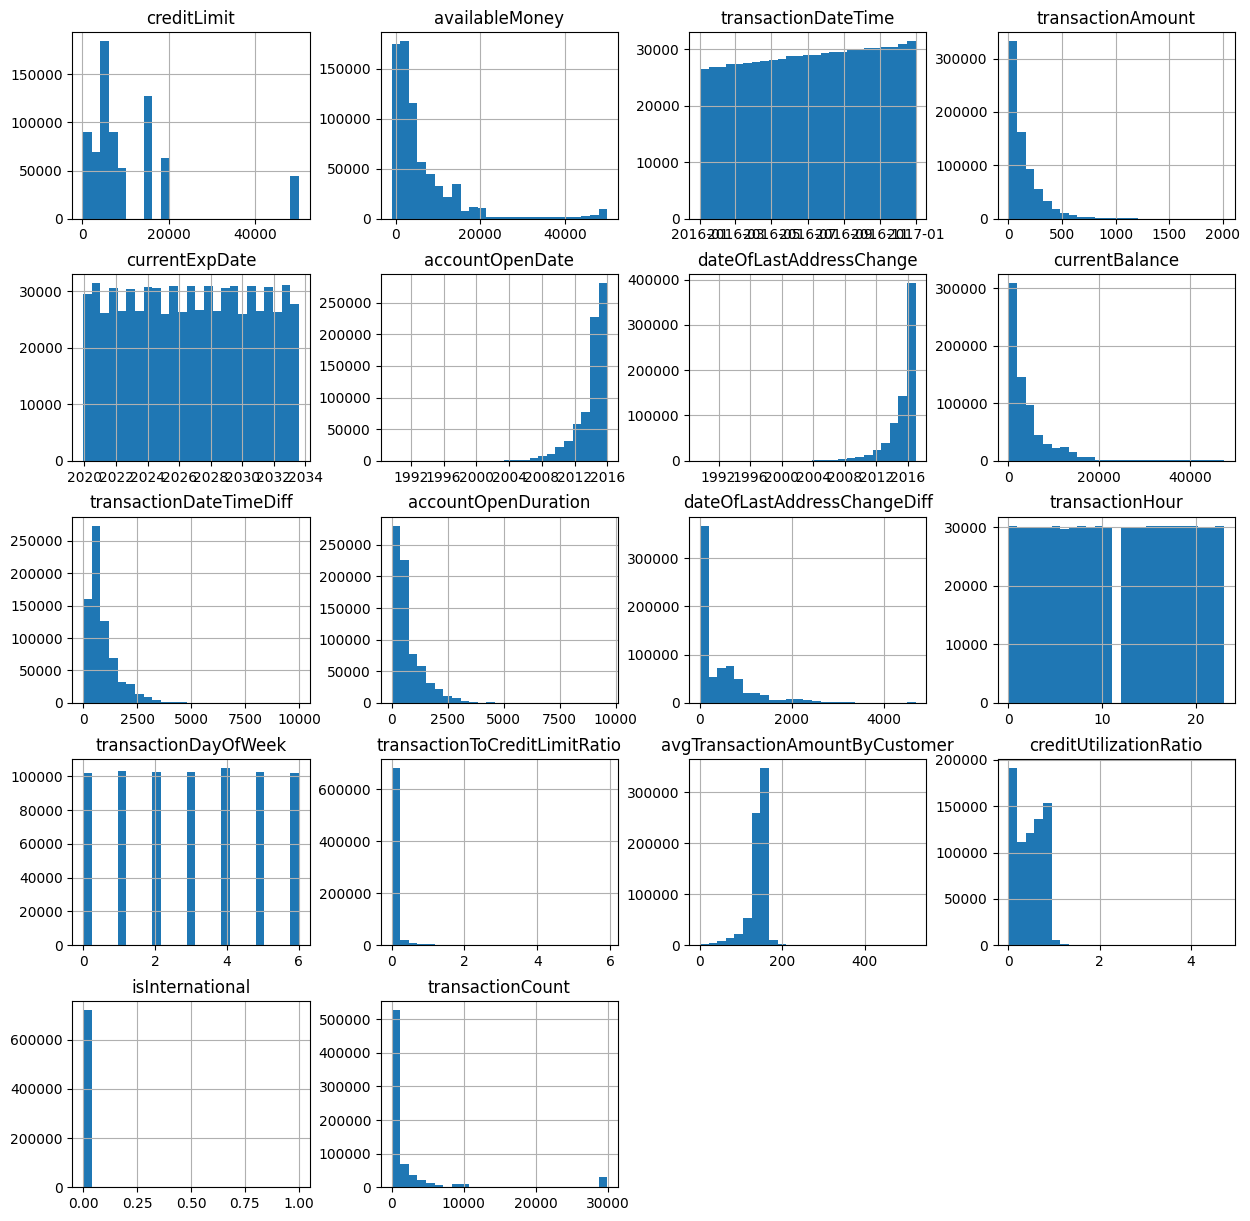

In [49]:
transactions.hist(bins = 25, figsize = (15,15))

Text(0.5, 1.0, 'Transaction Amount by Fraud Status')

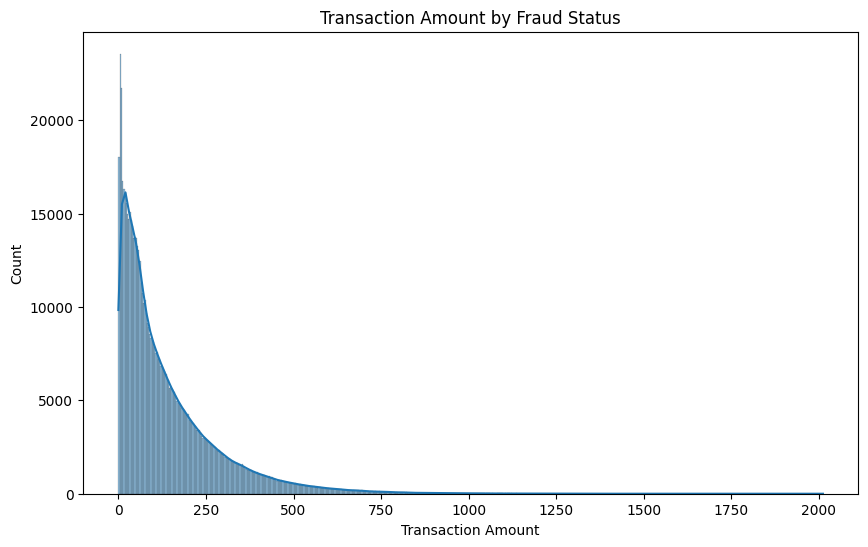

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(data = transactions, kde=True, x = 'transactionAmount')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Transaction Amount by Fraud Status')


The transaction column is severly right skewed, where a majority of the data is less than $250. Maybe we need to employ feature transformation on the skewed feature: transactionAmount, AvailibleMoney, CreditBalance.

I would hypothesize that most customers typically do not often make big pruchases, which would explain the skewed nature. 

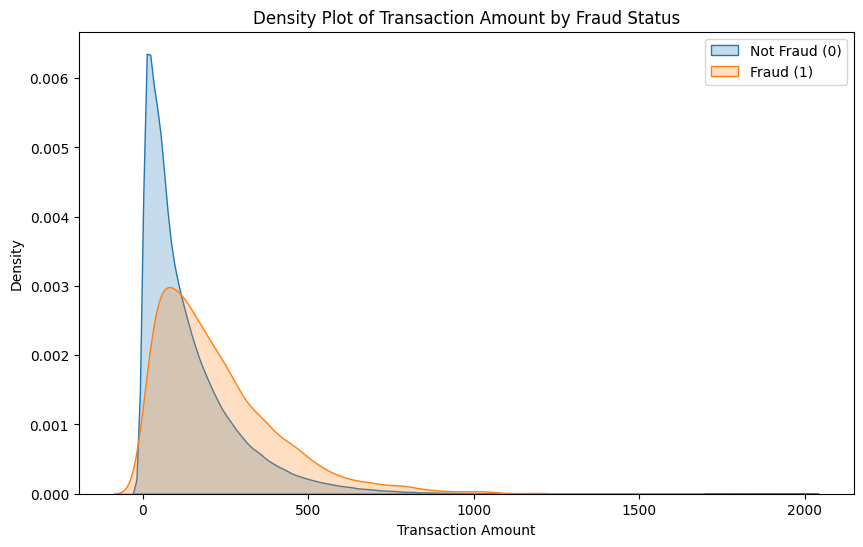

In [51]:
plt.figure(figsize=(10, 6))

# Density plot for isFraud = 0
sns.kdeplot(transactions[transactions['isFraud'] == 0]['transactionAmount'], label='Not Fraud (0)', shade=True)

# Density plot for isFraud = 1
sns.kdeplot(transactions[transactions['isFraud'] == 1]['transactionAmount'], label='Fraud (1)', shade=True)

# Add percentage text for each category
total_not_fraud = len(transactions[transactions['isFraud'] == 0])
total_fraud = len(transactions[transactions['isFraud'] == 1])

# Plot labels and title
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.title('Density Plot of Transaction Amount by Fraud Status')

# Show plot
plt.legend()
plt.show()

The transactionAmount is heavily right skewed and when we take a look at the density plot after of the fraud only and nonfraud only plots, we see a different shape curve. I will attempt to exploit this with a transformation

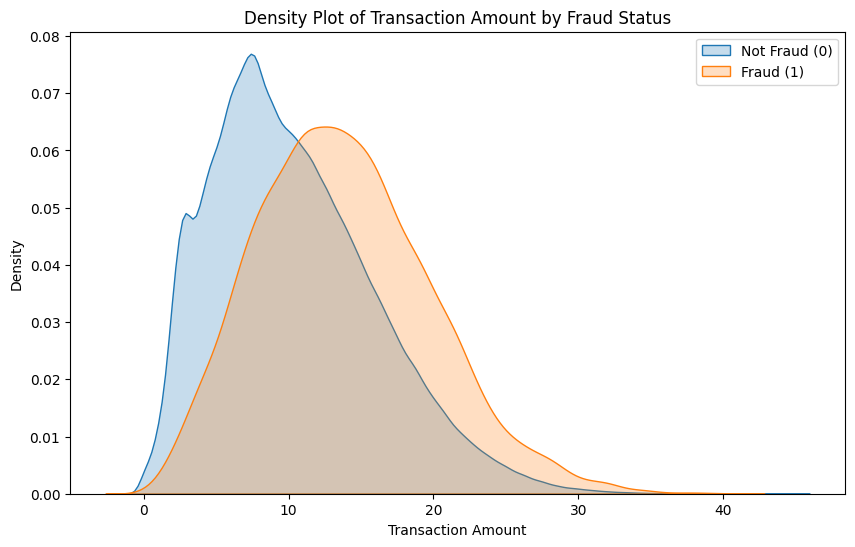

In [52]:
transactions_alter = transactions.copy()
transactions_alter['transactionAmount'] = (transactions_alter['transactionAmount'])**.5

plt.figure(figsize=(10, 6))

# Density plot for isFraud = 0
sns.kdeplot(transactions_alter[transactions_alter['isFraud'] == 0]['transactionAmount'], label='Not Fraud (0)', shade=True)

# Density plot for isFraud = 1
sns.kdeplot(transactions_alter[transactions_alter['isFraud'] == 1]['transactionAmount'], label='Fraud (1)', shade=True)

# Add percentage text for each category
total_not_fraud = len(transactions_alter[transactions_alter['isFraud'] == 0])
total_fraud = len(transactions_alter[transactions_alter['isFraud'] == 1])

# Plot labels and title
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.title('Density Plot of Transaction Amount by Fraud Status')

# Show plot
plt.legend()
plt.show()

Applied log transaformation, and saw improvement in the skewed nature of the plot and a better differeniation of the fraud and nonfraud. I will apply this feature transformation later on.

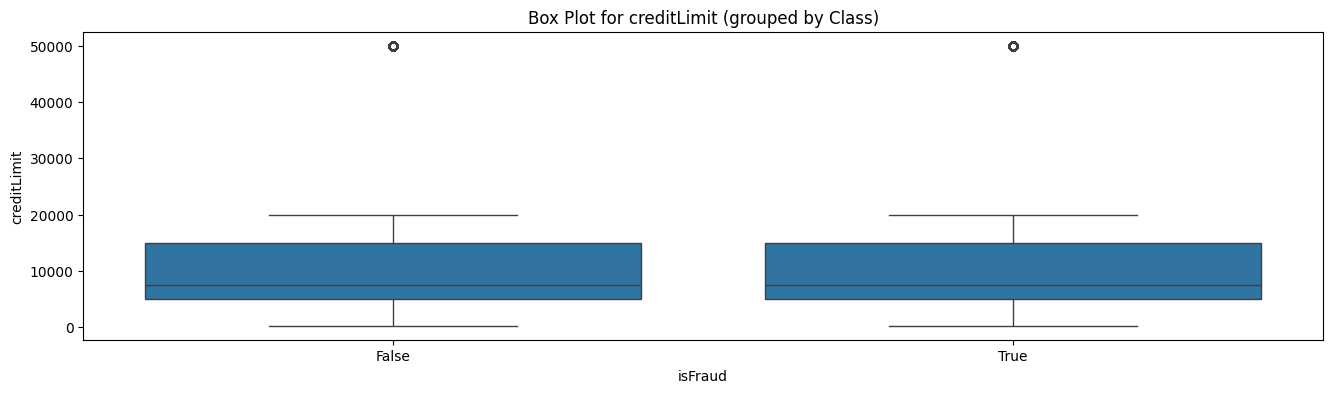

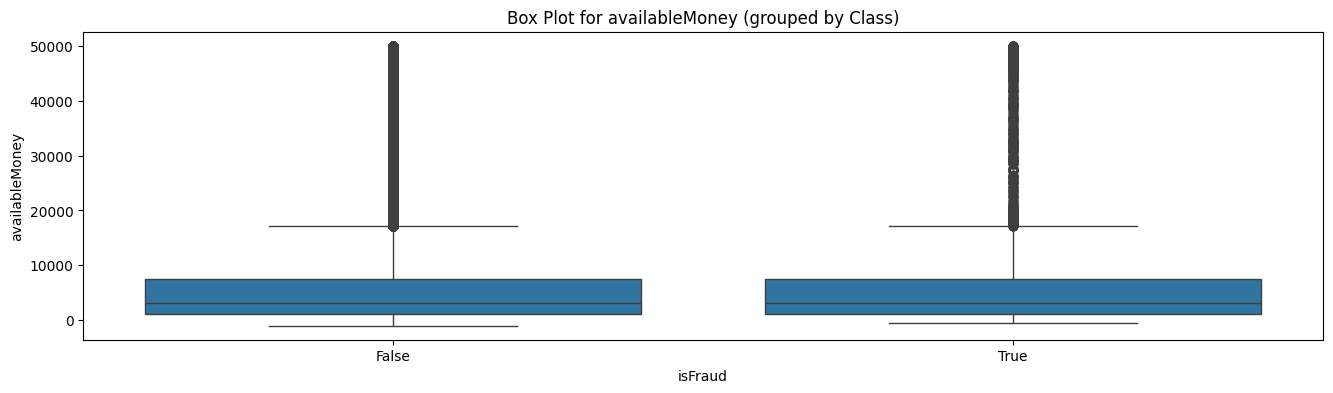

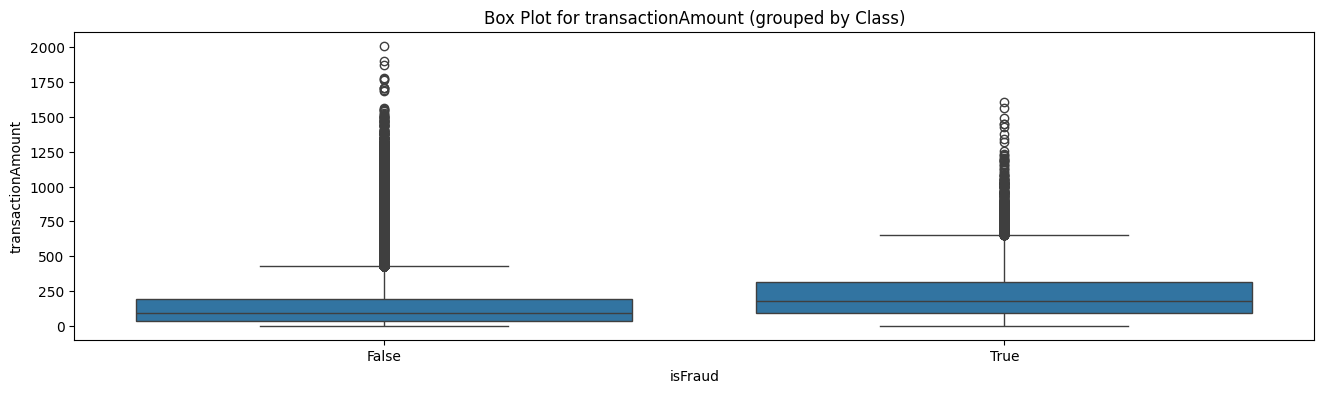

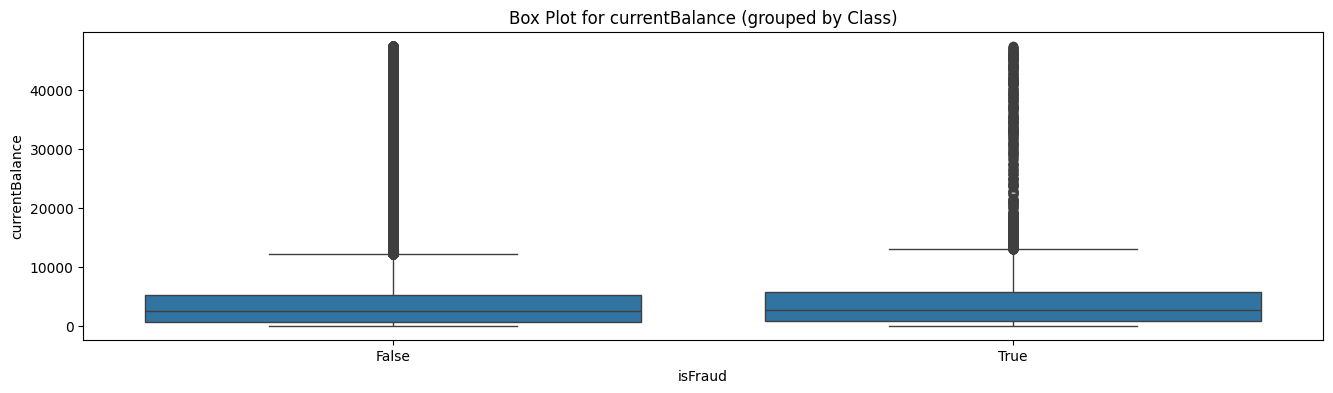

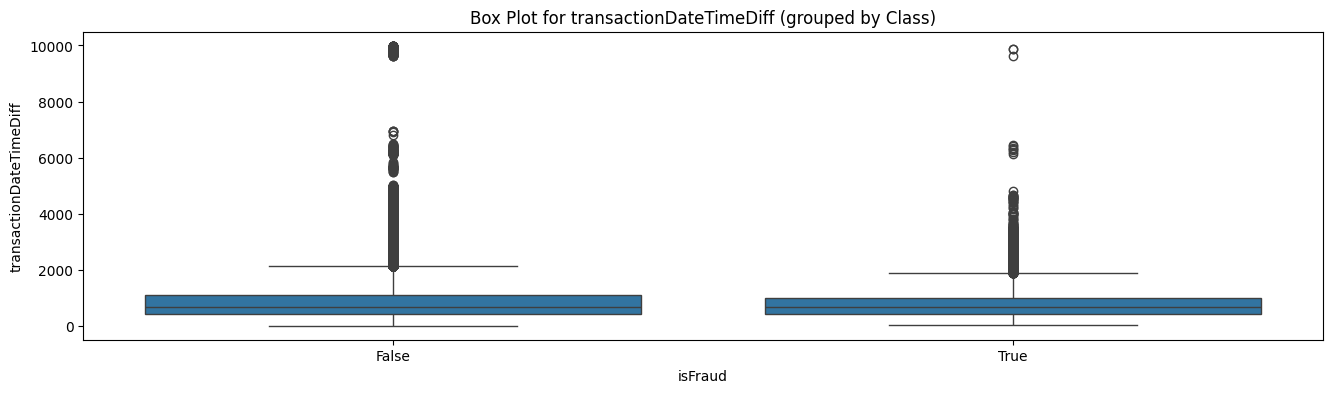

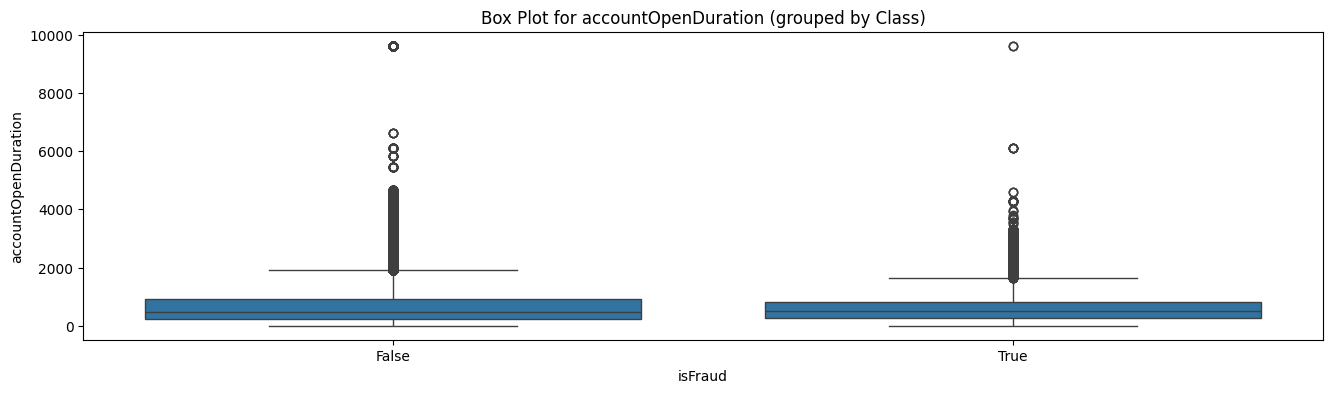

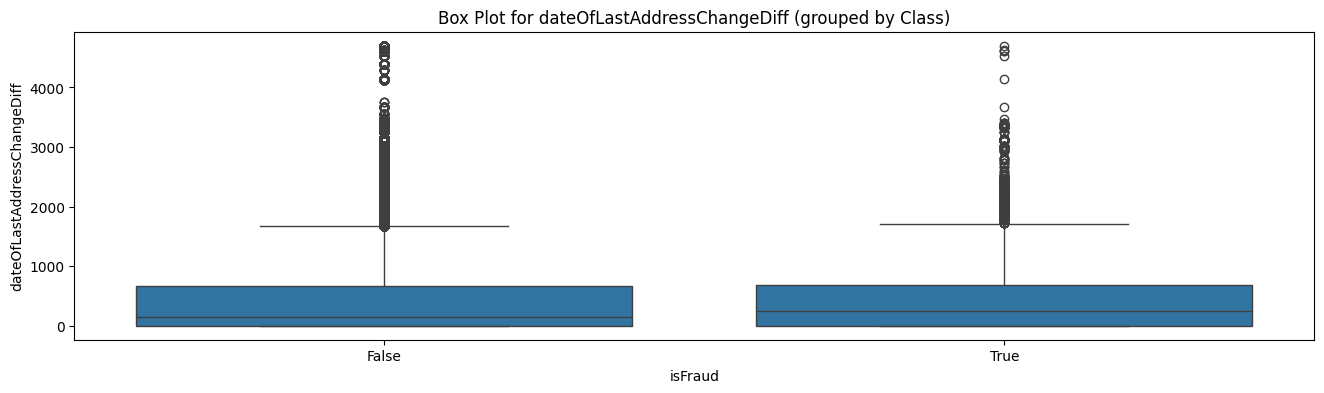

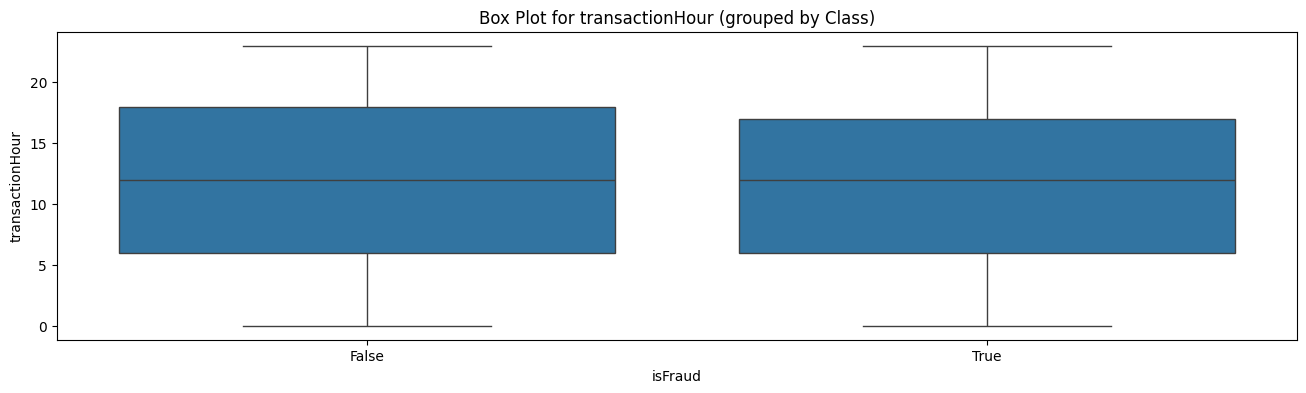

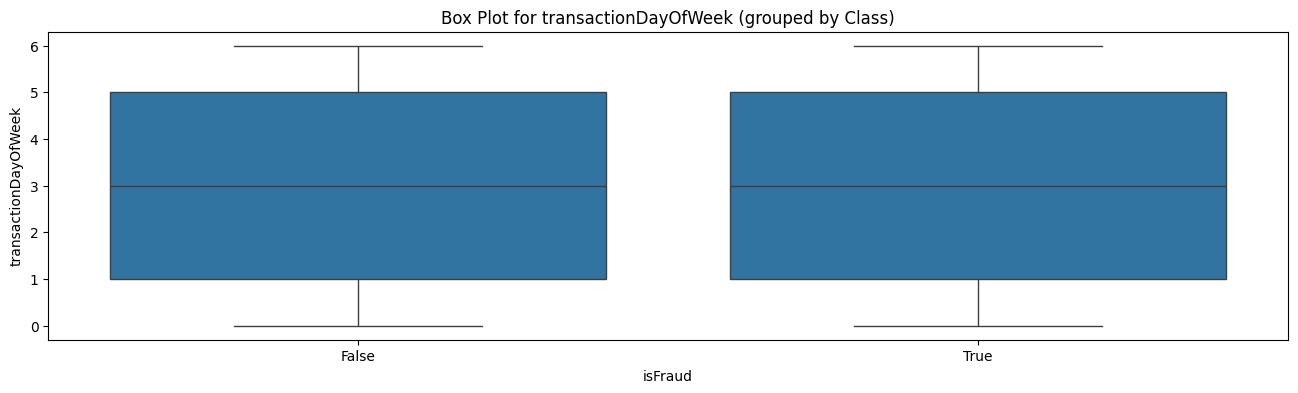

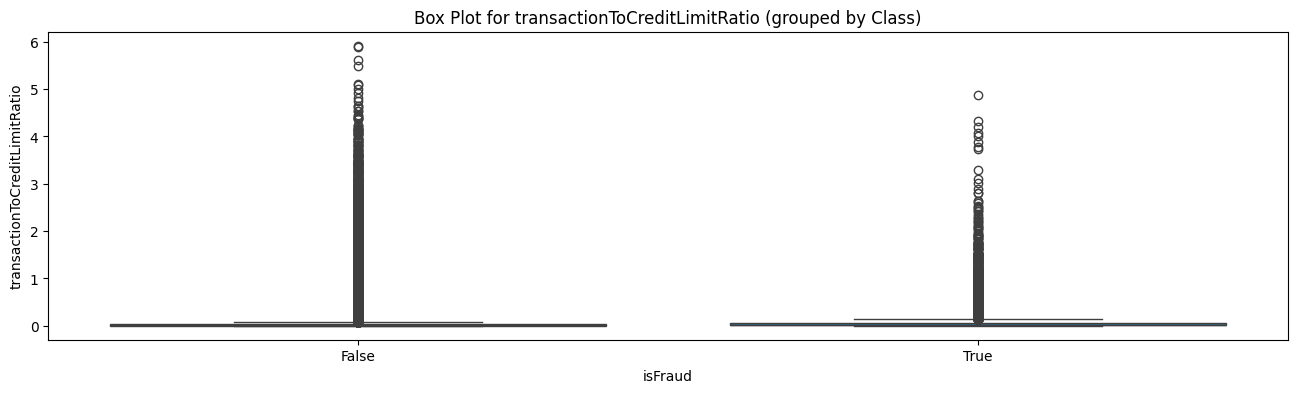

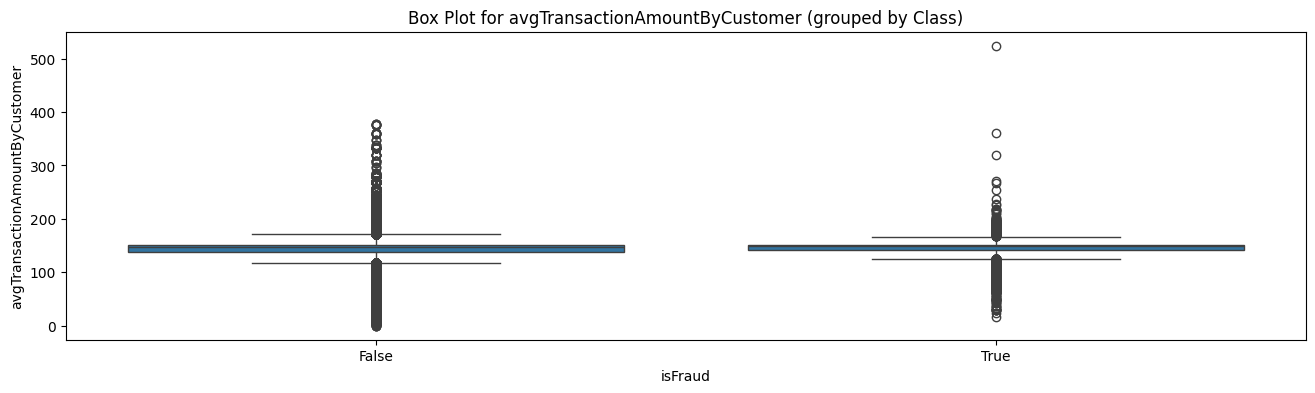

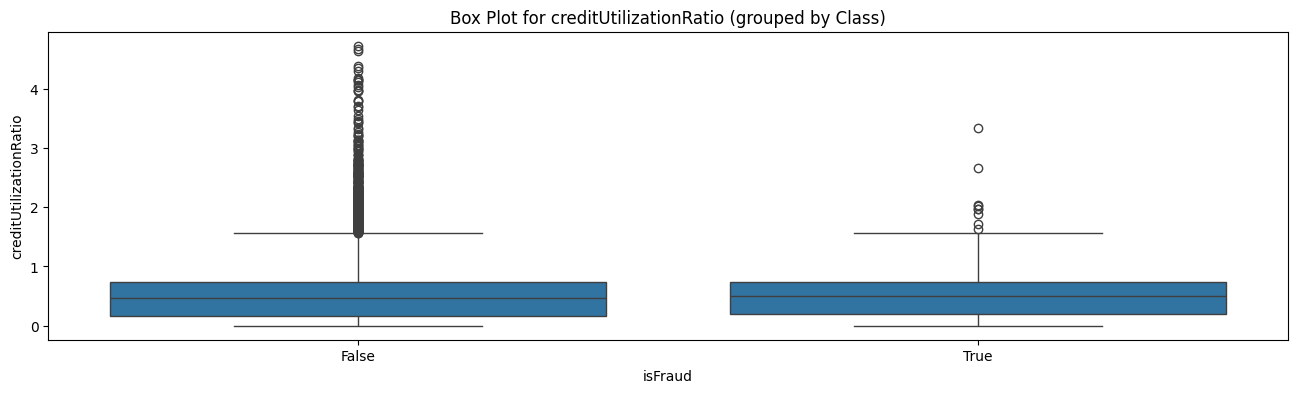

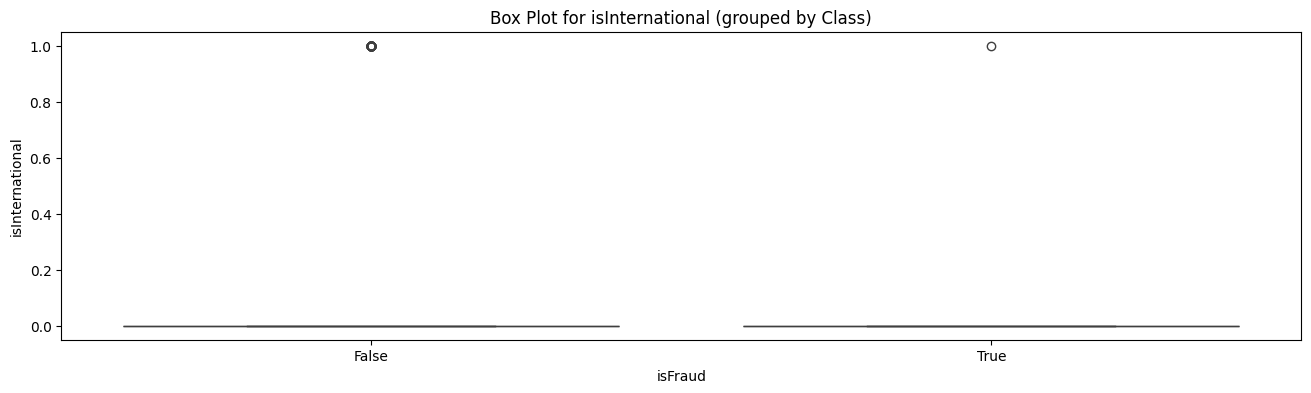

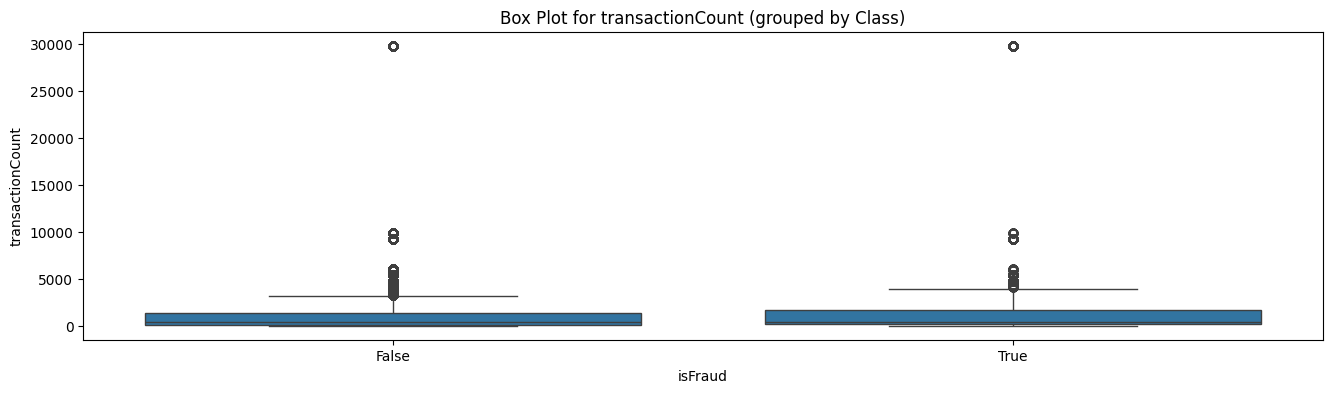

In [53]:
# Create box plots for each feature grouped by class
numerical_col = transactions.select_dtypes(include=['int', 'float']).columns.tolist()
numerical_col

for column in numerical_col:
    # Exclude the 'Class' column to avoid plotting box plots for the target variable
    if column != 'isFraud':
        plt.figure(figsize=(16, 4))

        # Plot a box plot for the current feature (column) grouped by 'Class' using seaborn
        sns.boxplot(data=transactions, x='isFraud', y=column).set_title(f'Box Plot for {column}')

        # Set the title of the plot based on the current feature (column)
        plt.title(f'Box Plot for {column} (grouped by Class)')

        plt.show()

We observe a few outliers with out box plot diagram, possibly due to the user with high credit limits and spending habits. Due to contraints in time and the limited number of fraud observations, I will not be able to investigate this further. 

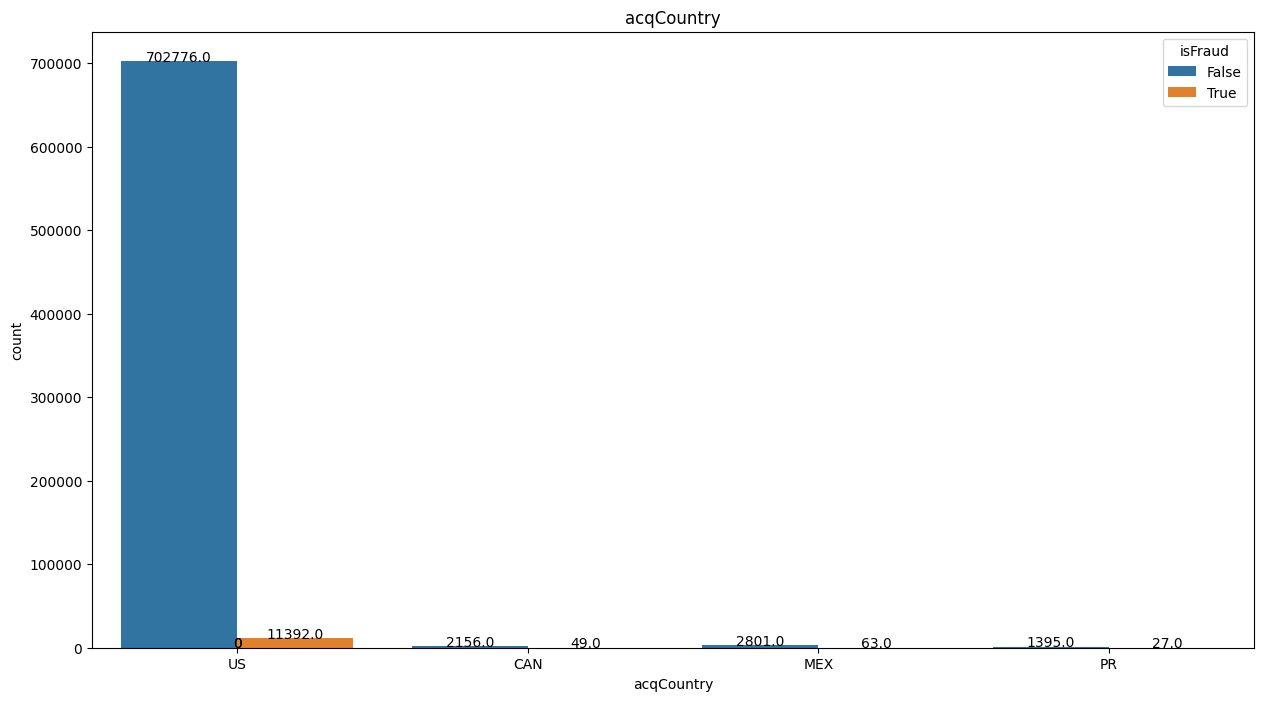

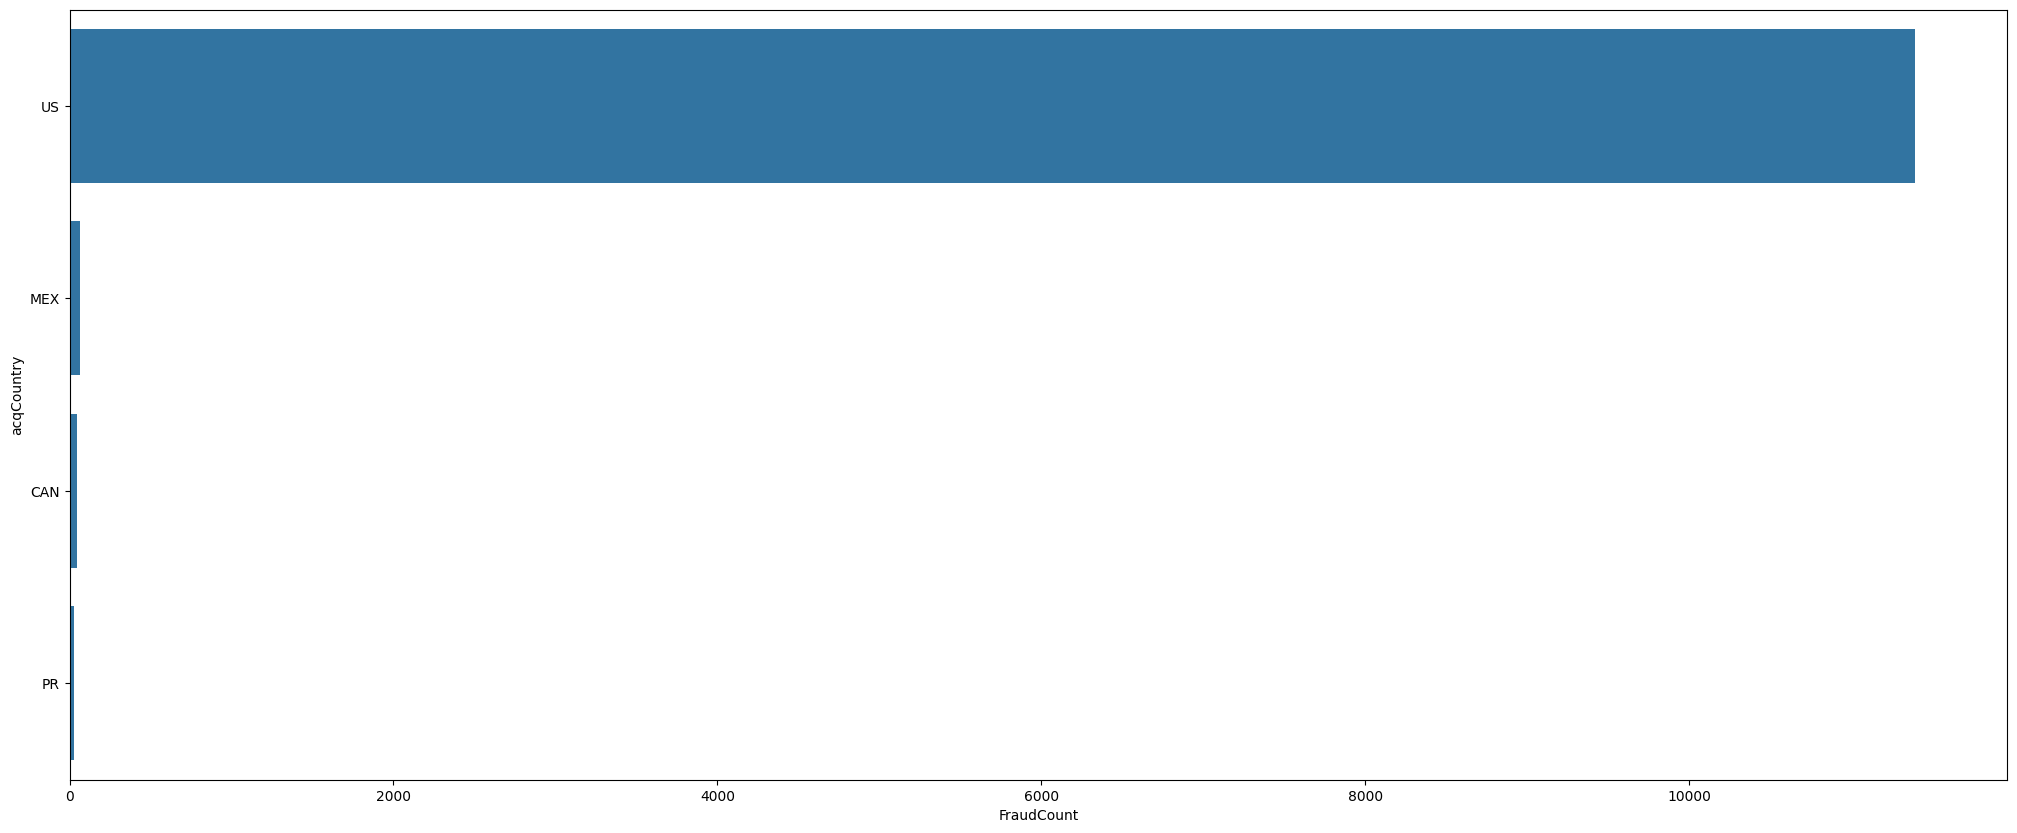

                     count  percentage
isFraud acqCountry                    
False   CAN           2156       97.78
        MEX           2801       97.80
        PR            1395       98.10
        US          702776       98.40
True    CAN             49        2.22
        MEX             63        2.20
        PR              27        1.90
        US           11392        1.60


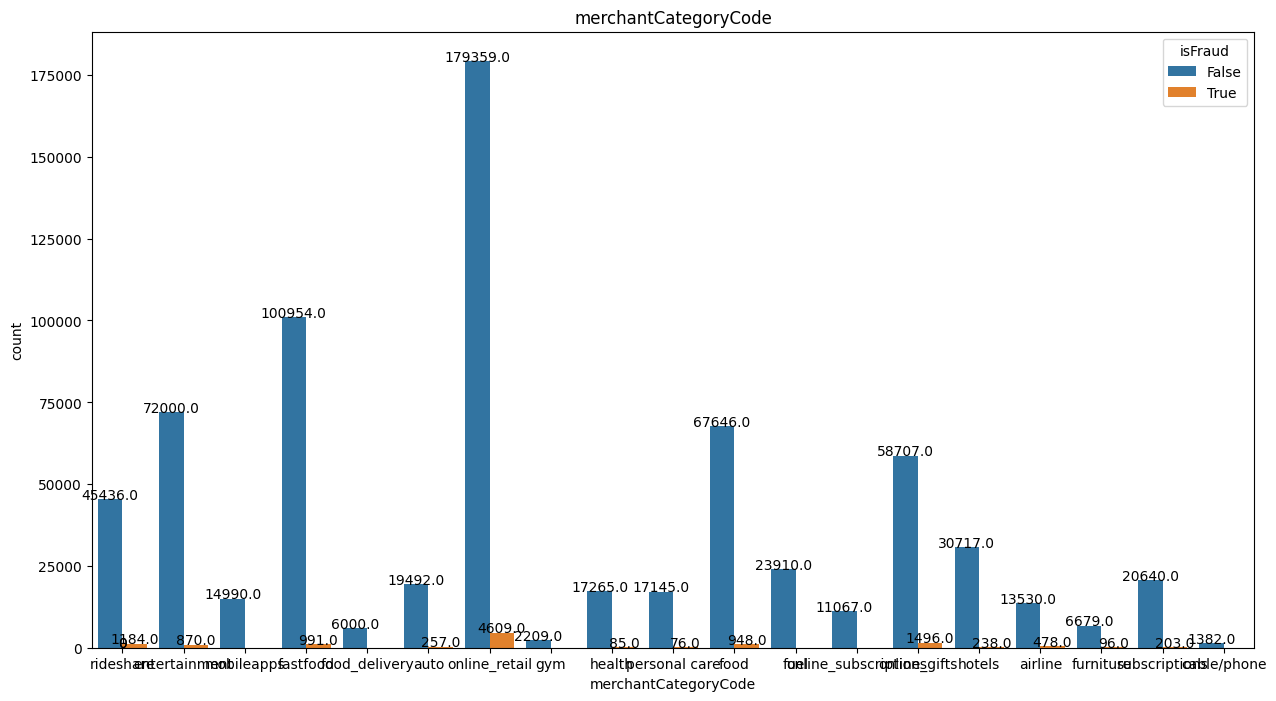

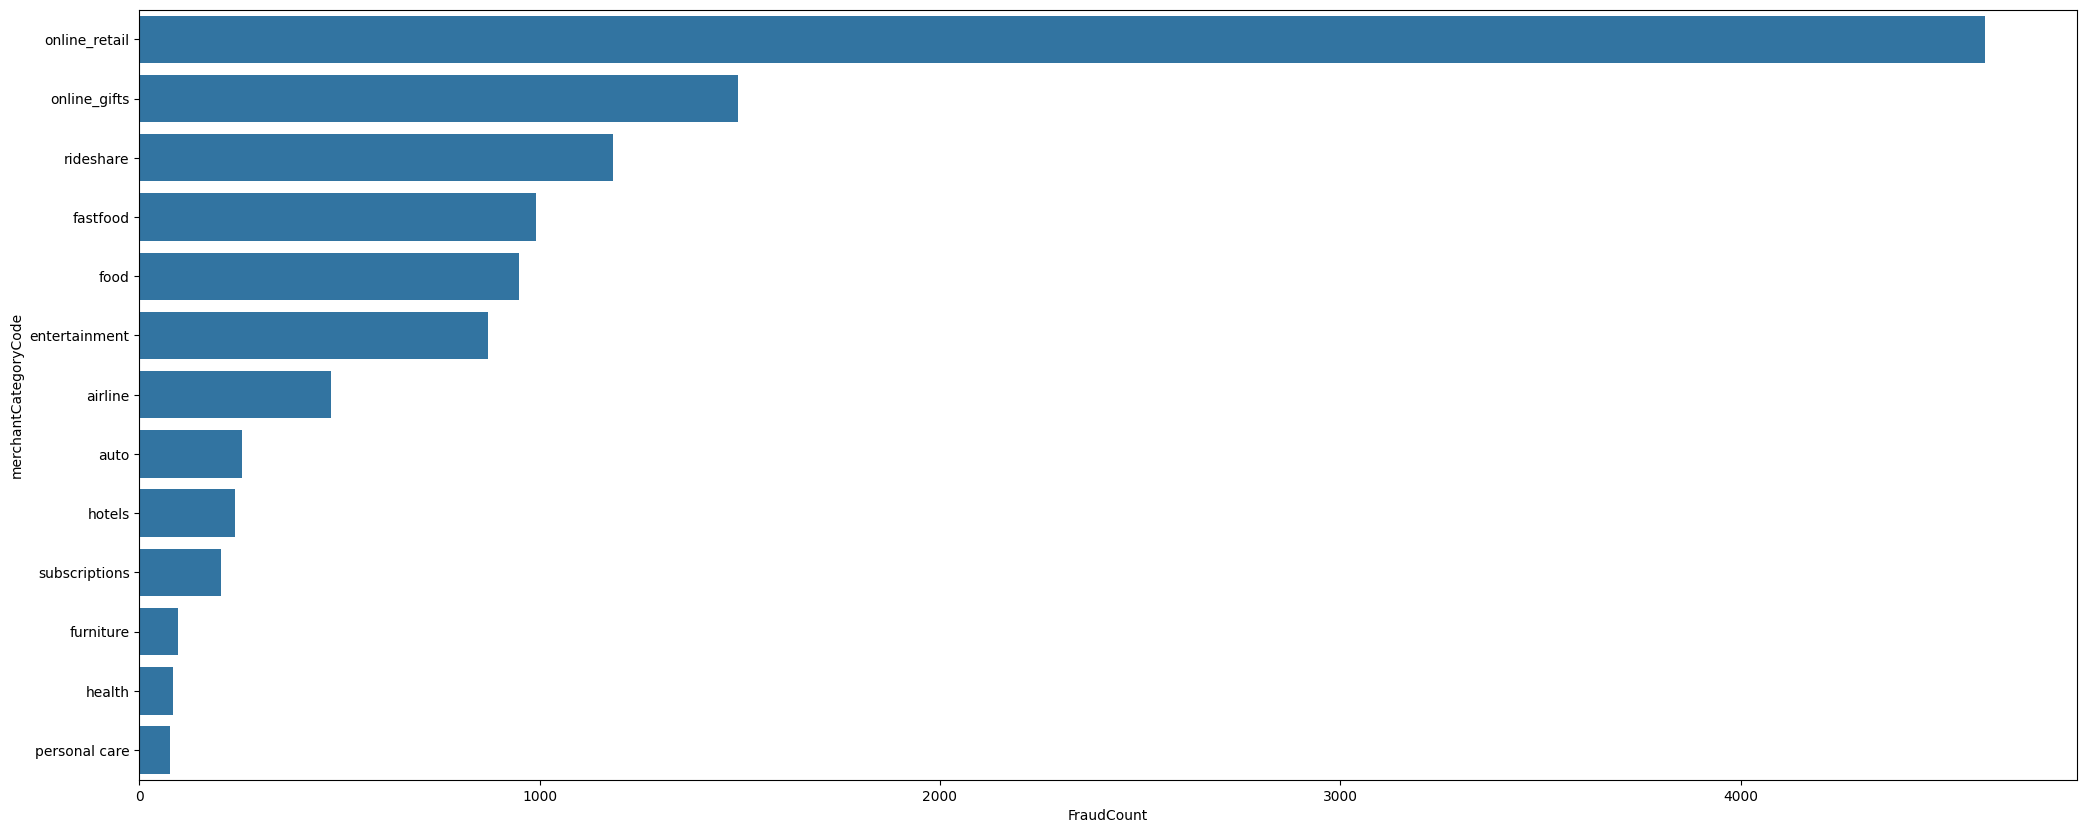

                               count  percentage
isFraud merchantCategoryCode                    
False   airline                13530       96.59
        auto                   19492       98.70
        cable/phone             1382      100.00
        entertainment          72000       98.81
        fastfood              100954       99.03
        food                   67646       98.62
        food_delivery           6000      100.00
        fuel                   23910      100.00
        furniture               6679       98.58
        gym                     2209      100.00
        health                 17265       99.51
        hotels                 30717       99.23
        mobileapps             14990      100.00
        online_gifts           58707       97.52
        online_retail         179359       97.49
        online_subscriptions   11067      100.00
        personal care          17145       99.56
        rideshare              45436       97.46
        subscription

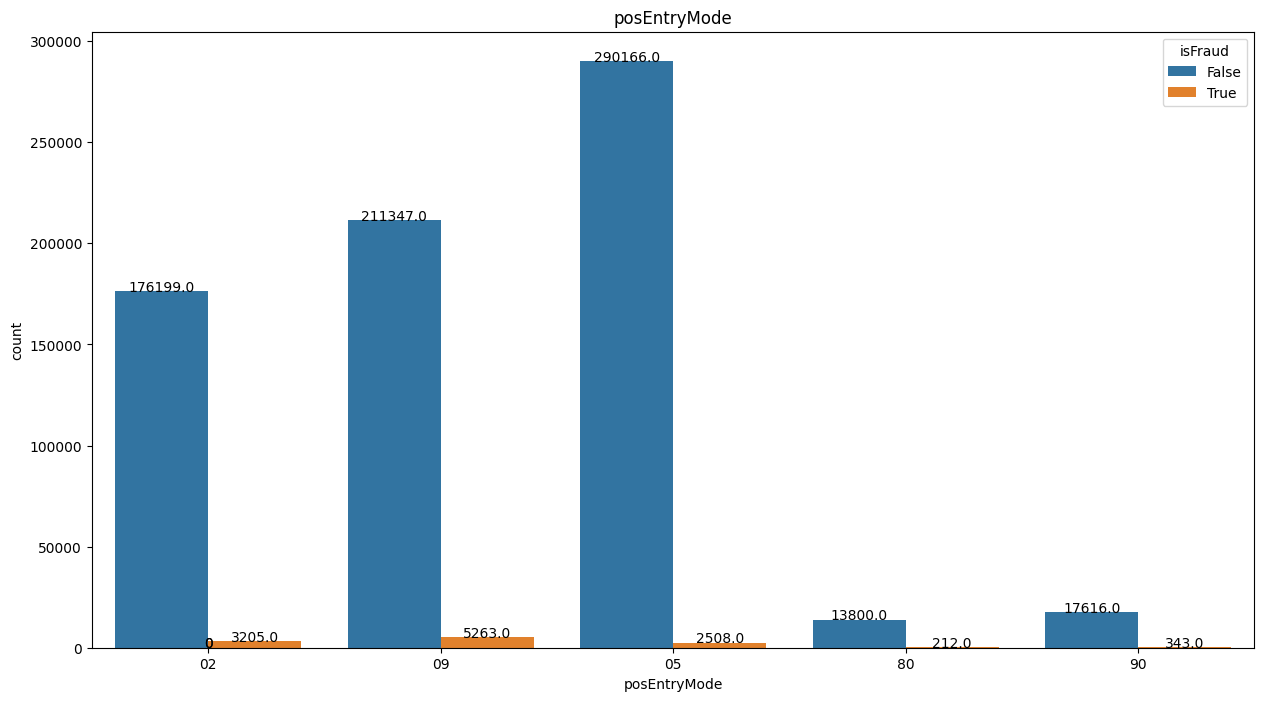

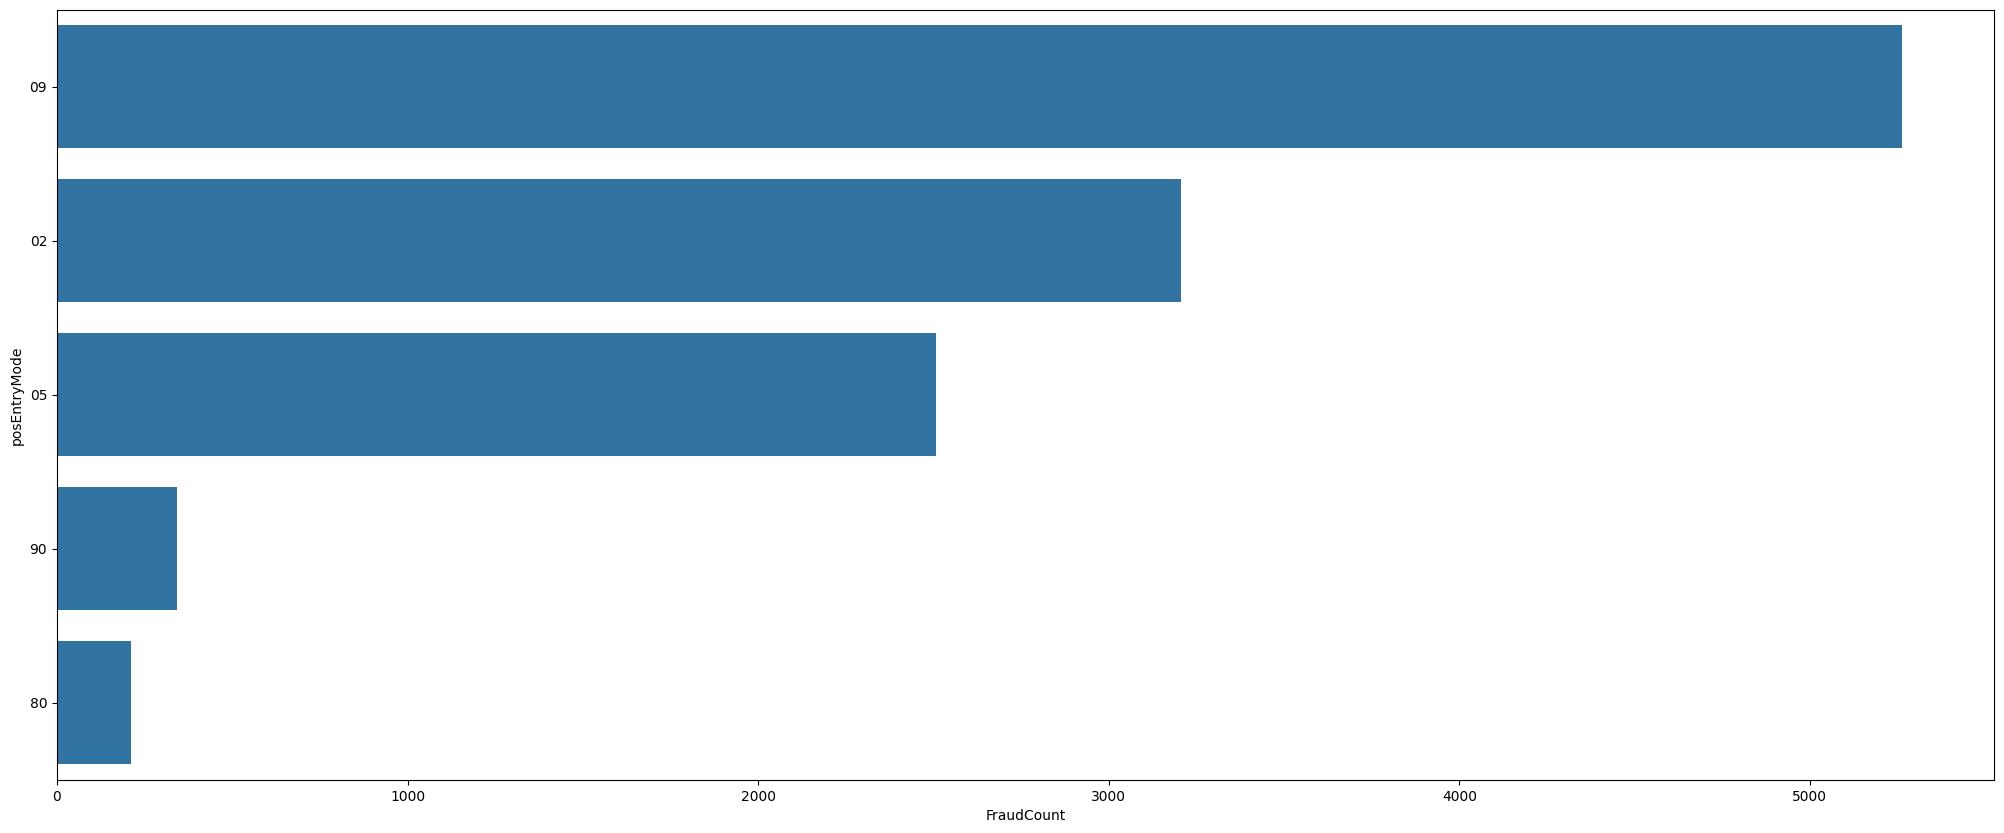

                       count  percentage
isFraud posEntryMode                    
False   02            176199       98.21
        05            290166       99.14
        09            211347       97.57
        80             13800       98.49
        90             17616       98.09
True    02              3205        1.79
        05              2508        0.86
        09              5263        2.43
        80               212        1.51
        90               343        1.91


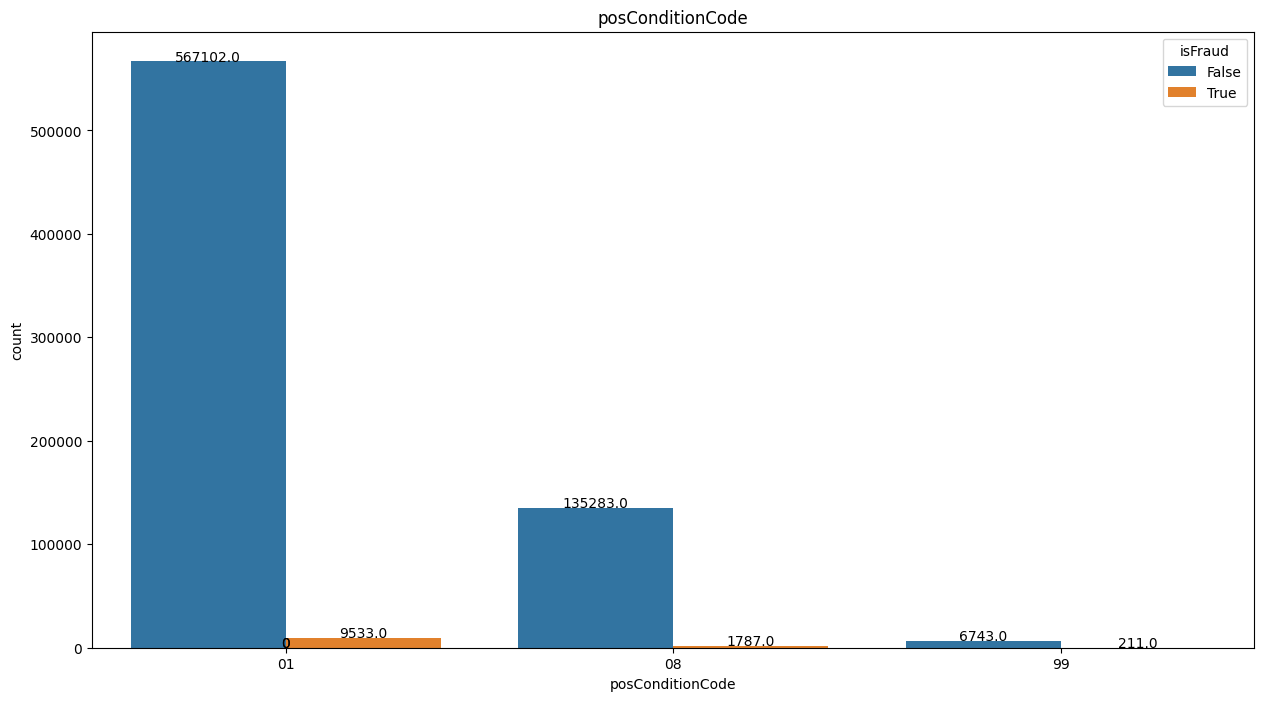

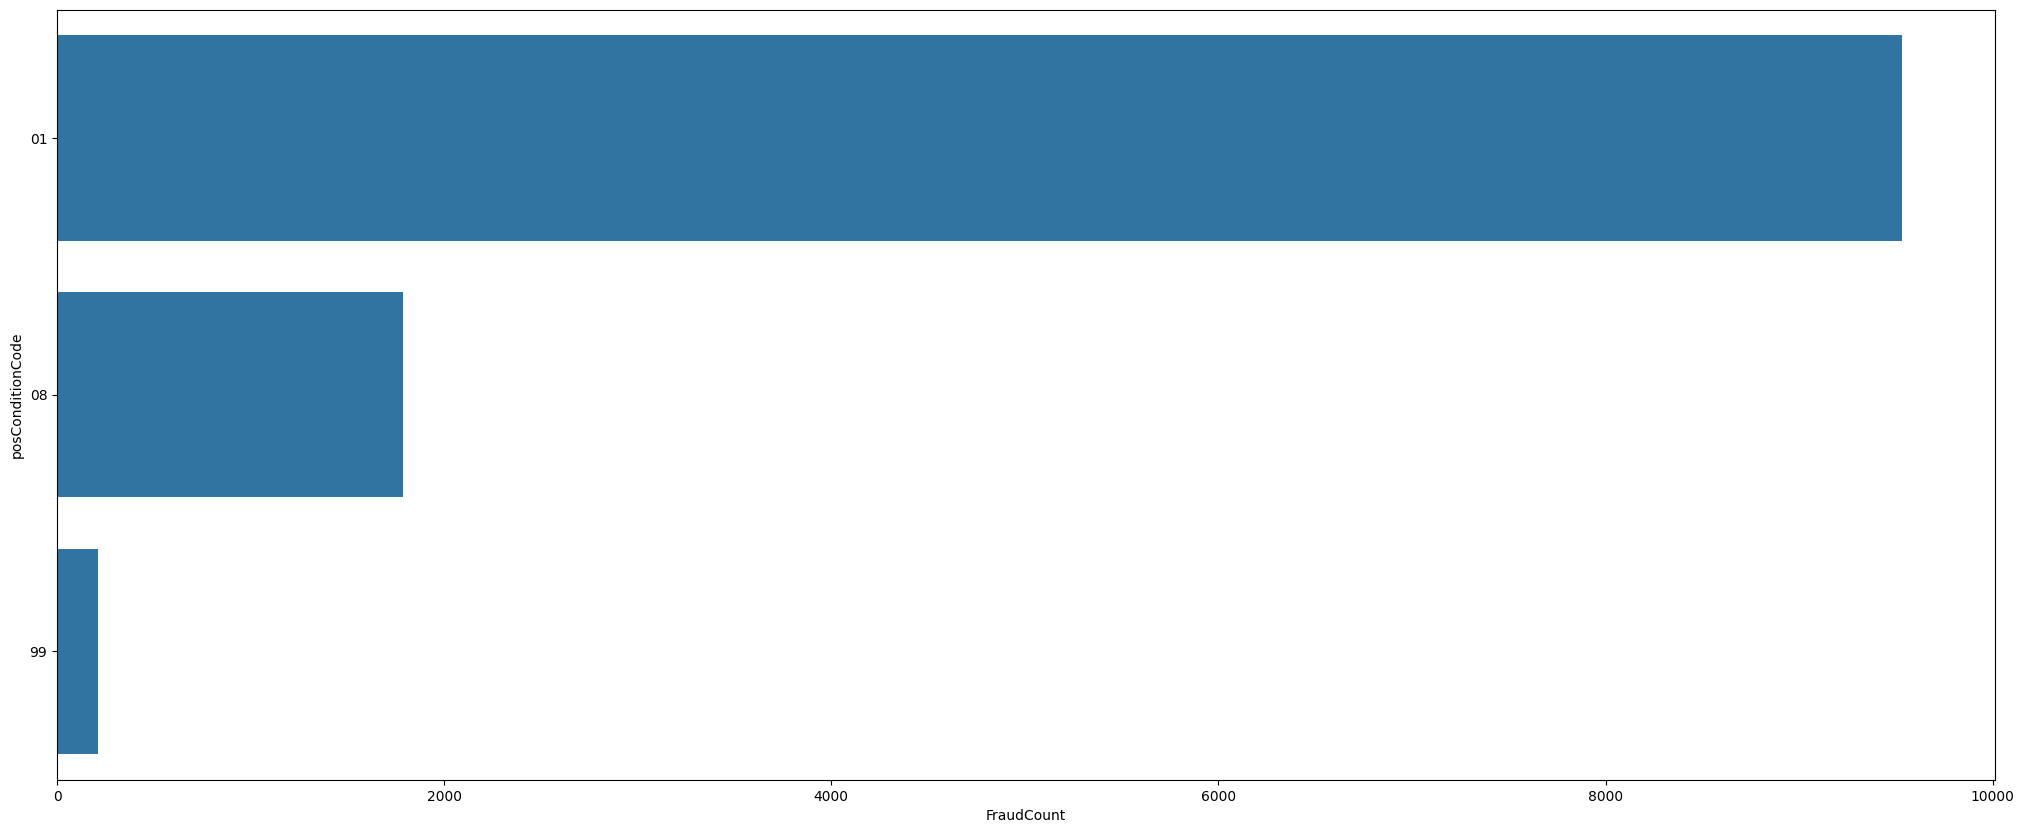

                           count  percentage
isFraud posConditionCode                    
False   01                567102       98.35
        08                135283       98.70
        99                  6743       96.97
True    01                  9533        1.65
        08                  1787        1.30
        99                   211        3.03


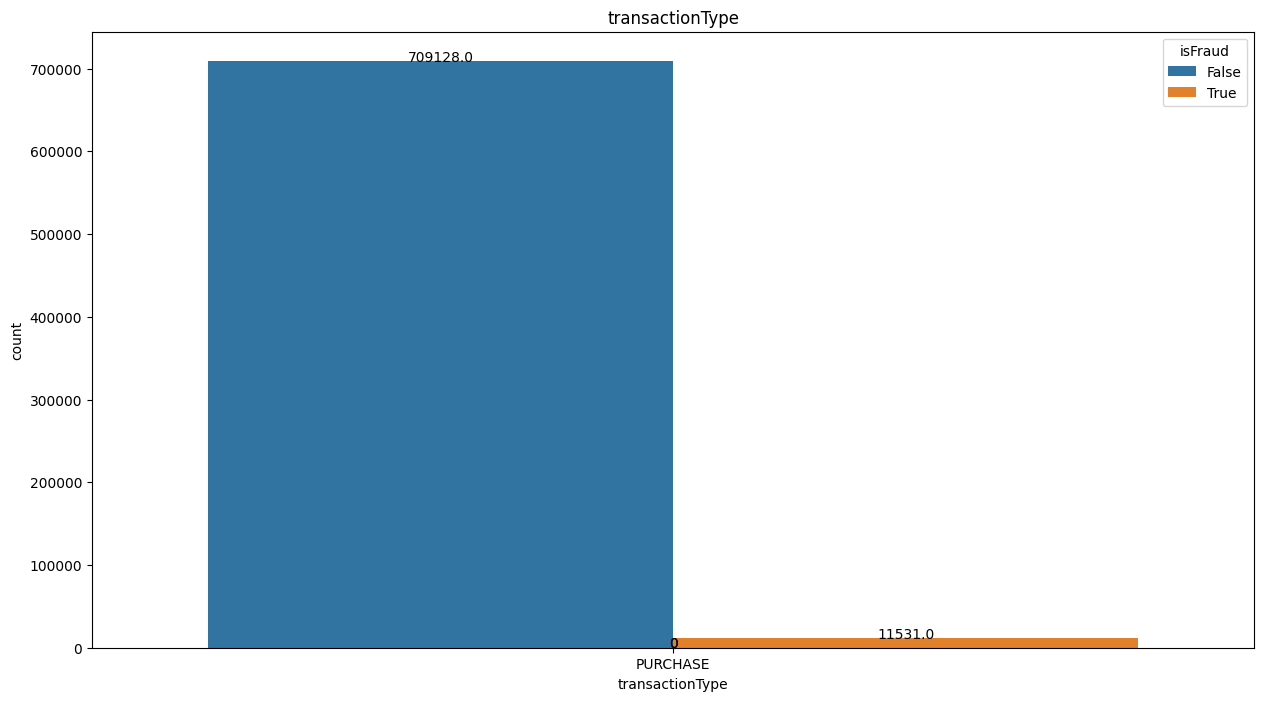

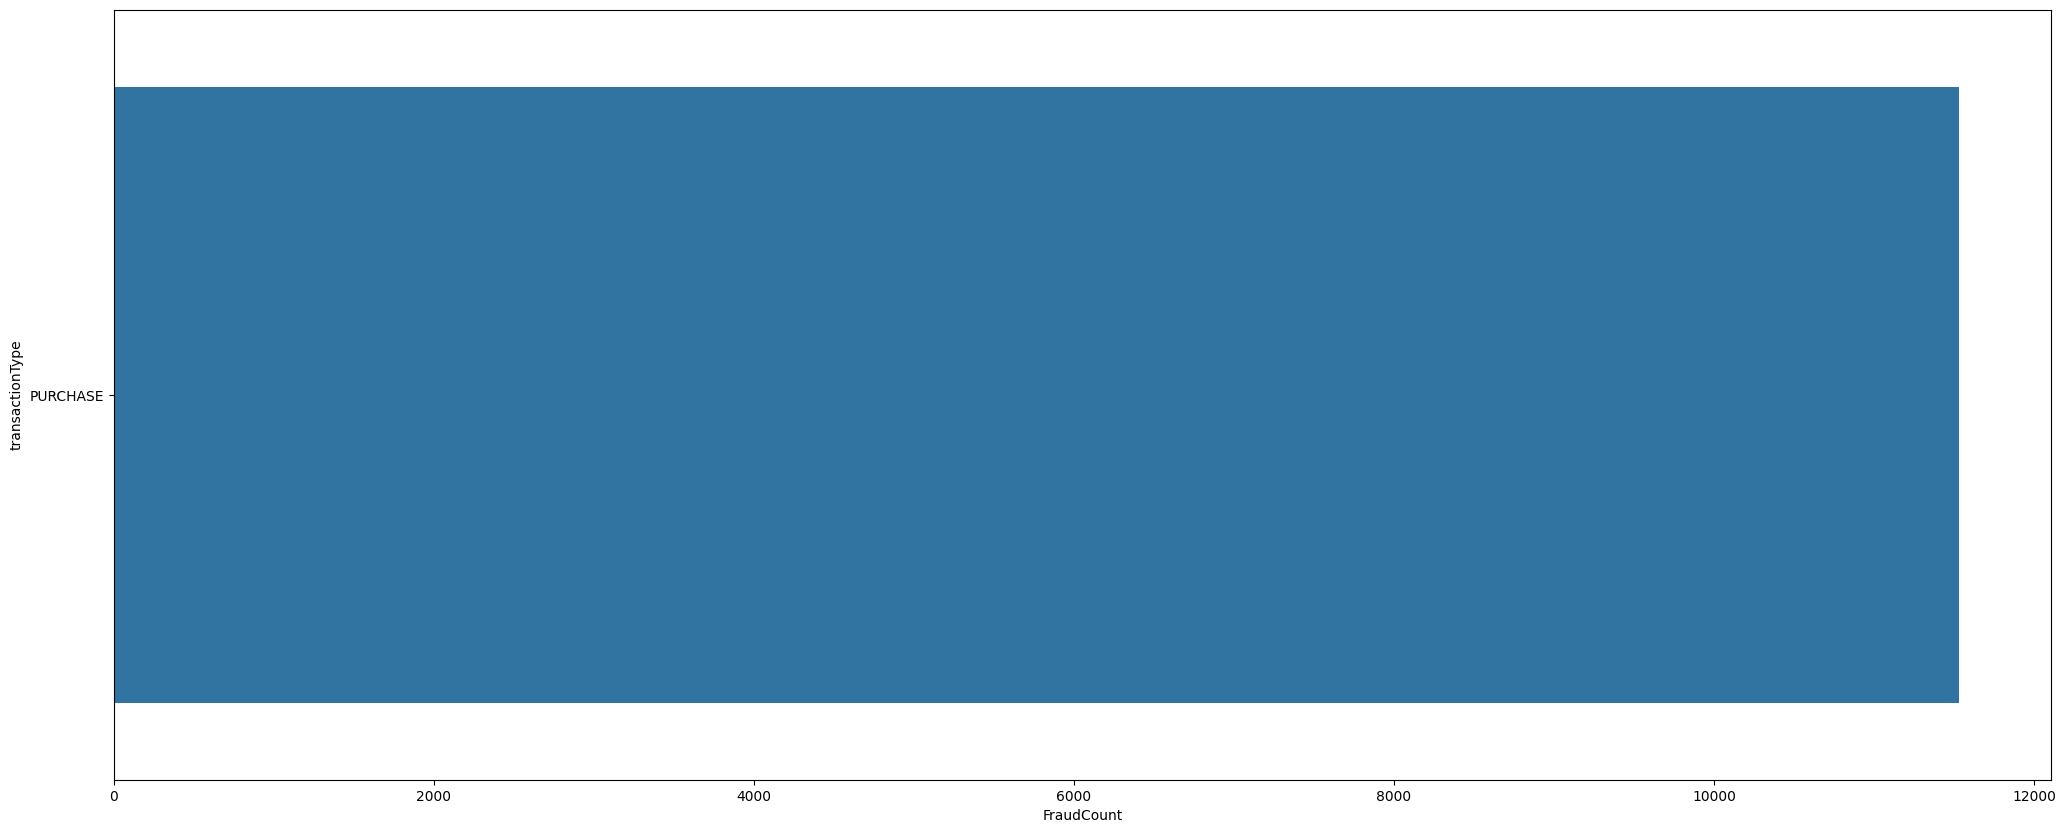

                          count  percentage
isFraud transactionType                    
False   PURCHASE         709128        98.4
True    PURCHASE          11531         1.6


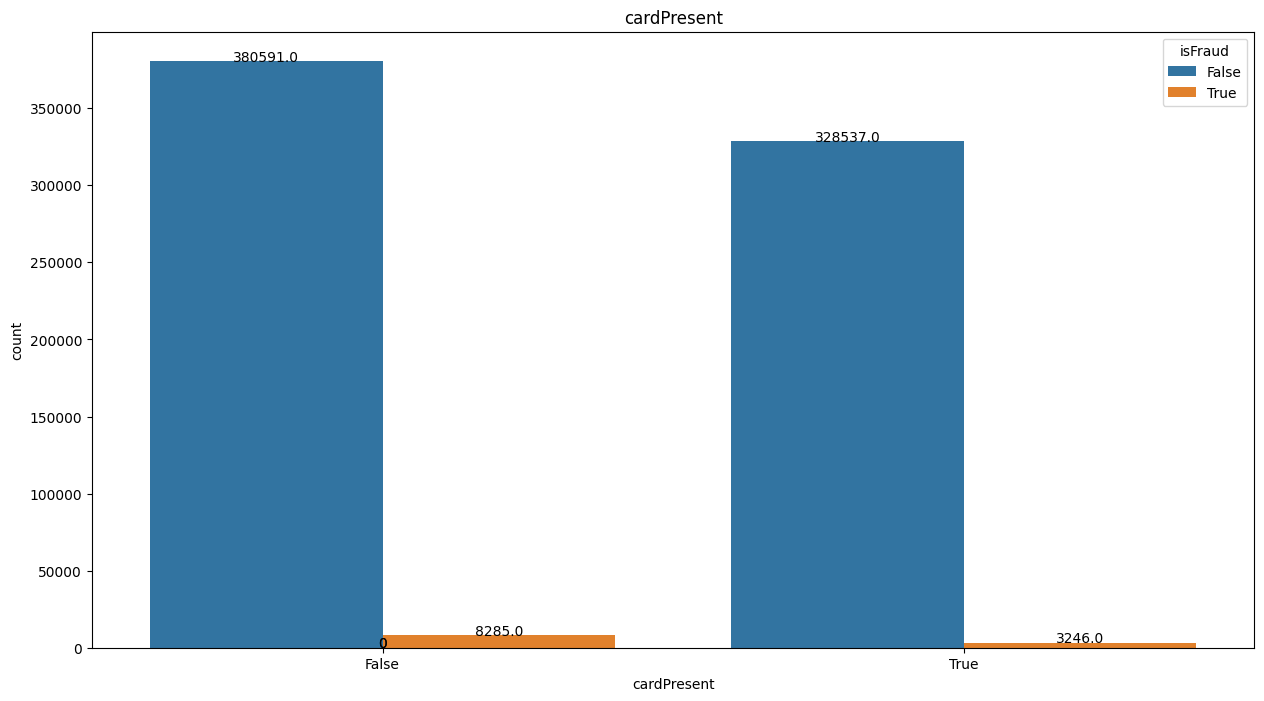

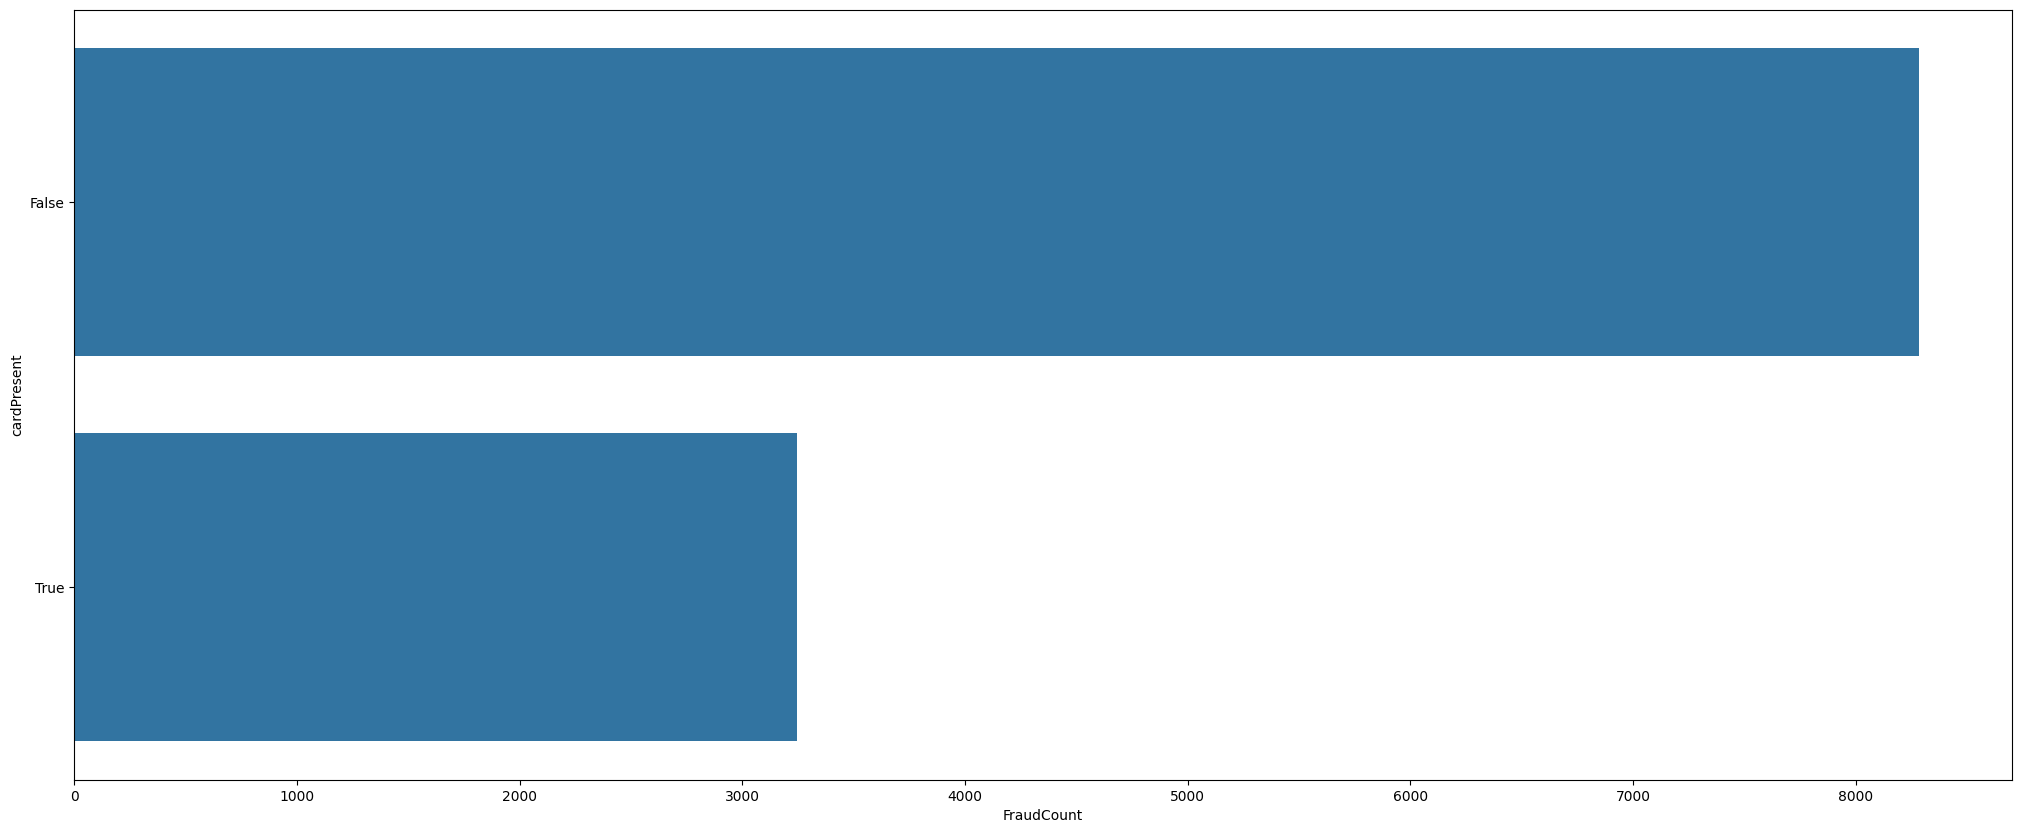

                      count  percentage
isFraud cardPresent                    
False   False        380591       97.87
        True         328537       99.02
True    False          8285        2.13
        True           3246        0.98


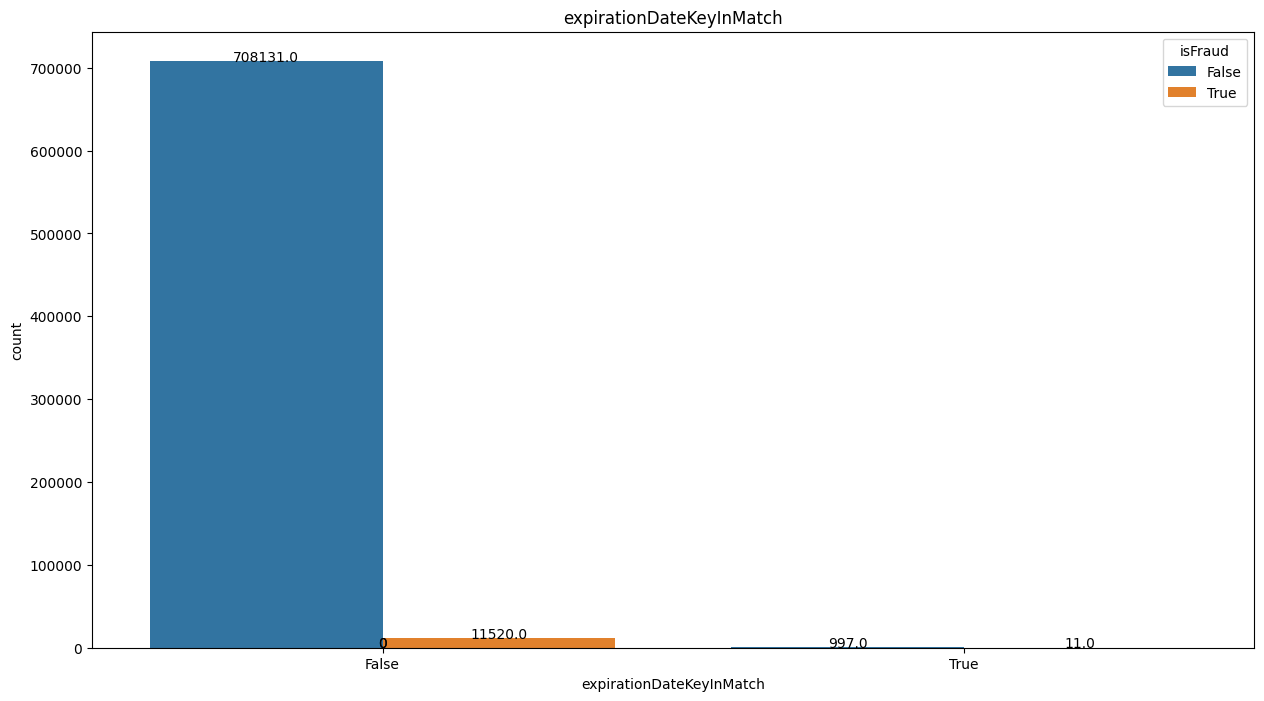

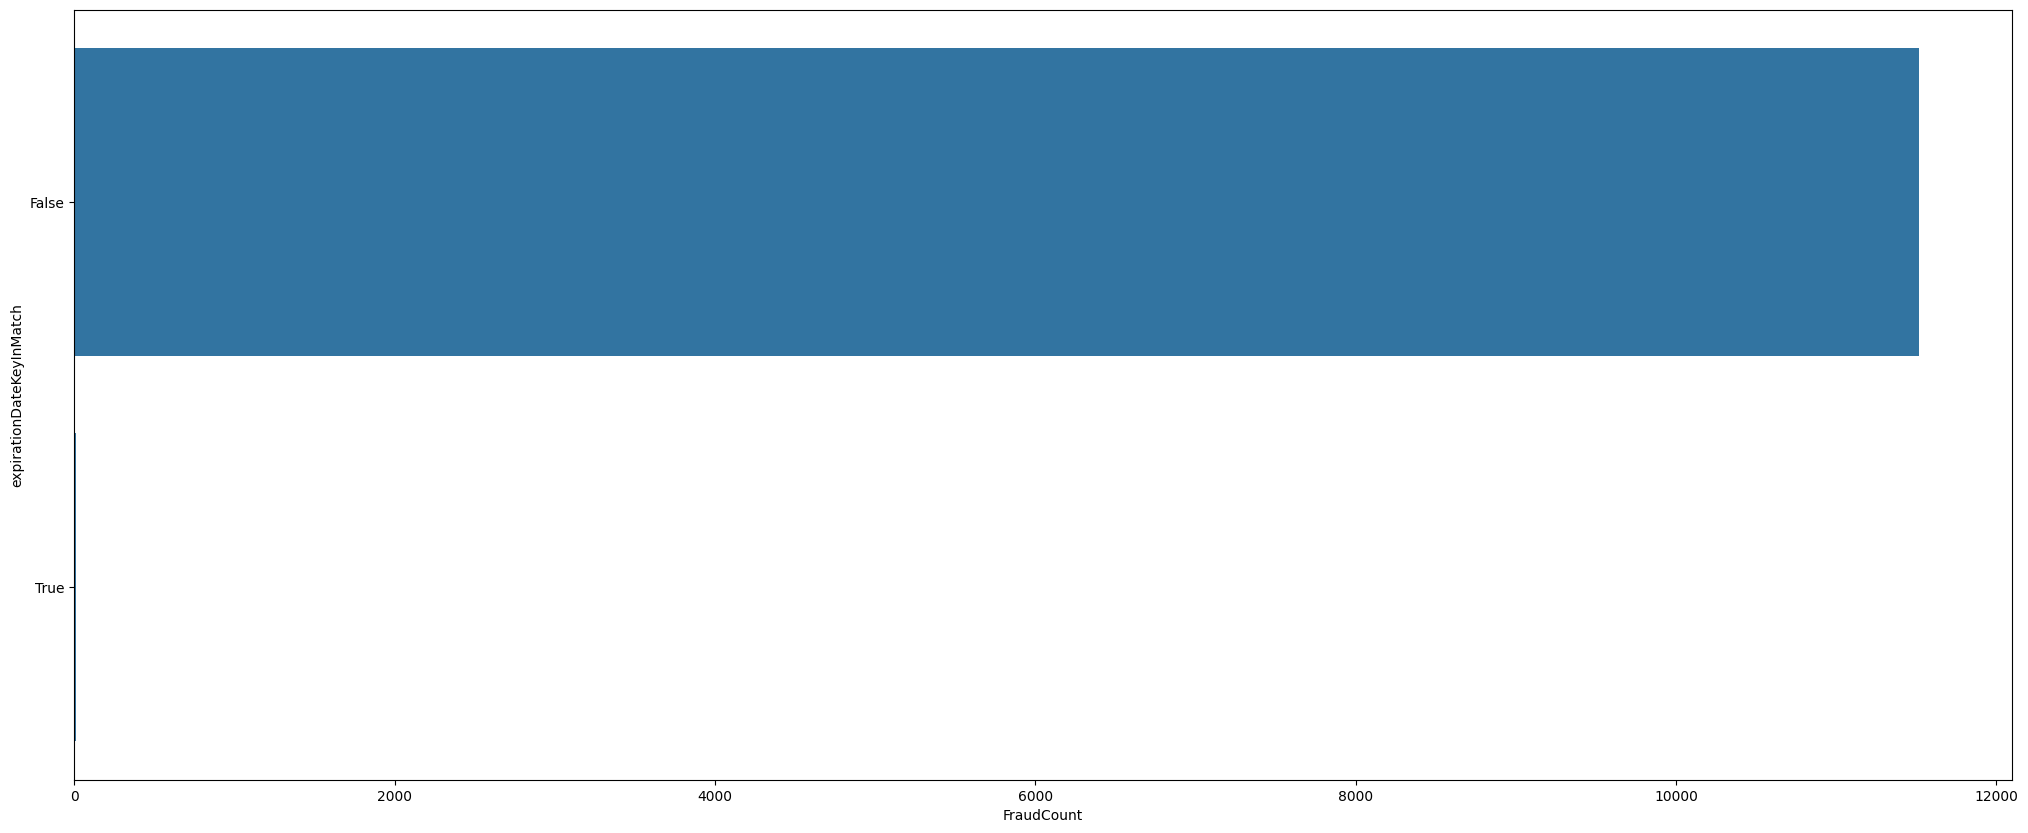

                                   count  percentage
isFraud expirationDateKeyInMatch                    
False   False                     708131       98.40
        True                         997       98.91
True    False                      11520        1.60
        True                          11        1.09


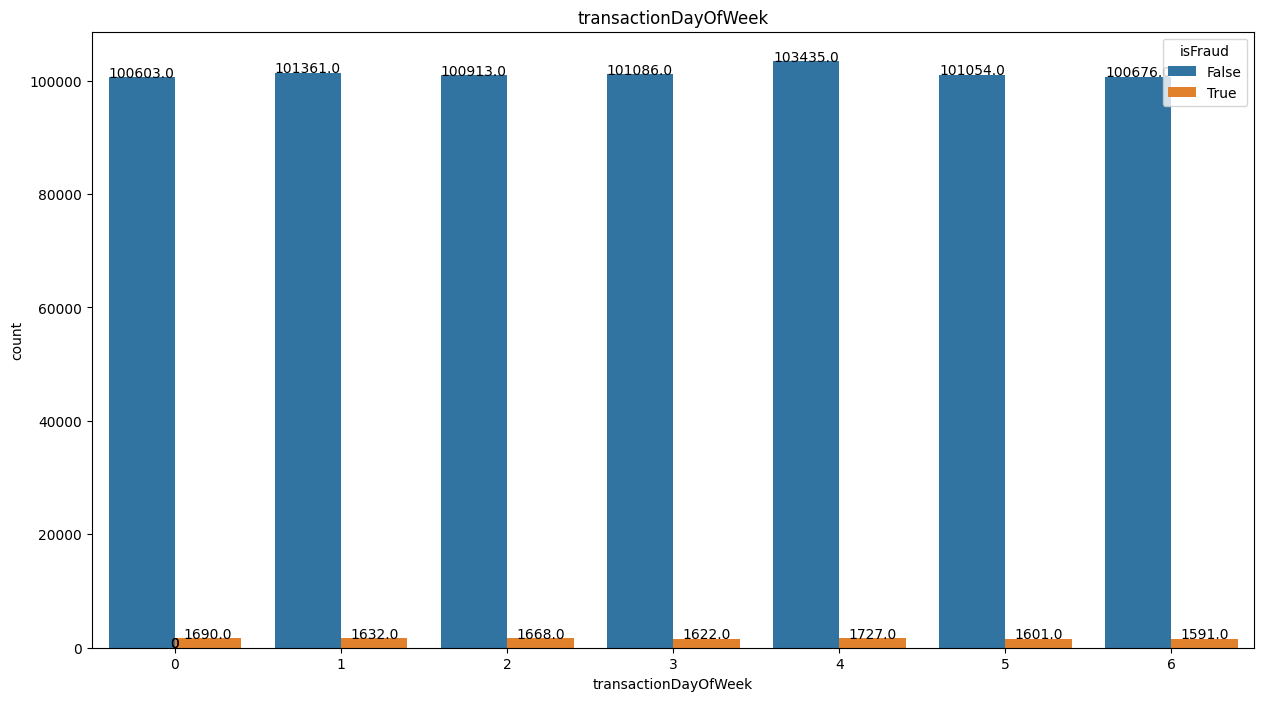

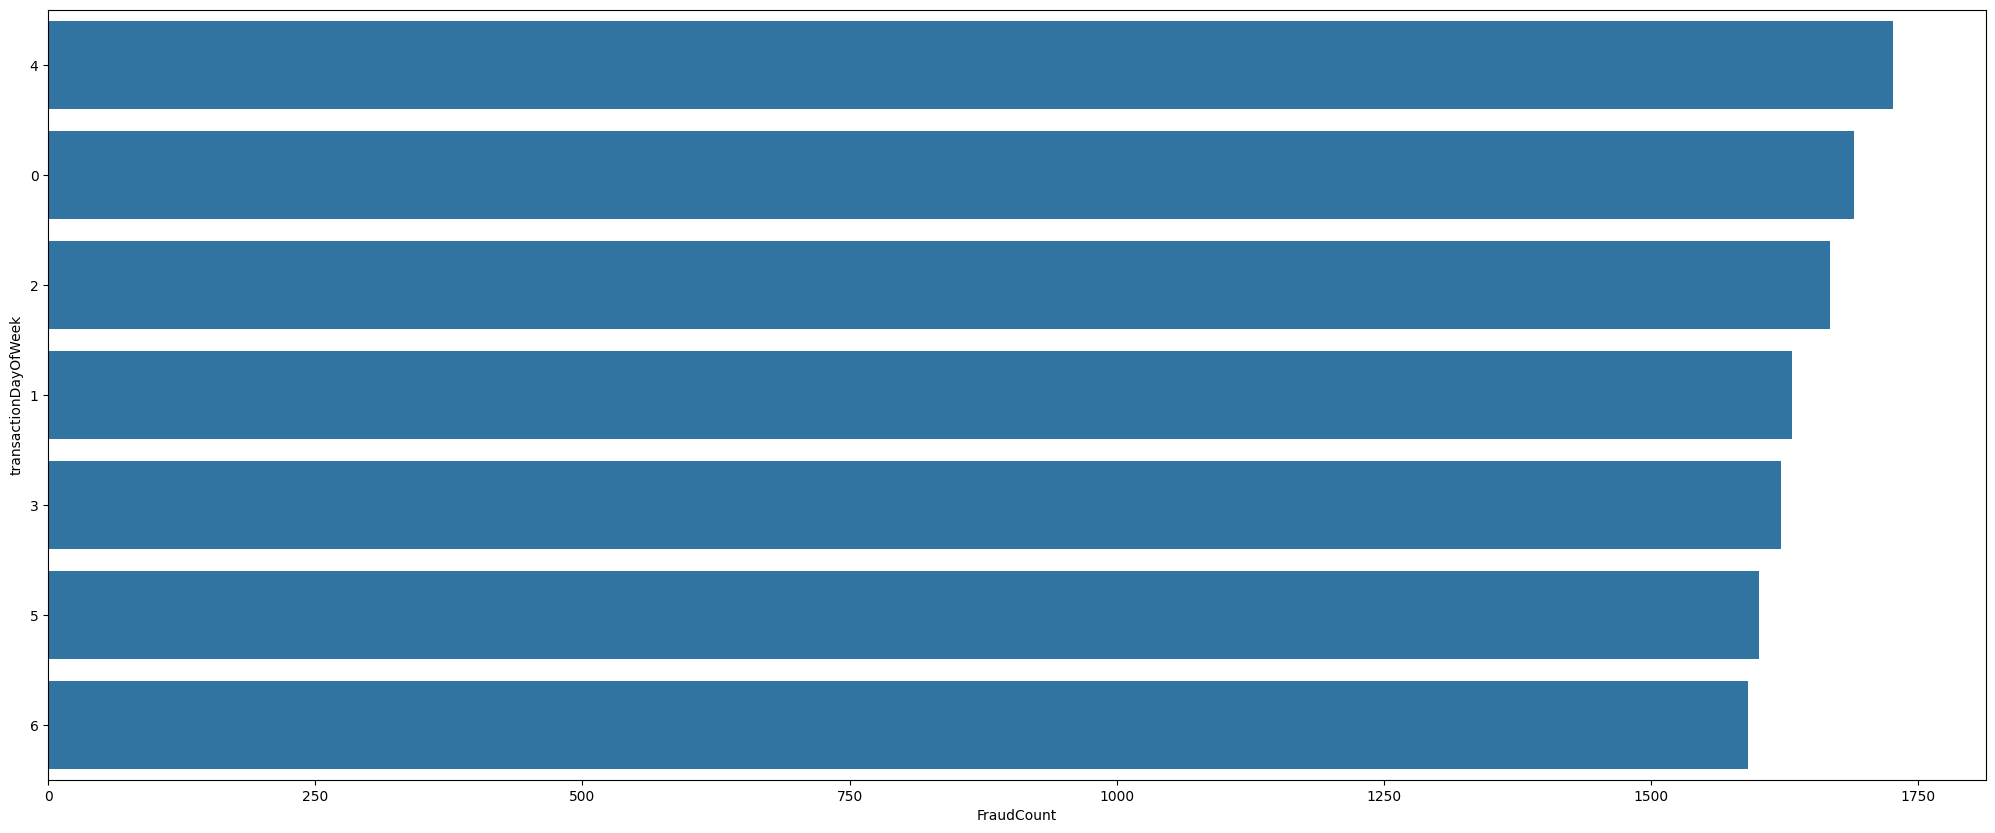

                               count  percentage
isFraud transactionDayOfWeek                    
False   0                     100603       98.35
        1                     101361       98.42
        2                     100913       98.37
        3                     101086       98.42
        4                     103435       98.36
        5                     101054       98.44
        6                     100676       98.44
True    0                       1690        1.65
        1                       1632        1.58
        2                       1668        1.63
        3                       1622        1.58
        4                       1727        1.64
        5                       1601        1.56
        6                       1591        1.56


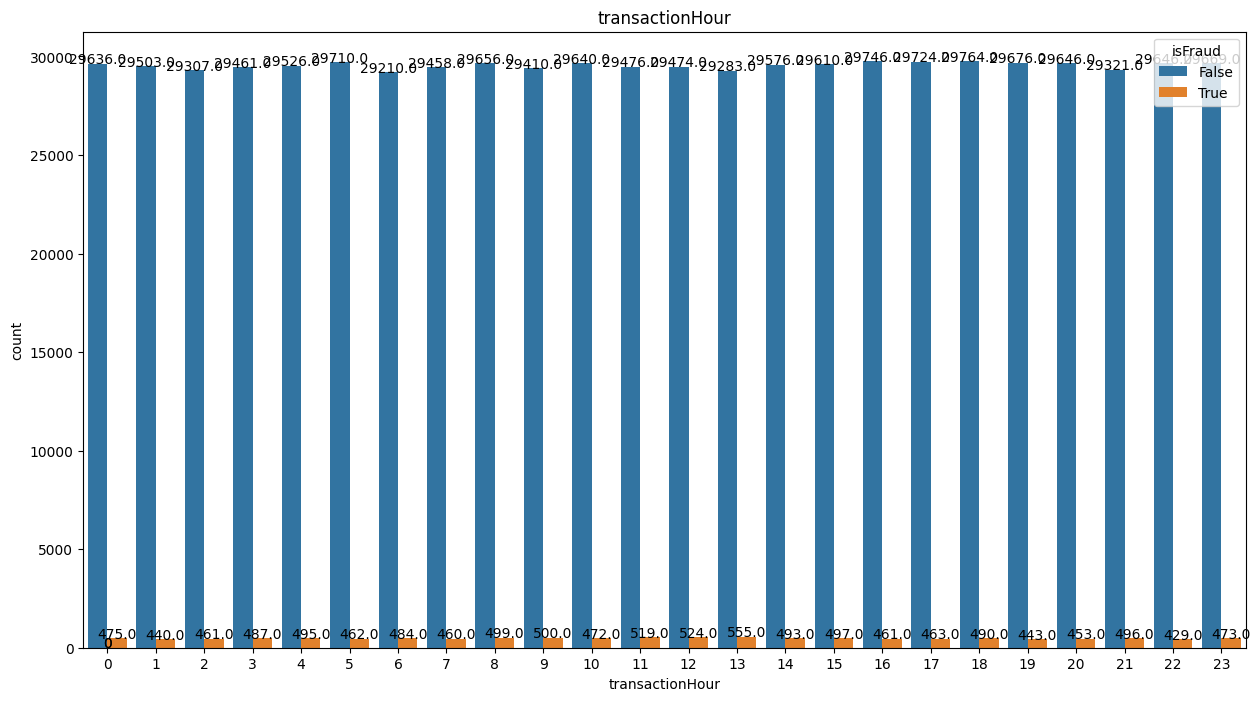

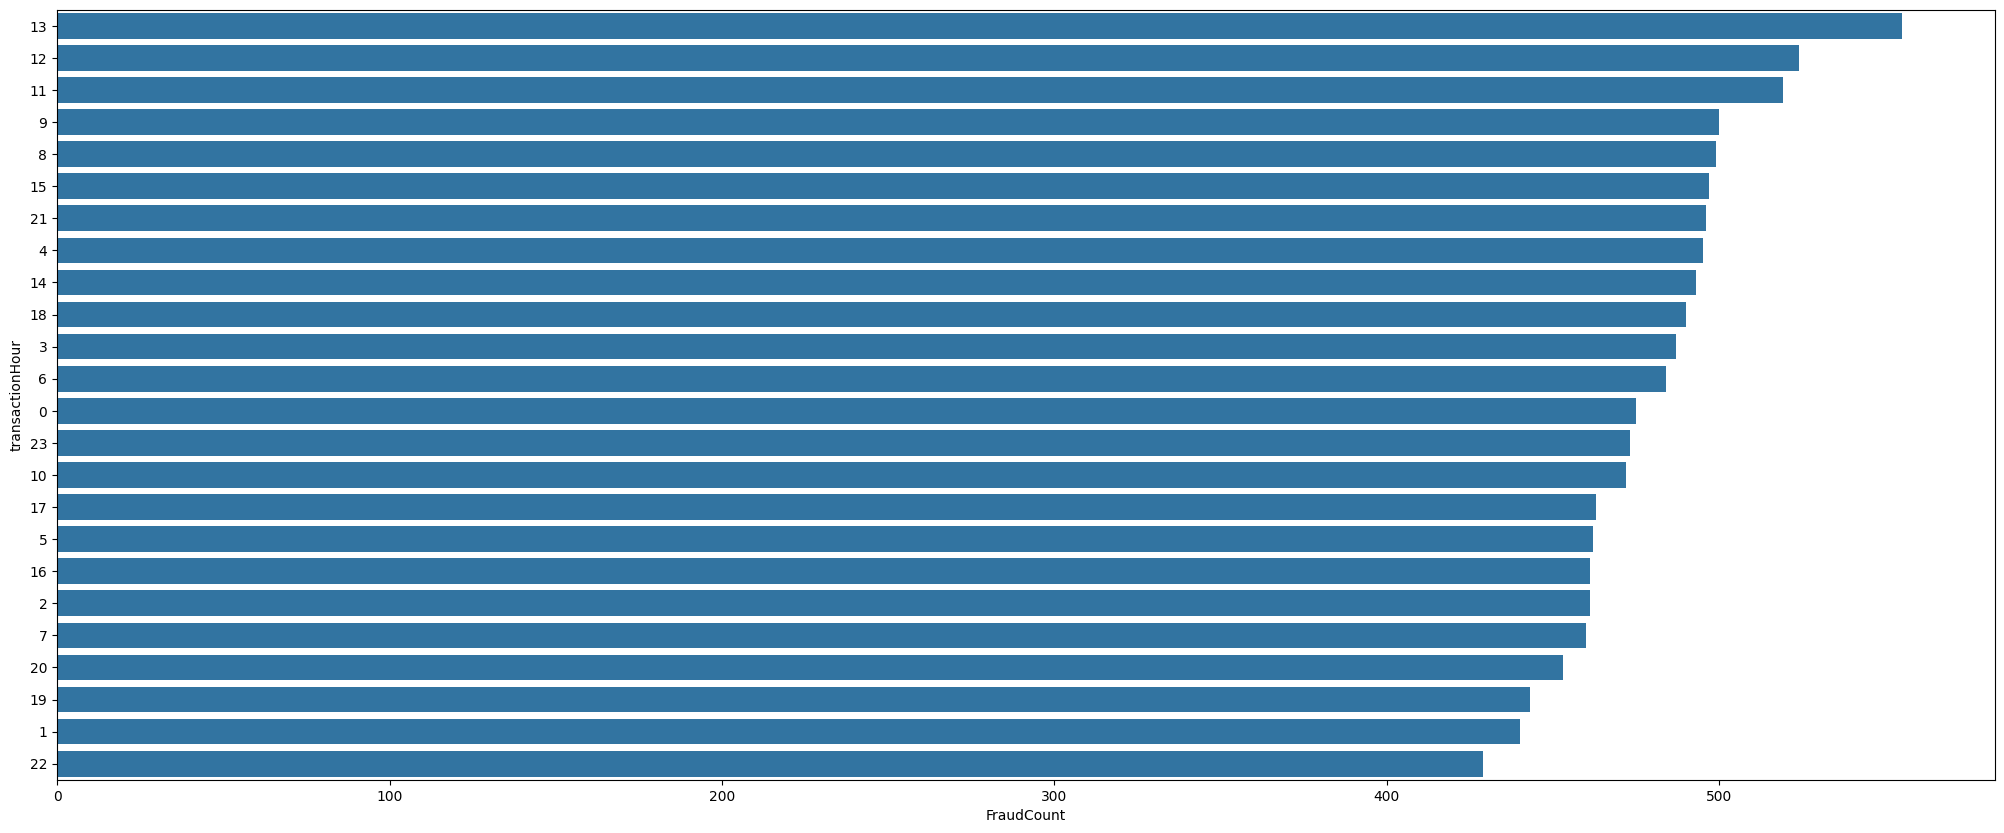

                         count  percentage
isFraud transactionHour                   
False   0                29636       98.42
        1                29503       98.53
        2                29307       98.45
        3                29461       98.37
        4                29526       98.35
        5                29710       98.47
        6                29210       98.37
        7                29458       98.46
        8                29656       98.35
        9                29410       98.33
        10               29640       98.43
        11               29476       98.27
        12               29474       98.25
        13               29283       98.14
        14               29576       98.36
        15               29610       98.35
        16               29746       98.47
        17               29724       98.47
        18               29764       98.38
        19               29676       98.53
        20               29646       98.49
        21 

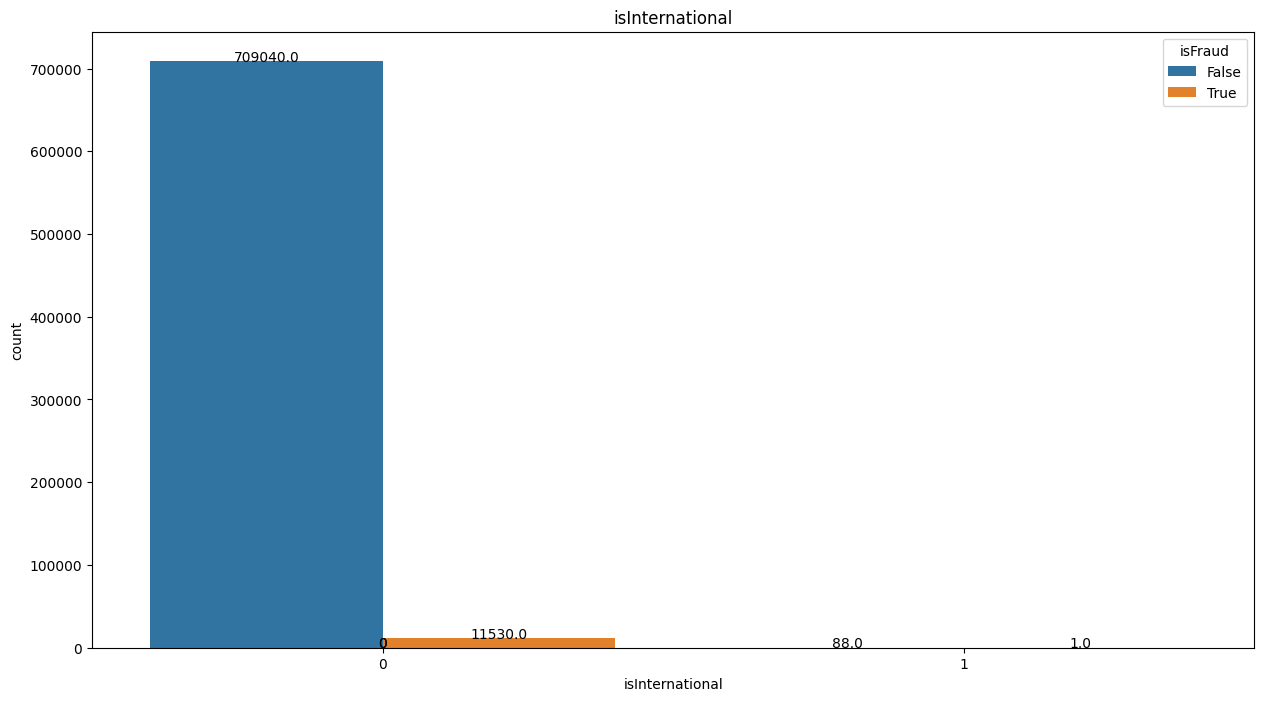

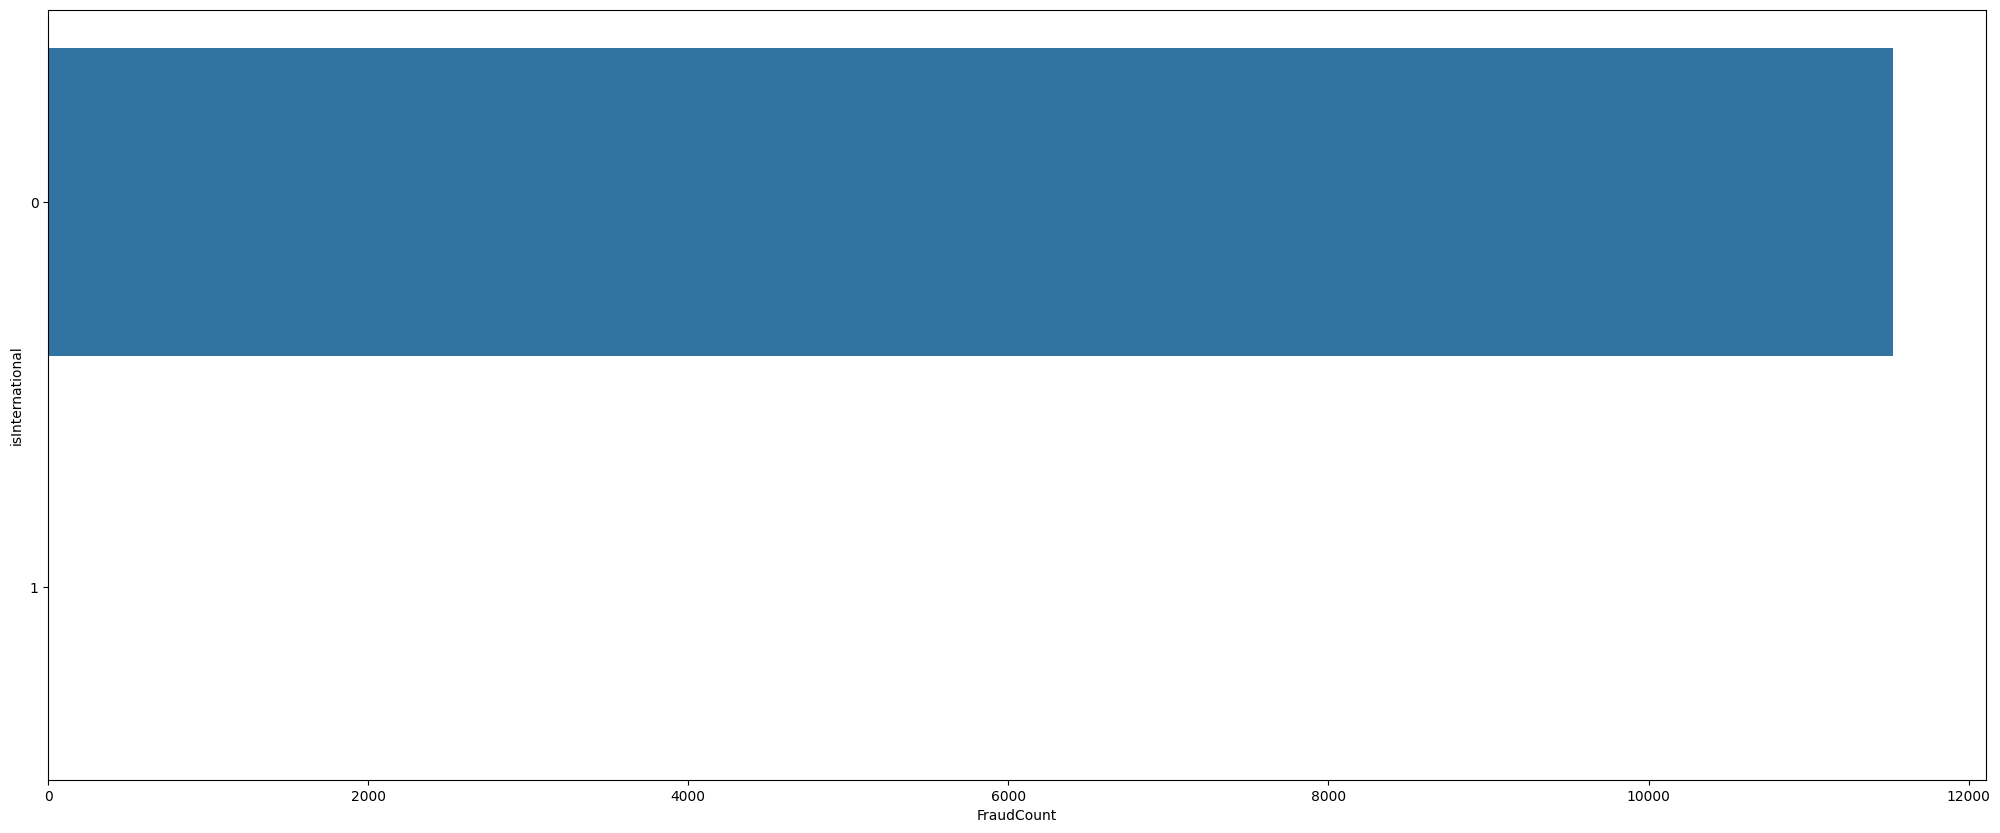

                          count  percentage
isFraud isInternational                    
False   0                709040       98.40
        1                    88       98.88
True    0                 11530        1.60
        1                     1        1.12


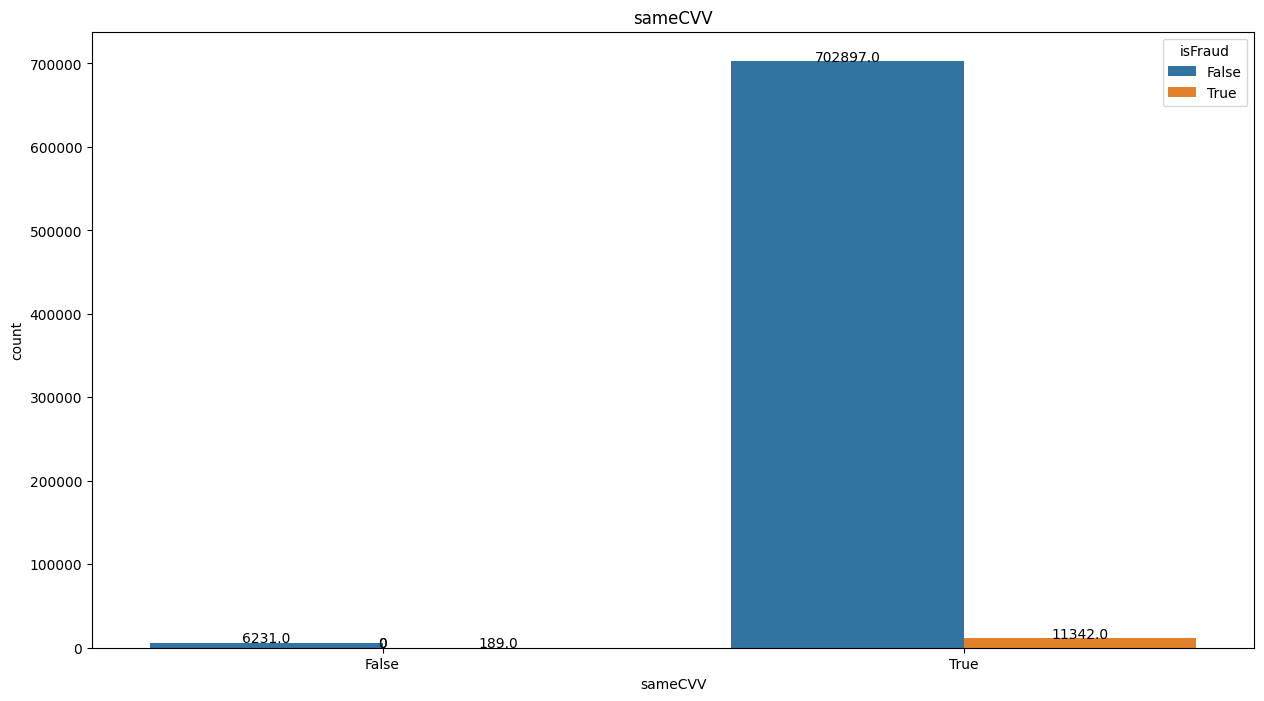

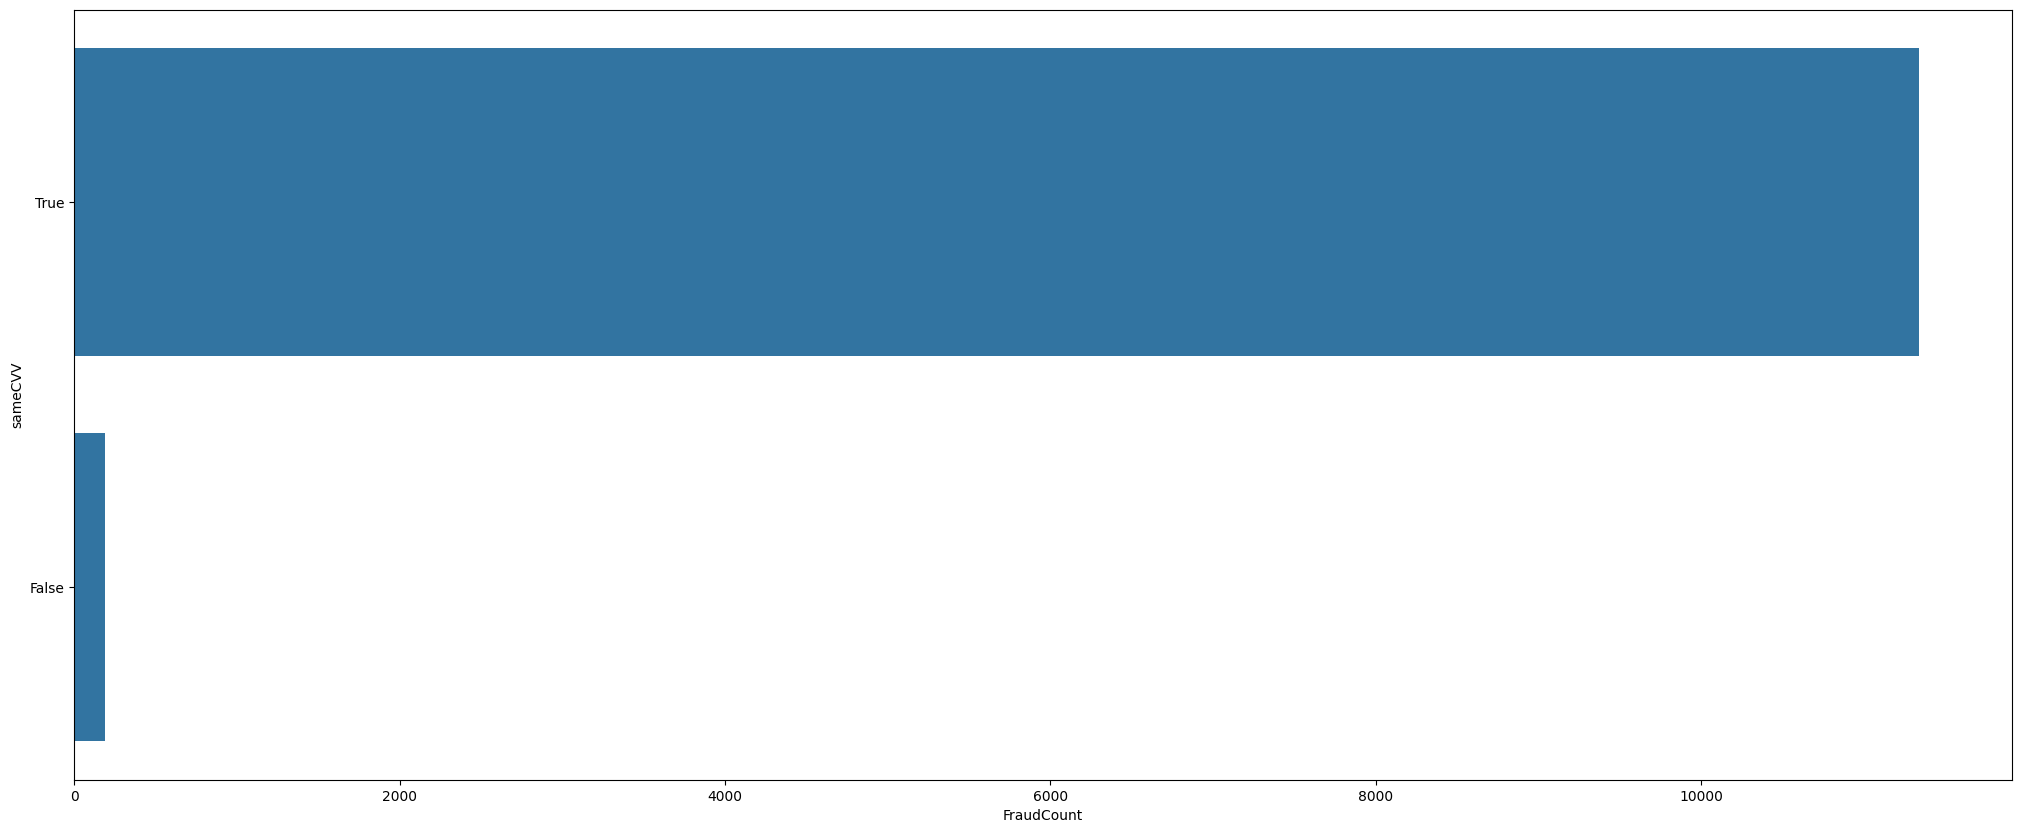

                  count  percentage
isFraud sameCVV                    
False   False      6231       97.06
        True     702897       98.41
True    False       189        2.94
        True      11342        1.59


In [54]:
col_to_show = ['acqCountry', 'merchantCategoryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'cardPresent', 'expirationDateKeyInMatch', 'transactionDayOfWeek', 'transactionHour', 'isInternational', 'sameCVV']
total = len(transactions)
fraud_transactions = transactions[transactions['isFraud'] == True]
for column in col_to_show:
    fraud_transactions[column] = fraud_transactions[column].astype('string')
    if column != 'isFraud' and column != 'accountNumber':
        plt.figure(figsize=(15, 8))
        sns.countplot(data = transactions, x = column, hue = 'isFraud').set_title(column)
        ax = plt.gca()

        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{height}', ha='center')

        plt.show()

        
        fraud_count_by_column = fraud_transactions.groupby(column).size().sort_values(ascending=False).reset_index(name='FraudCount')
        fraud_count_by_column_max = fraud_count_by_column[:35]
        plt.figure(figsize=(25,10))
        sns.barplot(data = fraud_count_by_column_max, y = column, x = "FraudCount")
        
        plt.show()

        # Group by 'isFraud' and 'column' and calculate count for each group
        count_grouped = transactions.groupby(['isFraud', column]).count()['accountNumber']

        # Group by 'column' and calculate count for each group
        total_count_grouped = transactions.groupby(column).count()['accountNumber']

        # Calculate percentage for each group
        percentage = round(count_grouped / total_count_grouped * 100, 2)

        # Concatenate count and percentage into a DataFrame
        result = pd.concat([count_grouped, percentage], axis=1)
        result.columns = ['count', 'percentage']

        print(result)


As we saw earlier the cardinality of the merchantName column is extremely high (2490 categories), most of which are store names with store number. Thus feature appears to be important as we see a high number of frauds coming from select few merchants. To reduce dimensionality, I will employ regex to remove these store numbers and employ a threshold to group non-important merchants together.

## Part 4J - Investigating High Frequency Fraud-ipacted Customers

In [55]:
# Regex to remove store numbers
transactions['merchantName'] = transactions['merchantName'].str.replace(r'#\d+', '', regex=True)
fraud_count = transactions['merchantName'][transactions['isFraud'] == True].value_counts()

print("Reduced to: ", fraud_count)

Reduced to:  merchantName
Lyft                  701
ebay.com              598
Fresh Flowers         520
Uber                  483
EZ Putt Putt          442
                     ... 
86th Massage            2
Marriott Hotels         2
Holiday Inn             2
Pottery Barn            2
williamssonoma.com      2
Name: count, Length: 173, dtype: int64


Let's investigate the customers with the most fraudulent cases

<Axes: xlabel='FraudCount', ylabel='customerId'>

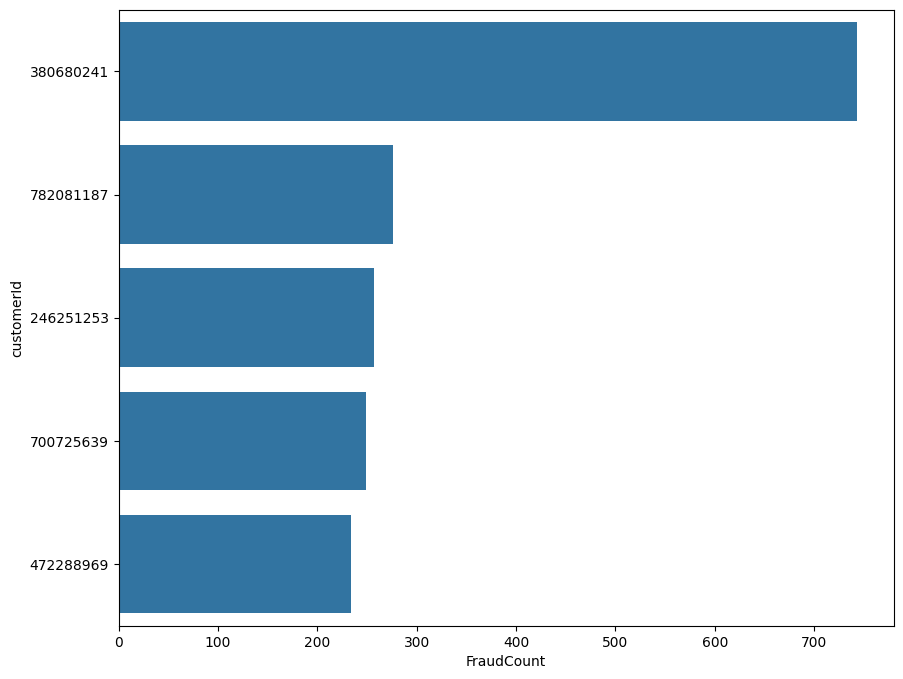

In [56]:
fraud_count_by_customerId = transactions[transactions['isFraud'] == True].groupby('customerId').size().sort_values(ascending=False).reset_index(name='FraudCount')
fraud_count_by_customerId_max = fraud_count_by_customerId[:5]
plt.figure(figsize=(10,8))
sns.barplot(data = fraud_count_by_customerId_max, y = 'customerId', x = "FraudCount")

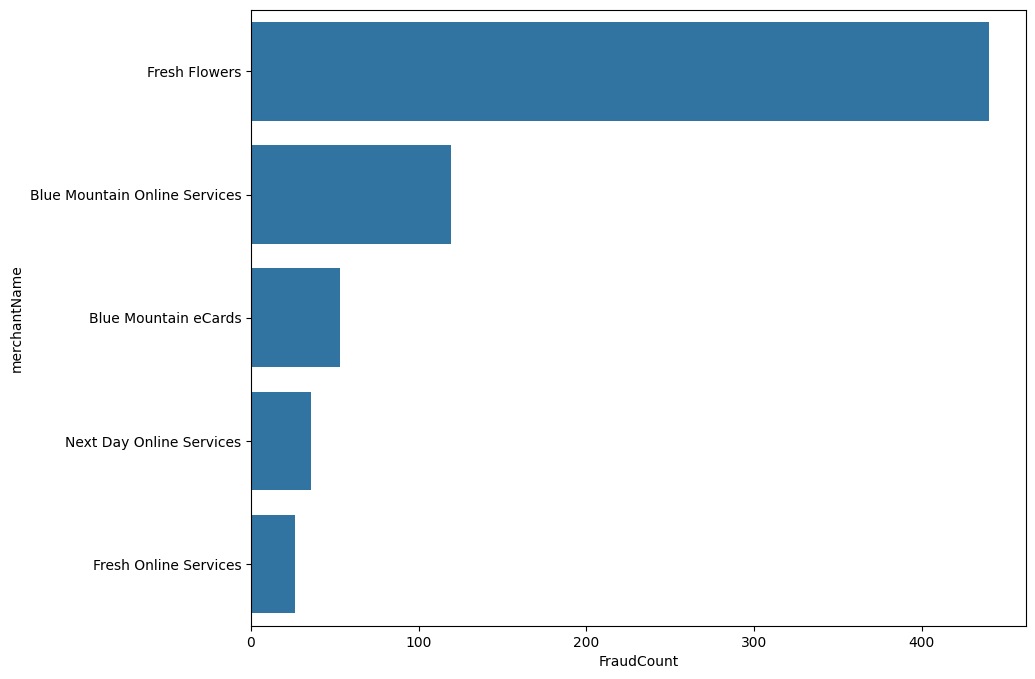

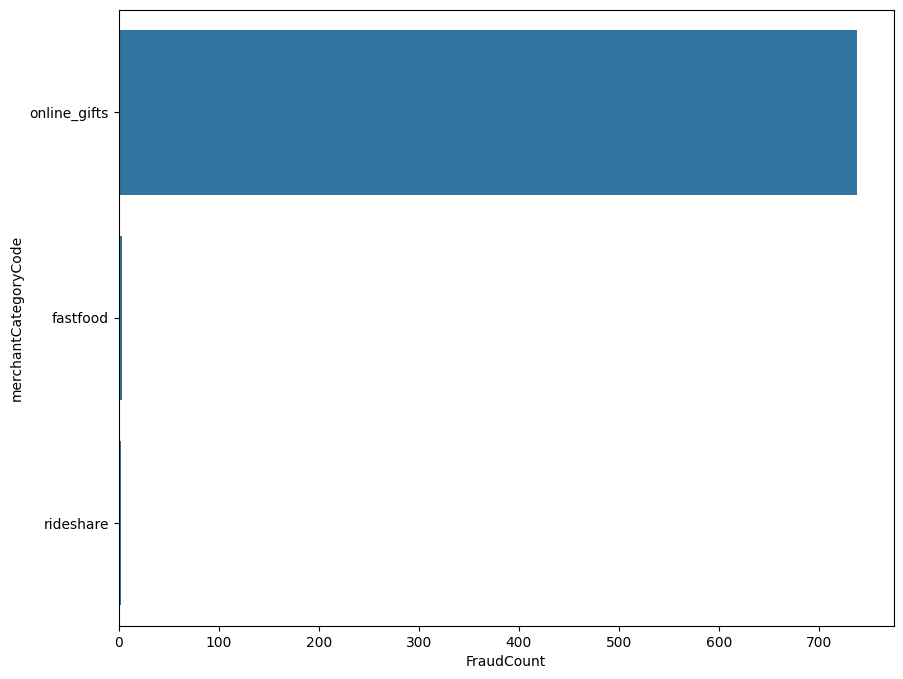

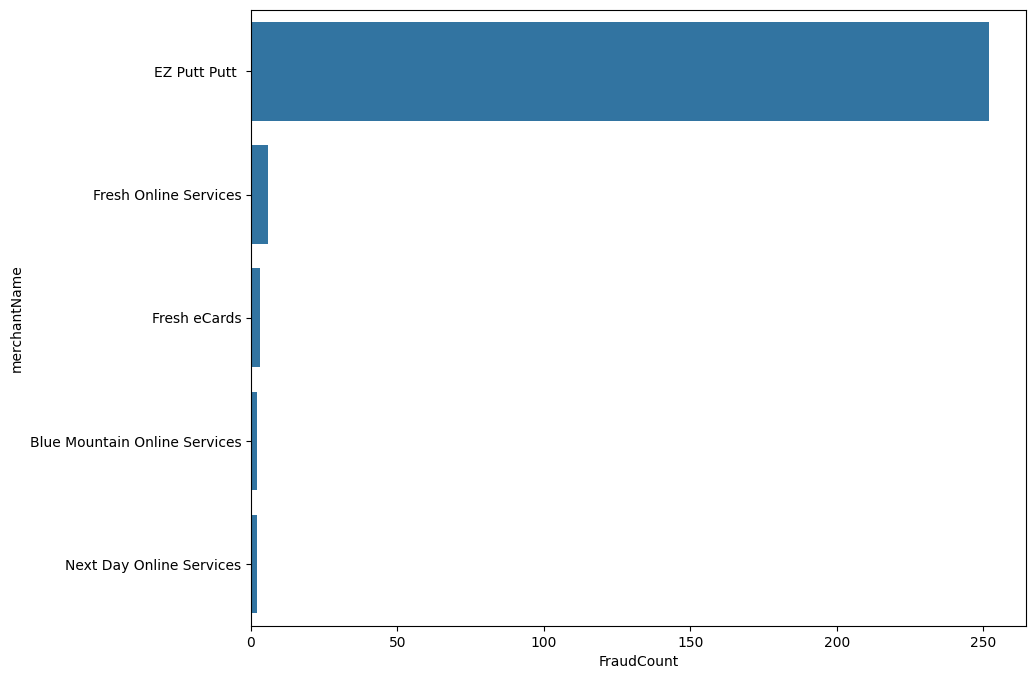

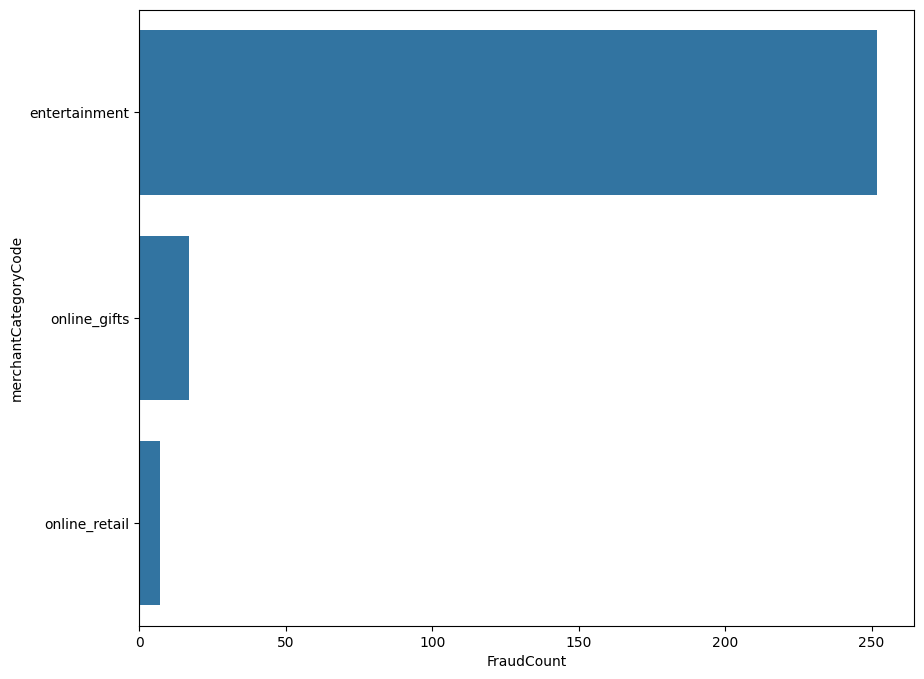

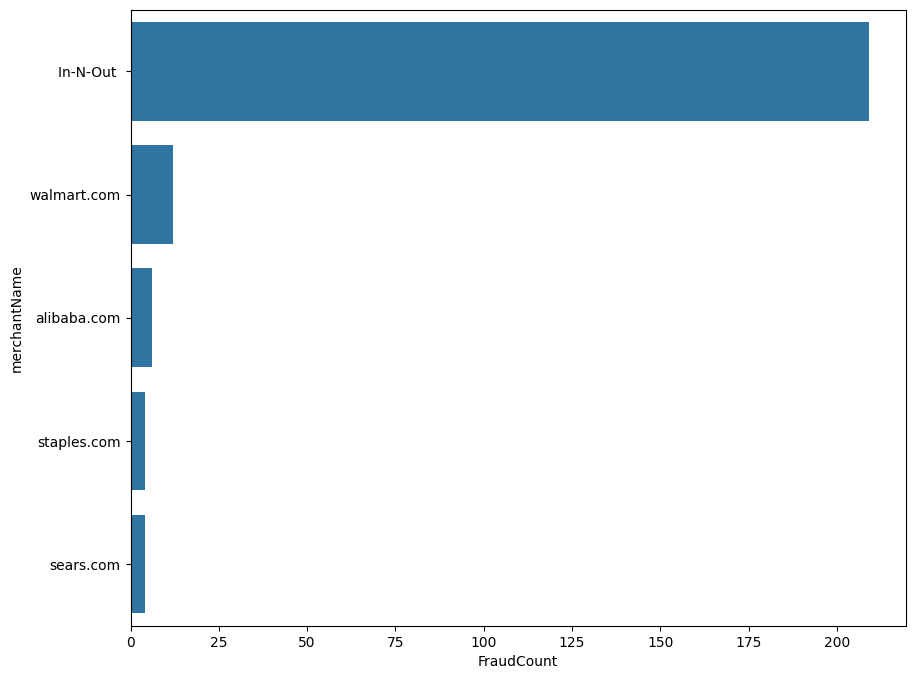

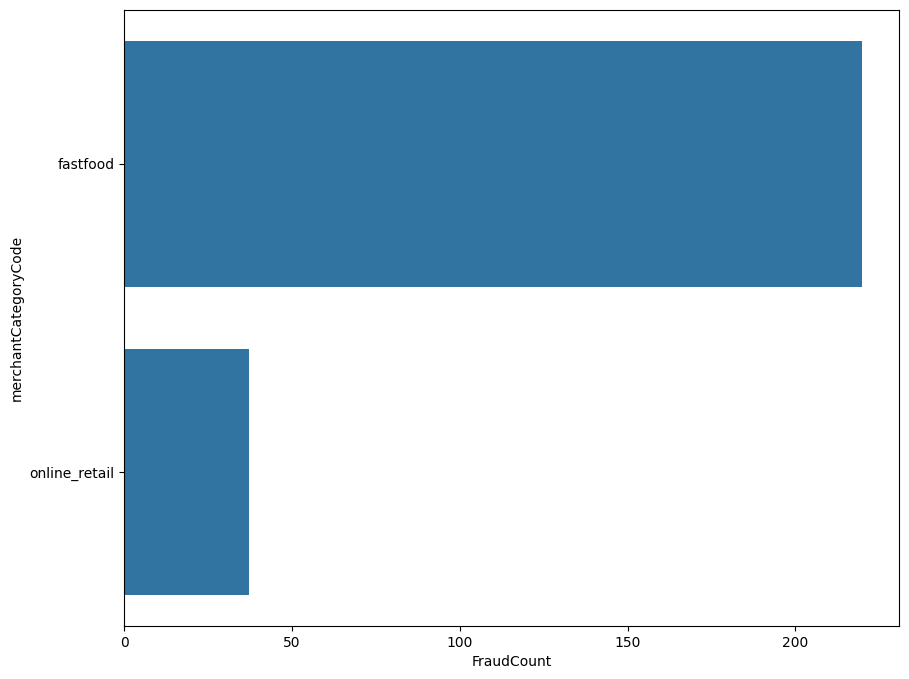

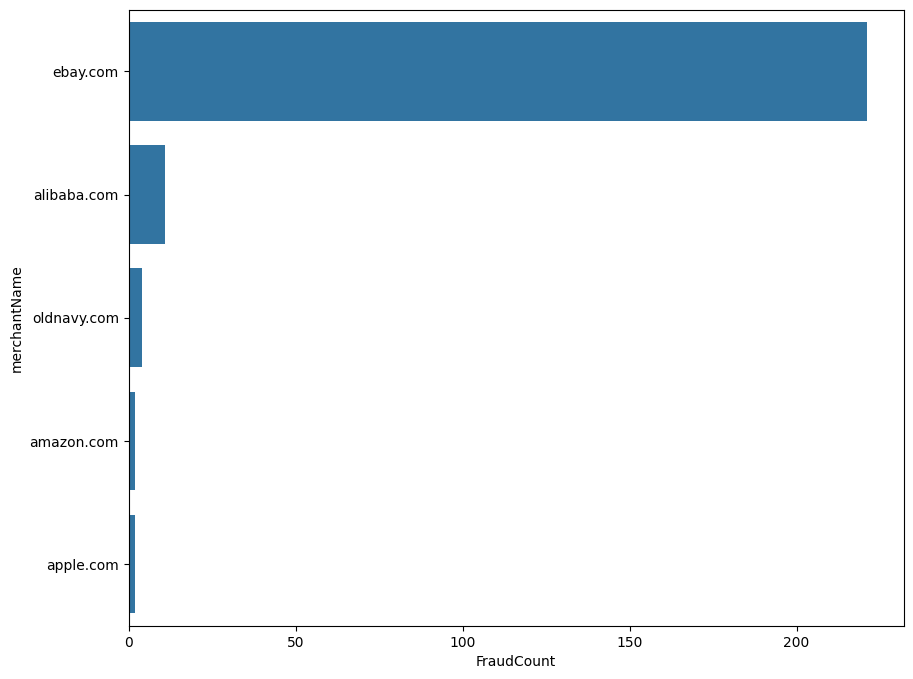

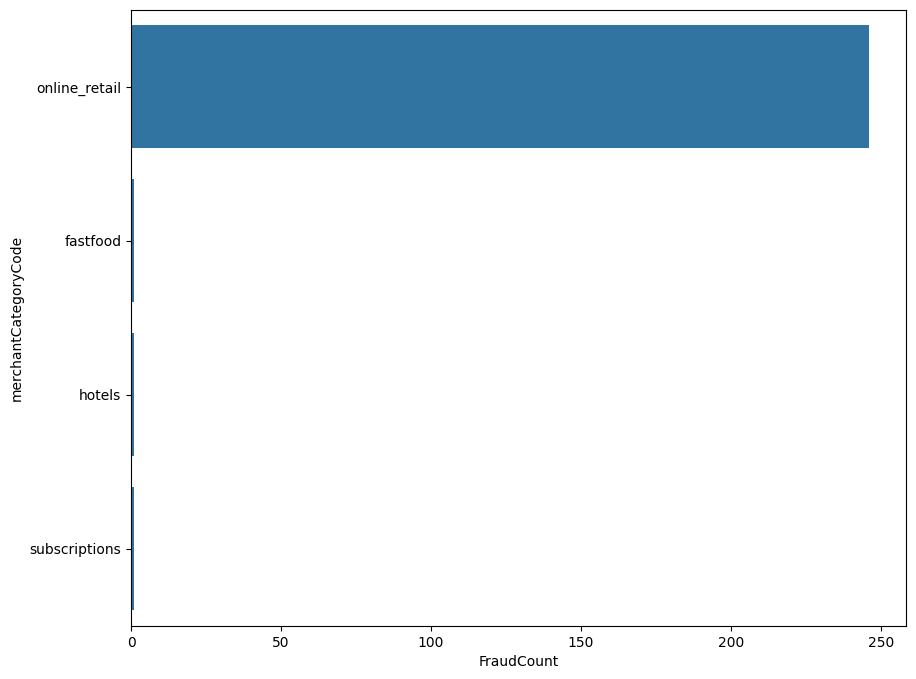

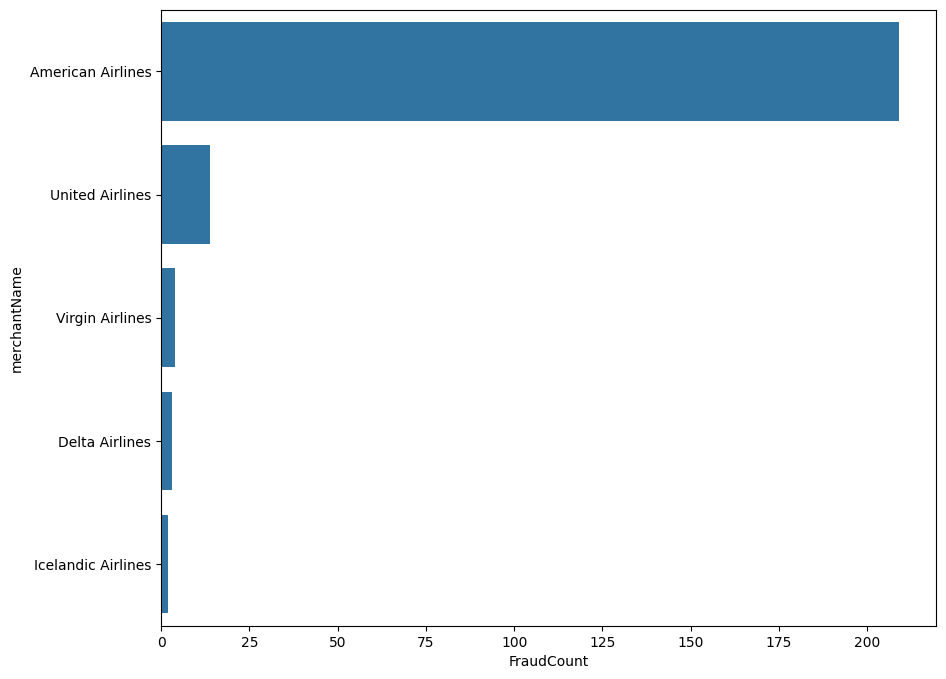

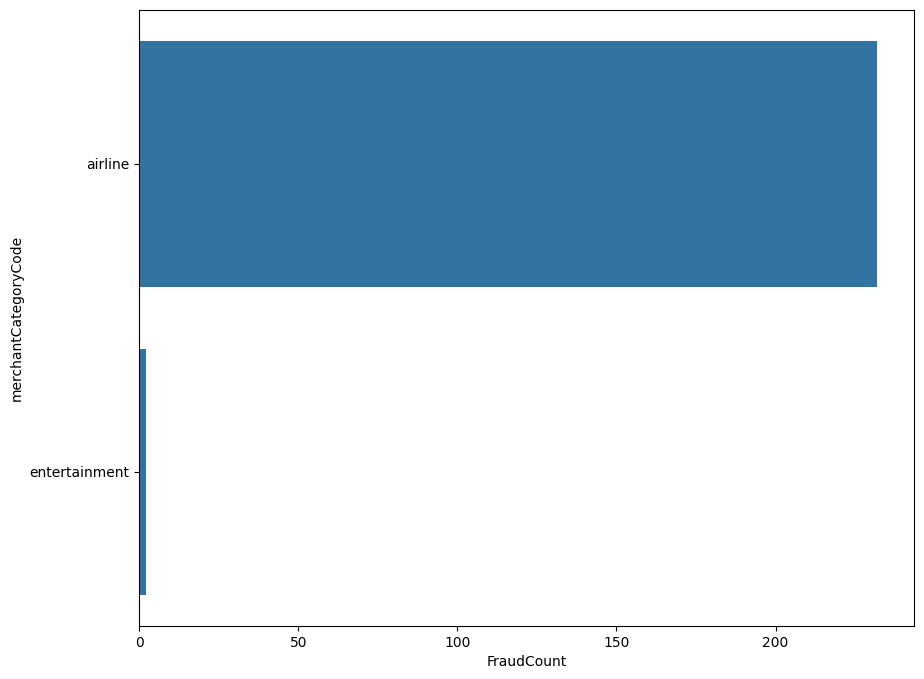

In [57]:
for index, row in fraud_count_by_customerId_max.iterrows():
    customerID = transactions[(transactions['isFraud'] == True) & (transactions['customerId'] == row['customerId'])]
    customerID_MN = customerID.groupby('merchantName').size().sort_values(ascending=False).reset_index(name='FraudCount')
    customerID_MN = customerID_MN[:5]
    plt.figure(figsize=(10,8))
    sns.barplot(data = customerID_MN, y = 'merchantName', x = "FraudCount")


    customerID_MC = customerID.groupby('merchantCategoryCode').size().sort_values(ascending=False).reset_index(name='FraudCount')
    customerID_MC = customerID_MC[:5]
    plt.figure(figsize=(10,8))
    sns.barplot(data = customerID_MC, y = 'merchantCategoryCode', x = "FraudCount")


The customers with the most fradulent cases appear to have been scammed in different way. It is hard to say if there is an inherent pattern between merchantcategorycode and merchantname on fradulent activity (Atleast in the most individuals with the most scam).

It is interesting that a customer was consistently scammed for in-n-out, maybe this customer is conducting fraud themselves by buying food and pretending that it is fraud.

## Part 4K - Final Preprocessing

We have done some data preprocessing earlier (missing value handling, column type adjustments, removing multiple and reversal transactions. However, with the new features from feature engineering and after analysis from EDA. We must clean the data abit more before applying the data to a machine learning model.

Data preprocessing and EDA is a dynamic and it is difficult to find ways pipeline this process more effectively

In [58]:
cleaned_transactions_df = transactions.copy()

In [59]:
cleaned_transactions_df

accountNumber customerId  creditLimit  availableMoney  \
0          737265056  737265056         5000         5000.00   
1          737265056  737265056         5000         5000.00   
2          737265056  737265056         5000         5000.00   
3          737265056  737265056         5000         5000.00   
4          830329091  830329091         5000         5000.00   
...              ...        ...          ...             ...   
786358     732852505  732852505        50000        48904.96   
786359     732852505  732852505        50000        48785.04   
786360     732852505  732852505        50000        48766.15   
786361     732852505  732852505        50000        48716.72   
786362     732852505  732852505        50000        48666.83   

       transactionDateTime  transactionAmount  merchantName acqCountry  \
0      2016-08-13 14:27:32              98.55          Uber         US   
1      2016-10-11 05:05:54              74.51          AMC          US   
2      2016-11-08 09:18:39               7.47    Play Store         US   
3      2016-12-10 02:14:50               7.47    Play Store         US   
4      2016-03-24 21:04:46              71.18  Tim Hortons          US   
...                    ...                ...           ...        ...   
786358 2016-12-22 18:44:12             119.92          Lyft         US   
786359 2016-12-25 16:20:34              18.89      hulu.com         US   
786360 2016-12-27 15:46:24              49.43          Lyft         US   
786361 2016-12-29 00:30:55              49.89   walmart.com         US   
786362 2016-12-30 20:10:29              72.18          Uber         US   

       merchantCountryCode posEntryMode posConditionCode  \
0                       US           02               01   
1                       US           09               01   
2                       US           09               01   
3                       US           09               01   
4                       US           02               01   
...                    ...          ...              ...   
786358                  US           90               01   
786359                  US           09               01   
786360                  US           02               01   
786361                  US           09               99   
786362                  US           05               01   

        merchantCategoryCode currentExpDate accountOpenDate  \
0                  rideshare     2023-06-01      2015-03-14   
1              entertainment     2024-02-01      2015-03-14   
2                 mobileapps     2025-08-01      2015-03-14   
3                 mobileapps     2025-08-01      2015-03-14   
4                   fastfood     2029-10-01      2015-08-06   
...                      ...            ...             ...   
786358             rideshare     2022-12-01      2012-08-23   
786359  online_subscriptions     2023-08-01      2012-08-23   
786360             rideshare     2025-08-01      2012-08-23   
786361         online_retail     2022-07-01      2012-08-23   
786362             rideshare     2024-05-01      2012-08-23   

       dateOfLastAddressChange cardCVV enteredCVV cardLast4Digits  \
0                   2015-03-14     414        414            1803   
1                   2015-03-14     486        486             767   
2                   2015-03-14     486        486             767   
3                   2015-03-14     486        486             767   
4                   2015-08-06     885        885            3143   
...                        ...     ...        ...             ...   
786358              2012-08-23     936        936            3783   
786359              2012-08-23     939        939            3388   
786360              2012-08-23     936        936            3783   
786361              2012-08-23     939        939            3388   
786362              2012-08-23     939        939            3388   

       transactionType  currentBalance  ca

In [60]:
try:
    cleaned_transactions_df.drop(['customerId', 'accountNumber','transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange','cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionDayOfWeek', 'acqCountry', 'merchantCountryCode', 'transactionType'], axis=1,inplace=True)
except:
    print("Error")

In [61]:
# Employing a 1% threshold to aggregate all rare merchants together
threshhold = len(cleaned_transactions_df[cleaned_transactions_df['isFraud'] == True]) * 0.01
rare_values = fraud_count[fraud_count < threshhold].index
cleaned_transactions_df['merchantName'] = cleaned_transactions_df['merchantName'].apply(lambda x: 'other' if x in rare_values else x)

As seen earlier in the histogram, the credit limit appears to be categorical despite it haivng a high correlation with several features. I decided to convert this into a categorical column using LabelEncoder since it is ordinal.

In [62]:
cleaned_transactions_df['creditLimit'] = cleaned_transactions_df['creditLimit'].astype('object')

label_encoder = LabelEncoder()

cleaned_transactions_df['creditLimit'] = label_encoder.fit_transform(cleaned_transactions_df['creditLimit'])

Since most of the provided categorical columns are non-ordinal categorical data, we must employ one-hot encoding to these categorical data. I have attempted to deduce the cardinality of the categorical columns by implementing thresholds and dropping the country-related columns. However, this approach will increase dimensionality. I will attempt to explore ways to reduce features with feature selection later on.

In [63]:
cleaned_transactions_df = pd.get_dummies(cleaned_transactions_df, columns=['merchantName','posEntryMode','posConditionCode','merchantCategoryCode'])

In [64]:
# Converting the boolean to 0 and 1 for our ML models
bool_col = cleaned_transactions_df.select_dtypes(include=['bool']).columns.tolist()
for col in bool_col:
    cleaned_transactions_df[col] = cleaned_transactions_df[col].astype(int)
cleaned_transactions_df

creditLimit  availableMoney  transactionAmount  currentBalance  \
0                 4         5000.00              98.55            0.00   
1                 4         5000.00              74.51            0.00   
2                 4         5000.00               7.47            0.00   
3                 4         5000.00               7.47            0.00   
4                 4         5000.00              71.18            0.00   
...             ...             ...                ...             ...   
786358            9        48904.96             119.92         1095.04   
786359            9        48785.04              18.89         1214.96   
786360            9        48766.15              49.43         1233.85   
786361            9        48716.72              49.89         1283.28   
786362            9        48666.83              72.18         1333.17   

        cardPresent  expirationDateKeyInMatch  isFraud  \
0                 0                         0        0   
1                 1                         0        0   
2                 0                         0        0   
3                 0                         0        0   
4                 1                         0        0   
...             ...                       ...      ...   
786358            0                         0        0   
786359            0                         0        0   
786360            0                         0        0   
786361            0                         0        0   
786362            0                         0        0   

        transactionDateTimeDiff  accountOpenDuration  \
0                           518                  292   
1                           577                  292   
2                           605                  292   
3                           637                  292   
4                           231                  147   
...                         ...                  ...   
786358                     1582                 1225   
786359                     1585                 1225   
786360                     1587                 1225   
786361                     1589                 1225   
786362                     1590                 1225   

        dateOfLastAddressChangeDiff  transactionHour  \
0                                 0               14   
1                                 0                5   
2                                 0                9   
3                                 0                2   
4                                 0               21   
...                             ...              ...   
786358                            0               18   
786359                            0               16   
786360                            0               15   
786361                            0                0   
786362                            0               20   

        transactionToCreditLimitRatio  avgTransactionAmountByCustomer  \
0                            0.019710                       47.000000   
1                            0.014902                       47.000000   
2                            0.001494                       47.000000   
3                            0.001494                       47.000000   
4                            0.014236                      107.255455   
...                               ...                             ...   
786358                       0.002398                      112.719245   
786359                       0.000378                      112.719245   
786360                       0.000989                      112.719245   
786361                       0.000998                      112.719245   
786362                       0.001444                      112.719245   

        creditUtilizationRatio  isInternational  sameCVV  transactionCount  \
0                     0.000000                0        1                 1   
1                     0.000000             

In [65]:
# Due to the skewed nature of these columns, I will employ log transformation. availableMoney has negative values and will not be appropiate for this endeavor

cleaned_transactions_df['transactionAmount'] = np.log(cleaned_transactions_df['transactionAmount'] + 1)
cleaned_transactions_df['currentBalance'] = np.log(cleaned_transactions_df['currentBalance'] + 1)

# Part 5 - Modeling

## Part 5A - Prepping the data for modeling

Since the data is severly imbalance, there are a few approachs I would like to examine to optimize the model predictability

1. Random Undersampling
    a. Test with balance
    b. Test with more majority class data
2. Random Oversampling
3. SMOTE
4. No Changes

We will split that data 30% testing data and 70% training data with stratification since the data is imbalanced.

The 30% test data will not be used in the training phase and will only be presented when the model is ready for evaluation. 

The goal of the modeling step is to find the model that has the best F1 score and recall. 

Although since the dataset is imbalance, we may prioritize recall over precision to maximize the identification of true fraudulent transactions and accept a certain level of false positives. Minimizing the risk of missing fraudulent activities can have significant financial and reputational consequences for the business and its customers.

After deciding on a sampling method, I will employ feature selection to reduce dimensionality of the dataset.

Followed by hyperparameter optimization and model evaluation

In [66]:
# Function to find the perofrmance measures of a model
# Note I included f0.5, f2, and f3 to emphasize the importance of weigh either recall or percision more heavily

def get_performance_measures(CM):
    # Rerformance measures are formulated based on the values contrived from the confusion matrix
    TP = CM[1][1]
    FP = CM[0][1]
    FN = CM[1][0]
    TN = CM[0][0]

    recall = TP / (TP + FN)
    percision = TP / (TP + FP)
    f1 = 3 * recall * percision / (2 * percision + recall)
    f_half = 1.25 * recall * percision / (0.25 * percision + recall)
    f2 = 5 * recall * percision / (4 * percision + recall)
    f3 = 10 * recall * percision / (9 * percision + recall)
    acc = (TP + TN) / (TP + FP + FN + TN)

    # Aggregate and return the performance measures
    performance_measures = {
        "acc": round(acc, 3),
        "recall": round(recall, 3),
        "percision": round(percision, 3),
        "f0.5": round(f_half, 3),
        "f1": round(f1, 3),
        "f2": round(f2, 3),
        'f3': round(f3, 3),
    }

    performance_measures = pd.DataFrame(performance_measures, index = ['measures'])
    return performance_measures

In [67]:
X = cleaned_transactions_df.drop('isFraud', axis=1)
y = cleaned_transactions_df['isFraud']

In [68]:
# Emmploy 70/30 split with stratify to keep the imbalance consistent in the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [69]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy = 1)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

rus_50 = RandomUnderSampler(random_state=42, sampling_strategy = 0.5)
X_rus_50, y_rus_50 = rus_50.fit_resample(X_train, y_train)

rus_25 = RandomUnderSampler(random_state=42, sampling_strategy = 0.25)
X_rus_25, y_rus_25 = rus_25.fit_resample(X_train, y_train)

In [70]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [71]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

## Part 5B - First Pass

To find the best sampling approach we'll quickly use XGB gradient booster, random forest, and logistic regression.

In [72]:
def eval_full(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    CM = confusion_matrix(y_test, pred)
    performance_measures = get_performance_measures(CM)

    sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.show()

    print(performance_measures)

def eval_smote(model):
    model.fit(X_smote, y_smote)
    pred = model.predict(X_test)
    CM = confusion_matrix(y_test, pred)
    performance_measures = get_performance_measures(CM)

    sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.show()

    print(performance_measures)

def eval_rus(model, X, y):
    model.fit(X, y)
    pred = model.predict(X_test)
    CM = confusion_matrix(y_test, pred)
    performance_measures = get_performance_measures(CM)

    sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.show()

    print(performance_measures)

def eval_ros(model):
    model.fit(X_ros, y_ros)
    pred = model.predict(X_test)
    CM = confusion_matrix(y_test, pred)
    performance_measures = get_performance_measures(CM)

    sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.show()

    print(performance_measures)

_____________________________________________________________________________
Under Sampling (1 Minority : 1 Majority)


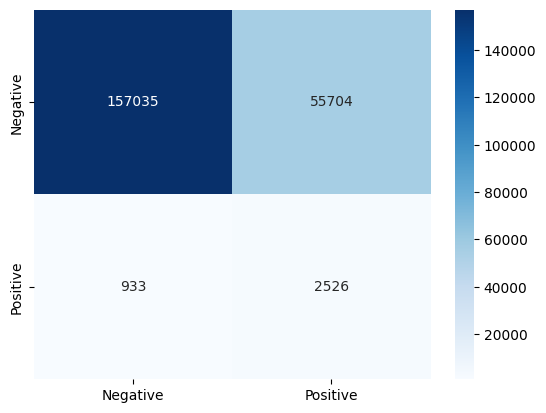

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.738    0.73      0.043  0.053  0.116  0.175  0.283
_____________________________________________________________________________
Under Sampling (1 Minority : 2 Majority)


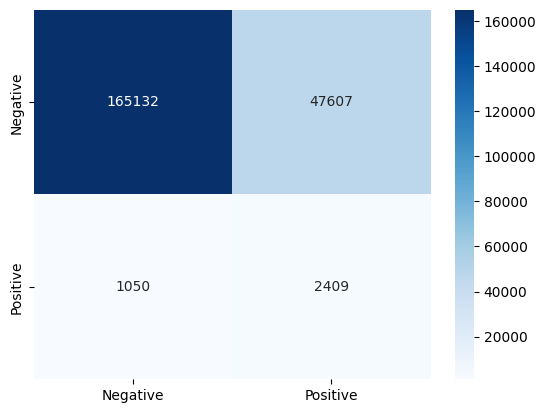

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.775   0.696      0.048  0.059  0.127  0.189  0.297
_____________________________________________________________________________
Under Sampling (1 Minority : 3 Majority)


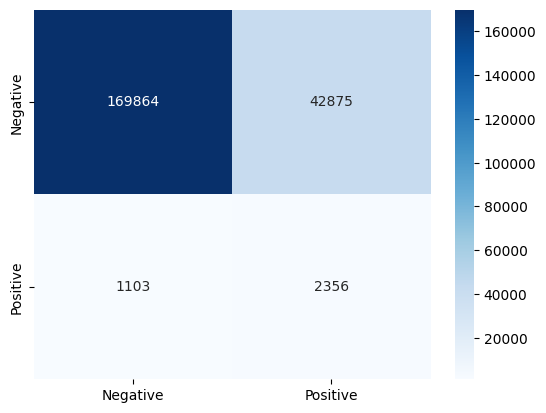

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.797   0.681      0.052  0.064  0.136  0.199  0.309
_____________________________________________________________________________
Over Sampling 


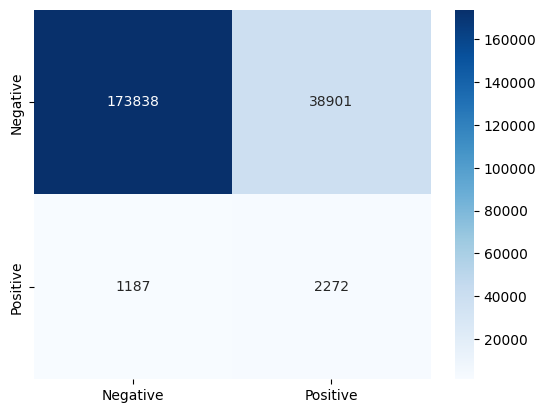

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.815   0.657      0.055  0.068  0.142  0.207  0.314
_____________________________________________________________________________
SMOTE


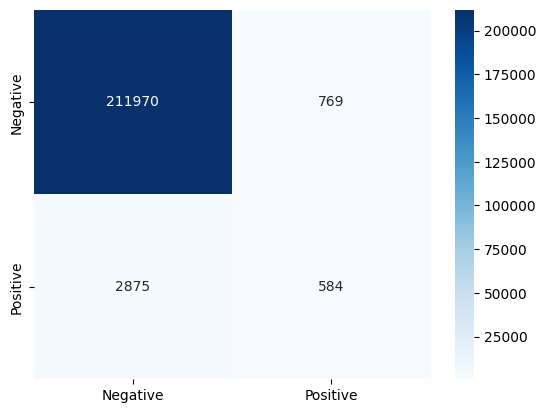

            acc  recall  percision   f0.5     f1     f2    f3
measures  0.983   0.169      0.432  0.329  0.212  0.192  0.18
_____________________________________________________________________________
Imbalanced with class weighing


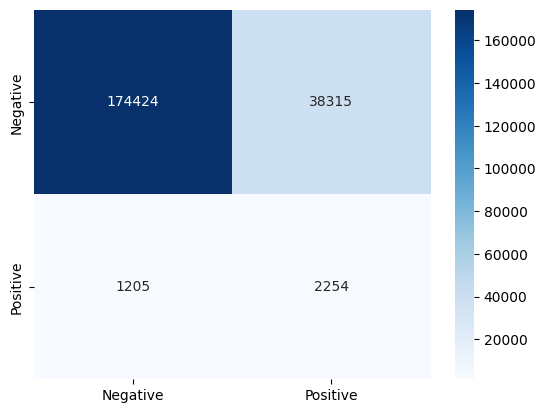

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.817   0.652      0.056  0.068  0.142  0.207  0.314
_____________________________________________________________________________
Imbalanced


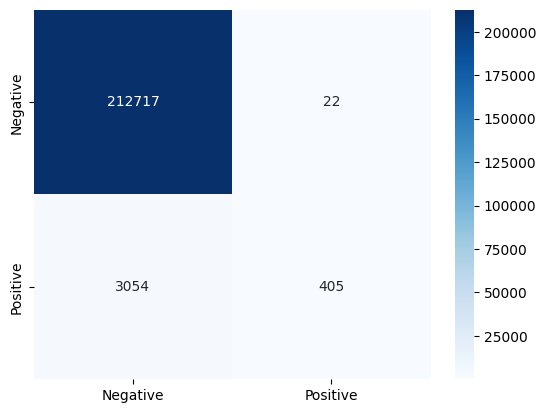

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.986   0.117      0.948  0.392  0.165  0.142  0.128


In [73]:
print("_____________________________________________________________________________")
print("Under Sampling (1 Minority : 1 Majority)")
eval_rus(xgb.XGBClassifier(device="cuda", scale_pos_weight = 1), X_rus, y_rus)

print("_____________________________________________________________________________")
print("Under Sampling (1 Minority : 2 Majority)")
eval_rus(xgb.XGBClassifier(device="cuda", scale_pos_weight = 2), X_rus_50, y_rus_50)

print("_____________________________________________________________________________")
print("Under Sampling (1 Minority : 3 Majority)")
eval_rus(xgb.XGBClassifier(device="cuda", scale_pos_weight = 4), X_rus_25, y_rus_25)

print("_____________________________________________________________________________")
print("Over Sampling ")
eval_ros(xgb.XGBClassifier(device="cuda", scale_pos_weight = 1))

print("_____________________________________________________________________________")
print("SMOTE")
eval_smote(xgb.XGBClassifier(device="cuda", scale_pos_weight = 1))

print("_____________________________________________________________________________")
print("Imbalanced with class weighing")
eval_full(xgb.XGBClassifier(device="cuda", scale_pos_weight = 61.5))

print("_____________________________________________________________________________")
print("Imbalanced")
eval_full(xgb.XGBClassifier(device="cuda", scale_pos_weight = 1))


After a single pass, we see that the balanced undersampled data yields the best recall (73%), which is ideal if we priortize the prediction of fraudulent transactions. F1, F2, and F3 score are slightly lower than the Over Sampling approach.

The data with no alteration has the highest percision, which is expected since a majority of the data is nonfraudulent data. The fraudulent data is basically drowned out. Hence, it will not be a good model.

The SMOTE model, has the highest f1 score, which would be worth investigating but the similar to the data with no alteration, the model basically predicts everything as nonfraudulent. 

_____________________________________________________________________________
Under Sampling (1 Minority : 1 Majority)


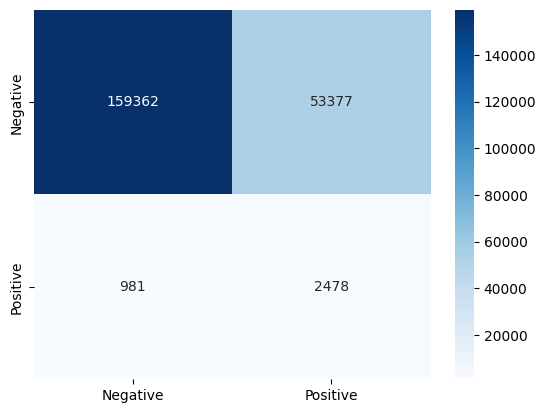

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.749   0.716      0.044  0.055  0.118  0.178  0.285
_____________________________________________________________________________
Under Sampling (1 Minority : 2 Majority)


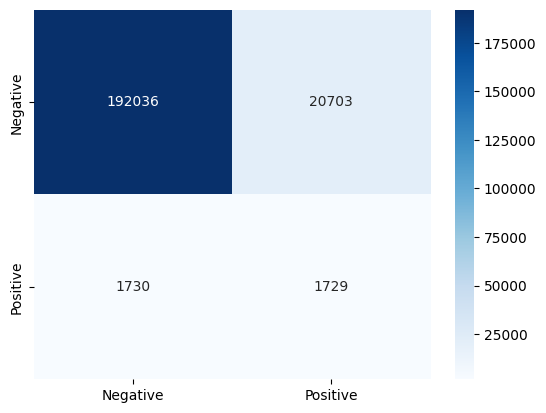

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.896     0.5      0.077  0.093  0.177  0.238  0.323
_____________________________________________________________________________
Under Sampling (1 Minority : 2 Majority)


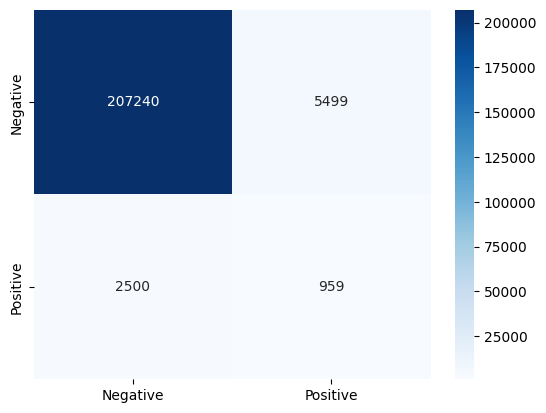

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.963   0.277      0.148  0.164  0.215  0.236  0.255
_____________________________________________________________________________
Over Sampling 


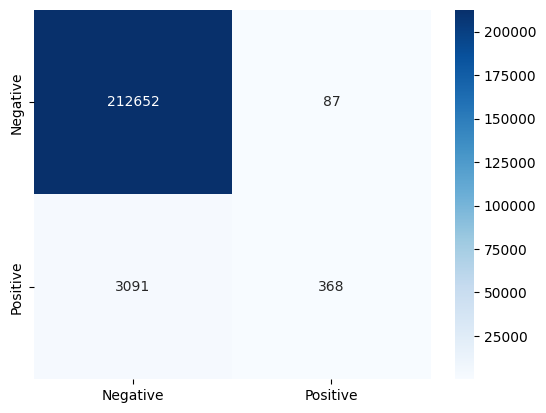

            acc  recall  percision   f0.5    f1     f2     f3
measures  0.985   0.106      0.809  0.349  0.15  0.129  0.117
_____________________________________________________________________________
SMOTE


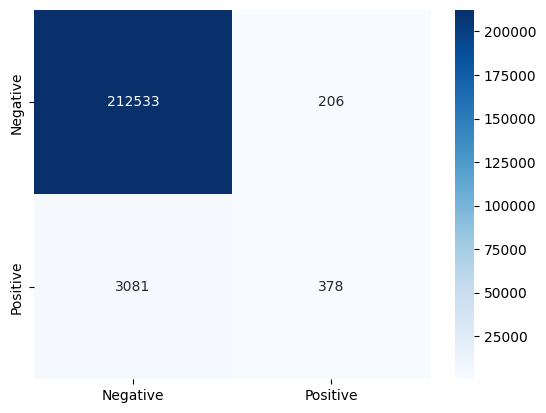

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.985   0.109      0.647  0.326  0.151  0.131  0.119
_____________________________________________________________________________
Imbalanced with class weighing


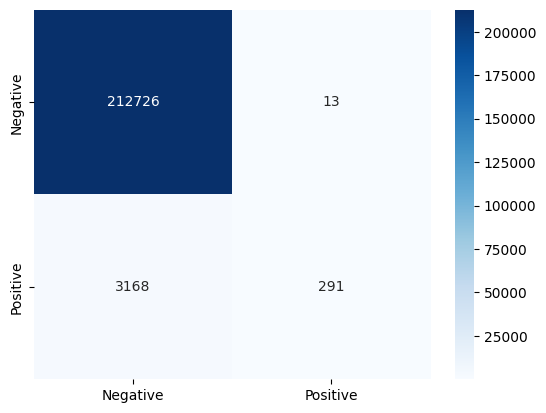

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.985   0.084      0.957  0.311  0.121  0.103  0.093
_____________________________________________________________________________
Imbalanced


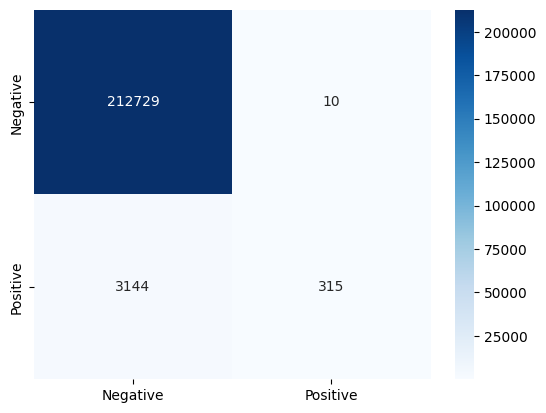

            acc  recall  percision   f0.5    f1     f2   f3
measures  0.985   0.091      0.969  0.331  0.13  0.111  0.1


In [74]:
print("_____________________________________________________________________________")
print("Under Sampling (1 Minority : 1 Majority)")
eval_rus(RandomForestClassifier(class_weight='balanced'), X_rus, y_rus)

print("_____________________________________________________________________________")
print("Under Sampling (1 Minority : 2 Majority)")
eval_rus(RandomForestClassifier(class_weight='balanced'), X_rus_50, y_rus_50)

print("_____________________________________________________________________________")
print("Under Sampling (1 Minority : 2 Majority)")
eval_rus(RandomForestClassifier(class_weight='balanced'), X_rus_25, y_rus_25)

print("_____________________________________________________________________________")
print("Over Sampling ")
eval_ros(RandomForestClassifier(class_weight='balanced'))

print("_____________________________________________________________________________")
print("SMOTE")
eval_smote(RandomForestClassifier(class_weight='balanced'))

print("_____________________________________________________________________________")
print("Imbalanced with class weighing")
eval_full(RandomForestClassifier(class_weight='balanced'))

print("_____________________________________________________________________________")
print("Imbalanced")
eval_full(RandomForestClassifier())

_____________________________________________________________________________
Under Sampling (1 Minority : 1 Majority)


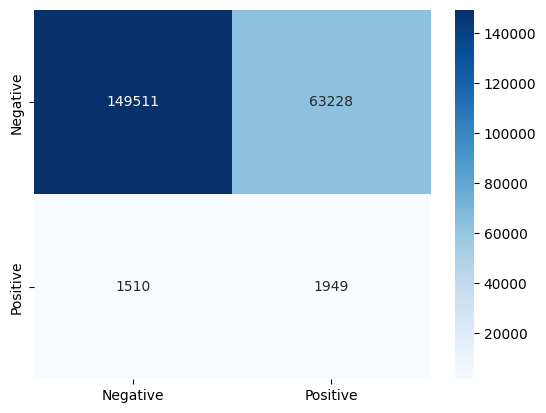

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.701   0.563       0.03  0.037  0.081  0.123  0.202
_____________________________________________________________________________
Under Sampling (1 Minority : 2 Majority)


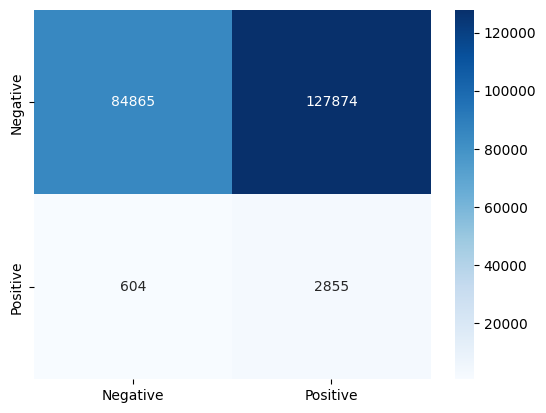

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.406   0.825      0.022  0.027  0.062  0.099  0.176
_____________________________________________________________________________
Under Sampling (1 Minority : 2 Majority)


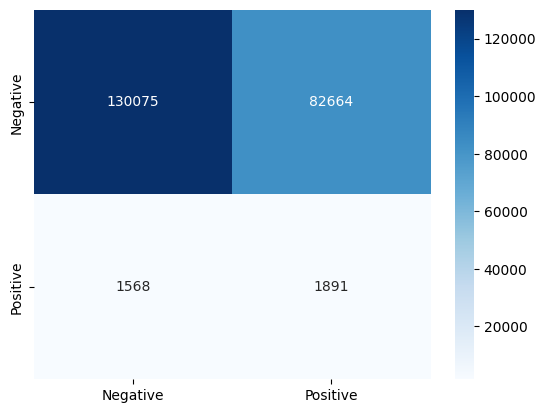

           acc  recall  percision   f0.5     f1     f2     f3
measures  0.61   0.547      0.022  0.028  0.062  0.096  0.163
_____________________________________________________________________________
Over Sampling 


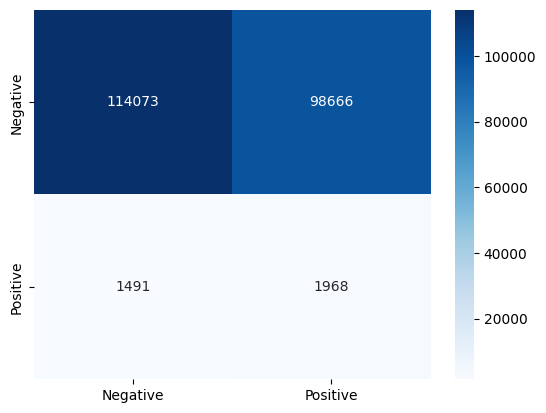

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.537   0.569       0.02  0.024  0.055  0.086  0.149
_____________________________________________________________________________
SMOTE


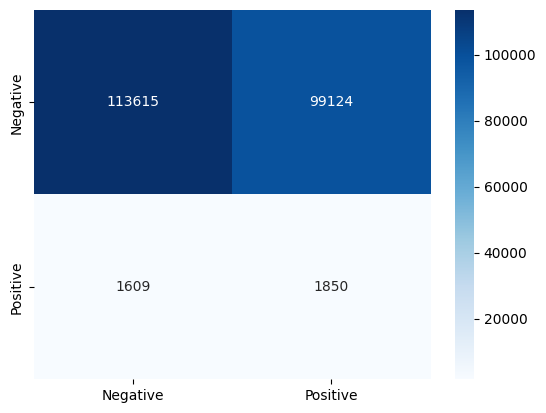

            acc  recall  percision   f0.5     f1     f2    f3
measures  0.534   0.535      0.018  0.023  0.051  0.081  0.14
_____________________________________________________________________________
Imbalanced with class weighing


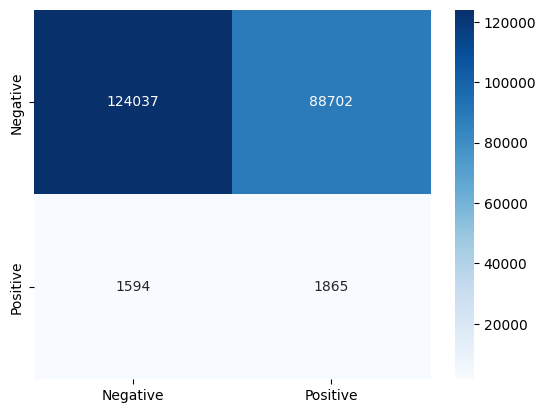

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.582   0.539      0.021  0.025  0.057  0.089  0.153
_____________________________________________________________________________
Imbalanced


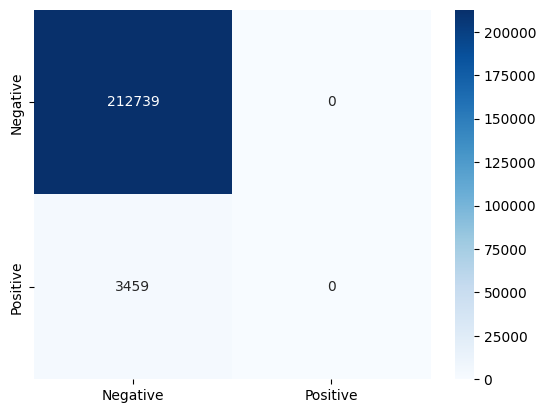

            acc  recall  percision  f0.5  f1  f2  f3
measures  0.984     0.0        NaN   NaN NaN NaN NaN


In [75]:
print("_____________________________________________________________________________")
print("Under Sampling (1 Minority : 1 Majority)")
eval_rus(LogisticRegression(class_weight='balanced'), X_rus, y_rus)

print("_____________________________________________________________________________")
print("Under Sampling (1 Minority : 2 Majority)")
eval_rus(LogisticRegression(class_weight='balanced'), X_rus_50, y_rus_50)

print("_____________________________________________________________________________")
print("Under Sampling (1 Minority : 2 Majority)")
eval_rus(LogisticRegression(class_weight='balanced'), X_rus_25, y_rus_25)

print("_____________________________________________________________________________")
print("Over Sampling ")
eval_ros(LogisticRegression(class_weight='balanced'))

print("_____________________________________________________________________________")
print("SMOTE")
eval_smote(LogisticRegression(class_weight='balanced'))

print("_____________________________________________________________________________")
print("Imbalanced with class weighing")
eval_full(LogisticRegression(class_weight='balanced'))

print("_____________________________________________________________________________")
print("Imbalanced")
eval_full(LogisticRegression())

I investigated one pass random forest to ensure that the random undersample is most appropiate for recall performance. Additionally, the 1:1 undersample was used because the model is computational inexpensive, especially in the hyperparam optimization.

Further it should be noted that we will drop logistic regression infavor of GradientBoostingClassifier and CatBoostClassifier

## Part 5C - Feature Selection Techinques

There are too many columnn, I will employ 2 feature selection techinques to attempt to maintain or improve the performance of the model while reduce dimensionality

### Part 5Ca - PCA

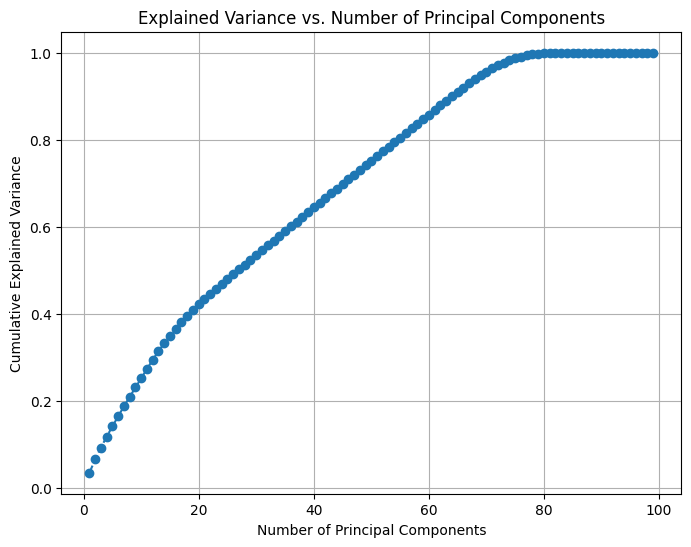

In [76]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_rus)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA()  # Reduce to 2 principal components
X_train_selected = pca.fit_transform(X_train_scaled)
X_test_selected = pca.transform(X_test_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

In [77]:
# Choose the number of components
num_components = 70
pca = PCA(n_components=num_components)
X_train_selected = pca.fit_transform(X_train_scaled)
X_test_selected = pca.transform(X_test_scaled)

print(f'Selected number of components: {num_components}')
print(f'Cumulative explained variance: {cumulative_explained_variance[num_components-1]:.2f}')

Selected number of components: 70
Cumulative explained variance: 0.96


We will try 70 components

In [78]:
def eval_pca(model):
    model.fit(X_train_selected, y_rus)
    pred = model.predict(X_test_selected)
    CM = confusion_matrix(y_test, pred)
    performance_measures = get_performance_measures(CM)

    sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.show()

    print(performance_measures)

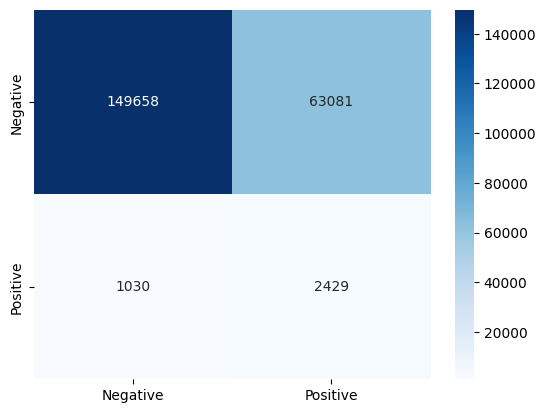

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.703   0.702      0.037  0.046  0.101  0.153  0.251


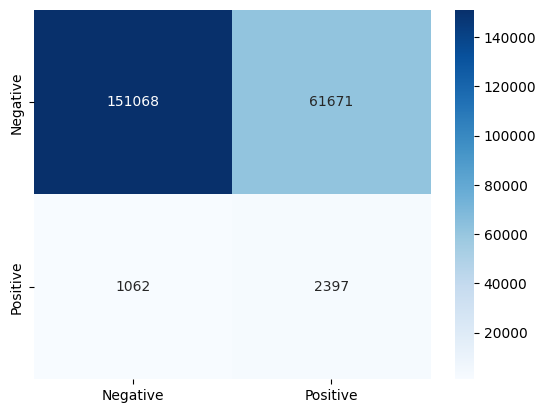

           acc  recall  percision   f0.5     f1     f2     f3
measures  0.71   0.693      0.037  0.046  0.101  0.154  0.252


In [79]:
eval_pca(xgb.XGBClassifier(device="cuda", scale_pos_weight = 1))
eval_pca(RandomForestClassifier(class_weight='balanced'))

We observe slight decrease in recall (73% -> 70%), percision (4.3% -> 3.7%), and F1 score (0.082 -> 0.069) in the XGBClassifier. Although we were able to reduce the dimensionality of the dataset from 99 -> 70, it should be noted that we lose interpretability of the features that impact our model. As a result, we will avoid employing PCA.

Instead we will try SelectKbest

### Part 5Cb - SelectKBest

In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


k_best = SelectKBest(score_func=f_classif, k=50)  # Select top 10 features

k_best.fit(X_rus, y_rus)

selected_indices = k_best.get_support(indices=True)

selected_column_names = [X_rus.columns[i] for i in selected_indices]
print("Selected Columns:", selected_column_names)

X_train_k_selected = X_rus[selected_column_names]
X_test_k_selected = X_test[selected_column_names]

Selected Columns: ['transactionAmount', 'cardPresent', 'transactionToCreditLimitRatio', 'avgTransactionAmountByCustomer', 'transactionCount', 'merchantName_AMC ', 'merchantName_American Airlines', 'merchantName_Apple iTunes', 'merchantName_Blue Mountain Online Services', 'merchantName_Fresh Flowers', 'merchantName_Fresh eCards', 'merchantName_In-N-Out ', 'merchantName_Lyft', 'merchantName_Mobil Gas ', 'merchantName_Play Store', 'merchantName_Shell Gas ', 'merchantName_Spotify', 'merchantName_Sunoco Gas ', 'merchantName_Texas Gas ', 'merchantName_abc.com', 'merchantName_alibaba.com', 'merchantName_amazon.com', 'merchantName_apple.com', 'merchantName_cheapfast.com', 'merchantName_ebay.com', 'merchantName_hulu.com', 'merchantName_netflix.com', 'merchantName_oldnavy.com', 'merchantName_other', 'merchantName_walmart.com', 'posEntryMode_05', 'posEntryMode_09', 'posConditionCode_08', 'posConditionCode_99', 'merchantCategoryCode_airline', 'merchantCategoryCode_cable/phone', 'merchantCategoryCo

In [81]:
def eval_feature(model):
    model.fit(X_train_k_selected, y_rus)
    pred = model.predict(X_test_k_selected)
    CM = confusion_matrix(y_test, pred)
    performance_measures = get_performance_measures(CM)

    sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.show()


    print(performance_measures)

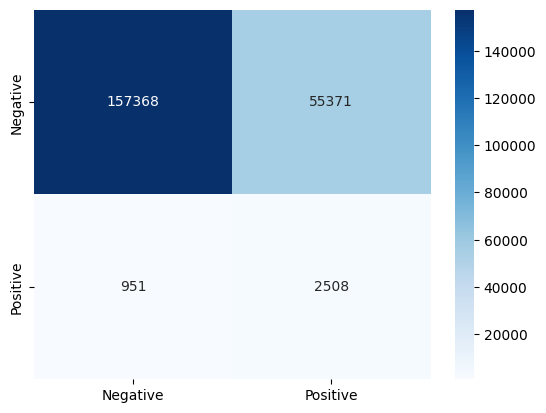

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.739   0.725      0.043  0.053  0.116  0.175  0.282


In [82]:
eval_feature(xgb.XGBClassifier(device="cuda", scale_pos_weight = 1))
# eval_feature(RandomForestClassifier())

We observe slight decrease in recall (73% -> 72.5%), percision (4.3% -> 4.0%), and F1 score (0.082 -> 0.0819) in the XGBClassifier. We were able to reduce the dimensionality of the dataset from 99 -> 50 without losing interpretability of the features that impact our model. As a result, we will use these features for the remainder of the model.

## Part 5D - Hyperparameter Tuning

I will employ hyperparameter tuning in an attempt to increase the performance of the models.

I removed logistic regression due to its poor performance and included CatBoost and GradBoost instead

In [83]:
# Parameters I would like to test
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.03, 0.1],
    'max_depth': [3, 4, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
}

# Creates the random forest classifer and apply gridsearchcv to find the optimal params
xgb_classifier = xgb.XGBClassifier(device="cuda")

# I will comment this out as it takes too long to rerun with the limited time I have. I provided the optimal hyperparams below
# grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=4, scoring='recall')
# grid_search_xgb.fit(X_train_k_selected, y_rus)

# # Best parameters from gridsearch
# best_params_xgb = grid_search_xgb.best_params_

# print("Best parameters found:", best_params_xgb)

In [84]:
#  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.01}
best_params_xgb = {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.01}

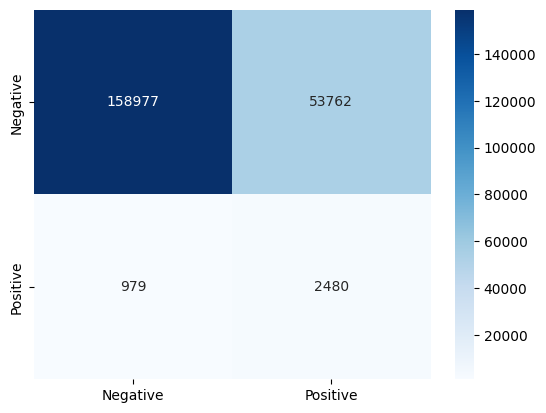

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.747   0.717      0.044  0.054  0.118  0.177  0.284


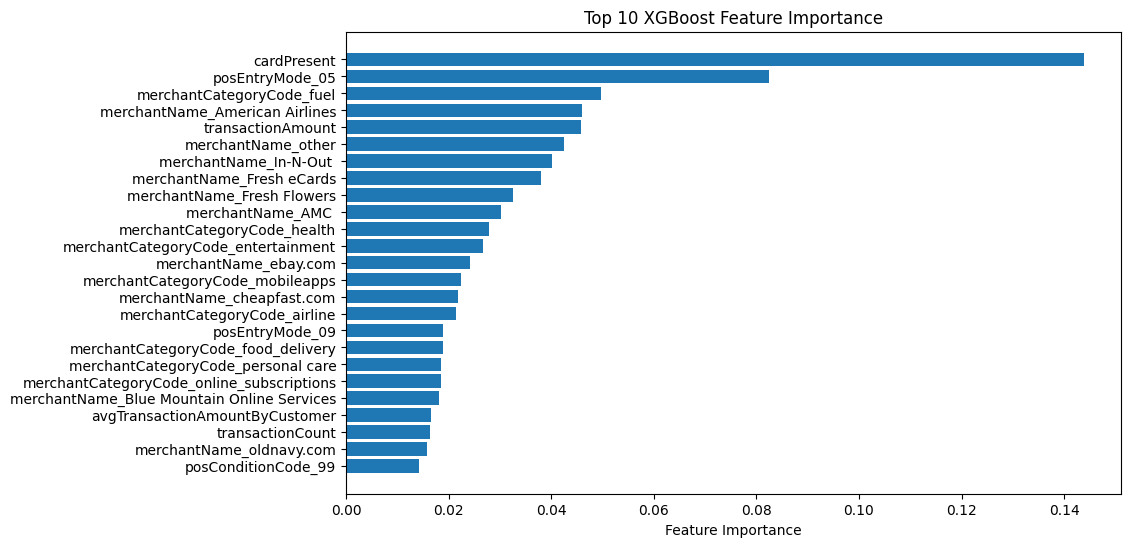

In [85]:
# Create XGBoost classifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_params_xgb, device="cuda")

# Train the model on  training data
best_xgb_classifier.fit(X_train_k_selected, y_rus)
pred = best_xgb_classifier.predict(X_test_k_selected)
CM = confusion_matrix(y_test, pred)
performance_measures = get_performance_measures(CM)

sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.show()

print(performance_measures)

feature_importances = best_xgb_classifier.feature_importances_
feature_names = X_train_k_selected.columns

sorted_idx = feature_importances.argsort()[::-1]


plt.figure(figsize=(10, 6))

N = 25
plt.barh(range(N), feature_importances[sorted_idx][:N], align='center')
plt.yticks(range(N), [feature_names[i] for i in sorted_idx[:N]])
plt.xlabel('Feature Importance')
plt.title('Top 10 XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [86]:
# Parameters I would like to test
params = {'criterion': ['gini', 'entropy'],
     'max_depth': [2*n for n in range(5,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]
     }

# Creates the random forest classifer and apply gridsearchcv to find the optimal params
ranF = RandomForestClassifier()

# I will comment this out as it takes too long to rerun with the limited time I have. I provided the optimal hyperparams below
# grid_search_ranF = GridSearchCV(ranF, params, cv = 4, scoring='recall')
# grid_search_ranF.fit(X_train_k_selected, y_rus)

# # Best parameters from gridsearch
# best_params_RanF = grid_search_ranF.best_params_
# print("Best parameters found:", best_params_RanF)

In [87]:
# {'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
best_params_RanF = {'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

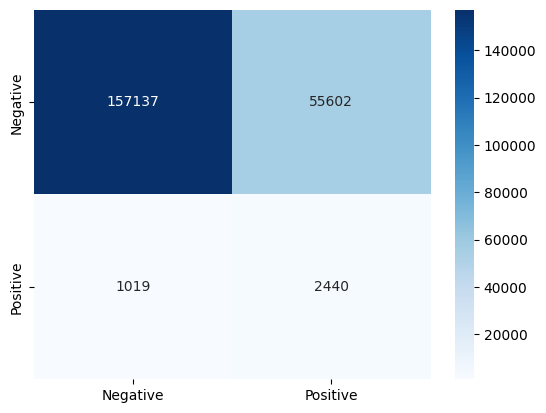

            acc  recall  percision   f0.5     f1    f2     f3
measures  0.738   0.705      0.042  0.052  0.113  0.17  0.274


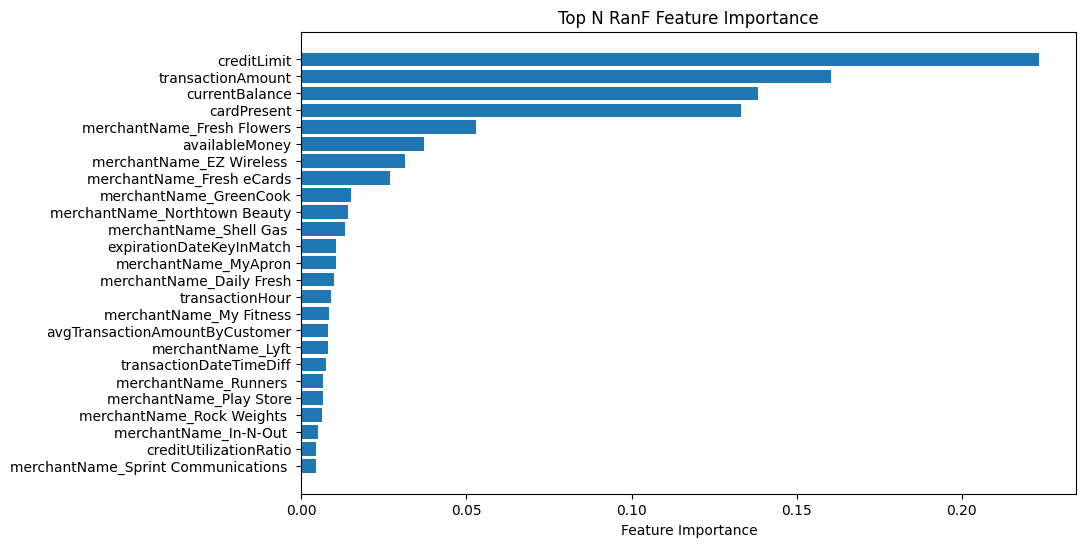

In [88]:
# Create RanF classifier with the best parameters
best_ranF_classifier = RandomForestClassifier(**best_params_RanF)

# Train the model on training data
best_ranF_classifier.fit(X_train_k_selected, y_rus)
pred = best_ranF_classifier.predict(X_test_k_selected)
CM = confusion_matrix(y_test, pred)
performance_measures = get_performance_measures(CM)

sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.show()

print(performance_measures)

feature_importances = best_ranF_classifier.feature_importances_

# Get feature names
feature_names = X_rus.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))

N = 25
plt.barh(range(N), feature_importances[sorted_idx][:N], align='center')
plt.yticks(range(N), [feature_names[i] for i in sorted_idx[:N]])
plt.xlabel('Feature Importance')
plt.title('Top N RanF Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

In [89]:
# Parameters I would like to test
param_grid = {
    'learning_rate': [0.01, 0.03, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

gb = GradientBoostingClassifier()

# Creates the GradientBoostingClassifier and apply gridsearchcv to find the optimal params
grid_search_gb = GridSearchCV(gb, param_grid, scoring='recall', cv=4)

# I will comment this out as it takes too long to rerun with the limited time I have. I provided the optimal hyperparams below
# grid_search_gb.fit(X_train_k_selected, y_rus)

# # Best parameters from gridsearch
# best_params_gb = grid_search_gb.best_params_

# print("Best parameters found:", best_params_gb)

In [90]:
# {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
best_params_gb = {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

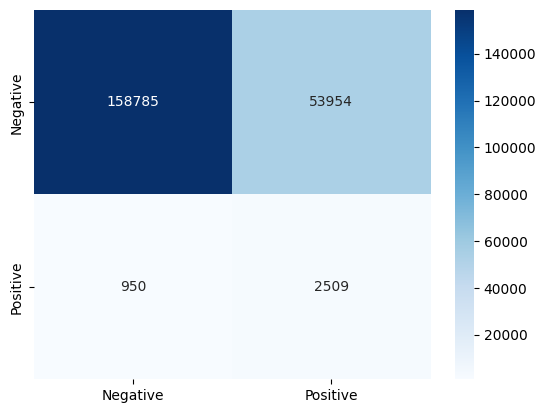

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.746   0.725      0.044  0.055  0.119  0.178  0.286


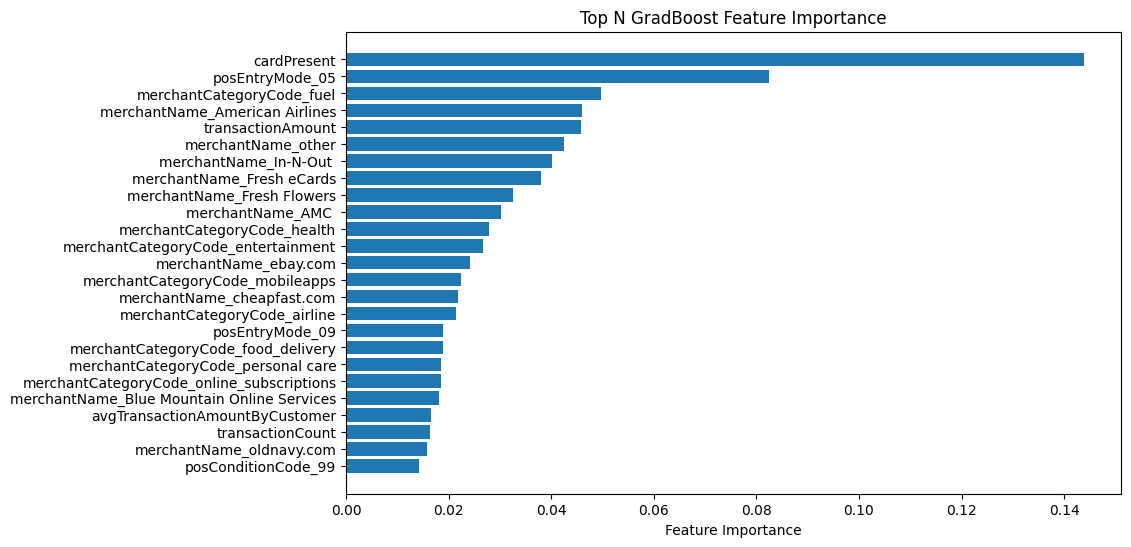

In [91]:
# Create XGBoost classifier with the best parameters
best_gb_classifier = GradientBoostingClassifier(**best_params_gb)

# Train the model on your training data
best_gb_classifier.fit(X_train_k_selected, y_rus)
pred = best_gb_classifier.predict(X_test_k_selected)
CM = confusion_matrix(y_test, pred)
performance_measures = get_performance_measures(CM)

sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.show()

print(performance_measures)

feature_importances = best_xgb_classifier.feature_importances_

# Get feature names
feature_names = X_train_k_selected.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))

N = 25
plt.barh(range(N), feature_importances[sorted_idx][:N], align='center')
plt.yticks(range(N), [feature_names[i] for i in sorted_idx[:N]])
plt.xlabel('Feature Importance')
plt.title('Top N GradBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

In [92]:
# Parameters I would like to test
param_grid = {
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [2, 4, 6],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 200, 300],
    'loss_function': ['Logloss', 'CrossEntropy'],
}

# Creates the CatBoostClassifier and apply gridsearchcv to find the optimal params
cb = CatBoostClassifier(task_type='GPU')

grid_search_cb = GridSearchCV(cb, param_grid, scoring='recall', cv=4)

# I will comment this out as it takes too long to rerun with the limited time I have. I provided the optimal hyperparams below
# grid_search_cb.fit(X_train_k_selected, y_rus)

# Best parameters from gridsearch
# best_params_cb = grid_search_cb.best_params_

# print("Best parameters found:", best_params_cb)


In [93]:
# Best parameters found: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'loss_function': 'Logloss'}
best_params_cb = {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'loss_function': 'Logloss'}

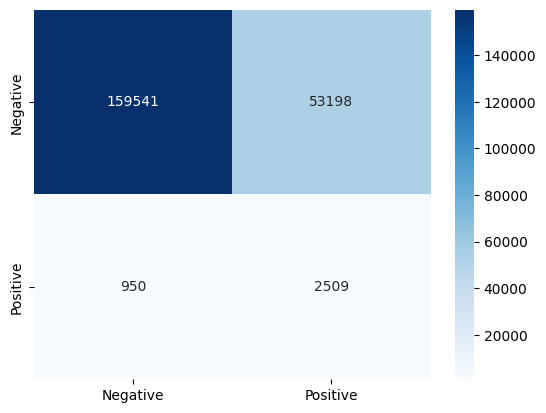

           acc  recall  percision   f0.5    f1    f2     f3
measures  0.75   0.725      0.045  0.055  0.12  0.18  0.289


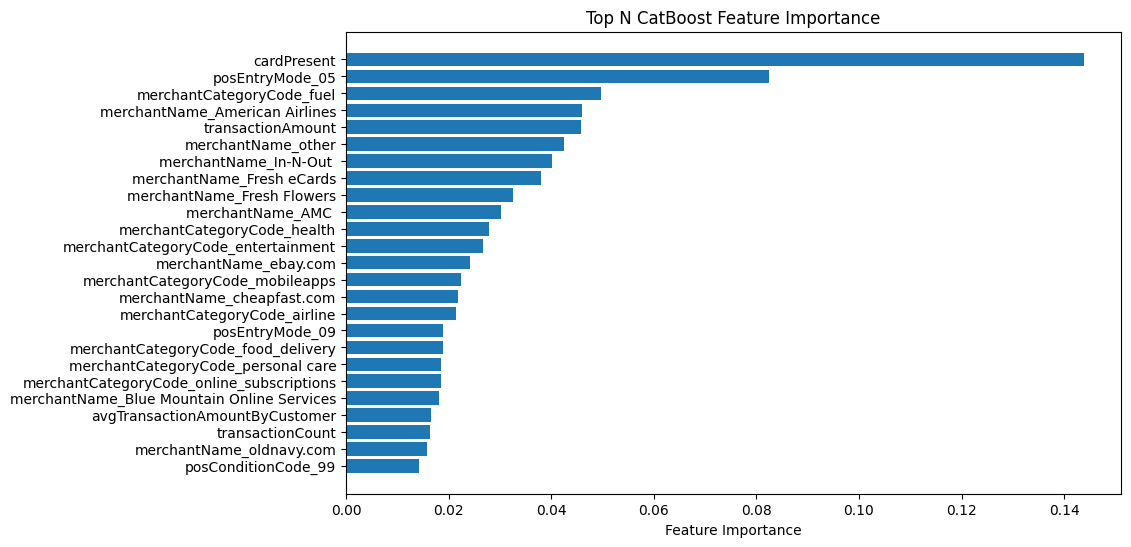

In [94]:
# Create XGBoost classifier with the best parameters
best_cb_classifier = CatBoostClassifier(**best_params_cb, logging_level='Silent')

# Train the model on your training data
best_cb_classifier.fit(X_train_k_selected, y_rus)
pred = best_cb_classifier.predict(X_test_k_selected)
CM = confusion_matrix(y_test, pred)
performance_measures = get_performance_measures(CM)

sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.show()

print(performance_measures)

feature_importances = best_xgb_classifier.feature_importances_

# Get feature names
feature_names = X_train_k_selected.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))

N = 25
plt.barh(range(N), feature_importances[sorted_idx][:N], align='center')
plt.yticks(range(N), [feature_names[i] for i in sorted_idx[:N]])
plt.xlabel('Feature Importance')
plt.title('Top N CatBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

It appear that in every model, the feature that is most:

    cardPresent

    PosEntryMode_05

    transactionAmount

    merchantName_other - this feature made from feature engineering has had more impact than I expected. Perhaps aggregating rare occurence was not the best idea

    merchantName_Fresh Flower - this seems to be due to the one customer that had a high number of fraudulent transaction...

More investigations of these columns should be employed 

## Part 5E - Model Evaluation

Here we will use the hyperparameters from the optimization step to evalaute theperformance of the model against the imbalance test data.

In [95]:
def eval_new_rus(model, X, y):
    model.fit(X, y)
    pred = model.predict(X_test_k_selected)
    CM = confusion_matrix(y_test, pred)
    performance_measures = get_performance_measures(CM)

    sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.show()

    print(performance_measures)

_____________________________________________________________________________


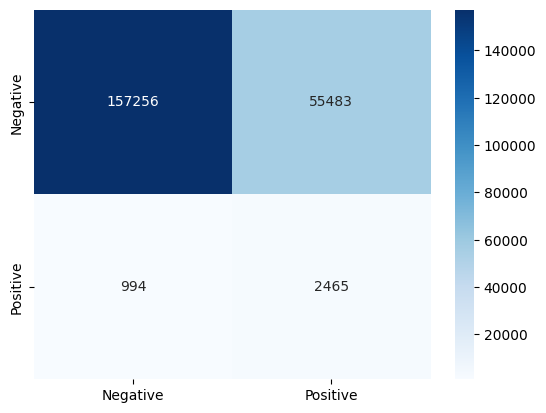

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.739   0.713      0.043  0.052  0.114  0.172  0.277
_____________________________________________________________________________


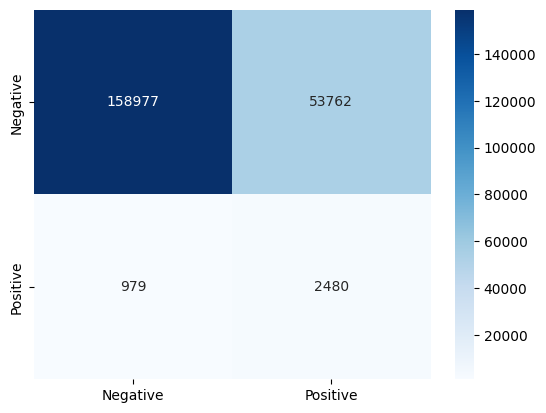

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.747   0.717      0.044  0.054  0.118  0.177  0.284
_____________________________________________________________________________


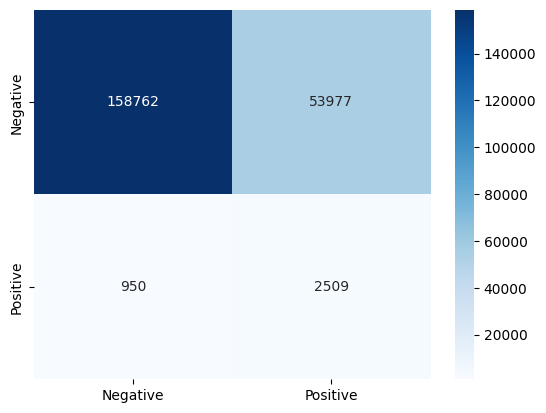

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.746   0.725      0.044  0.055  0.119  0.178  0.286
_____________________________________________________________________________


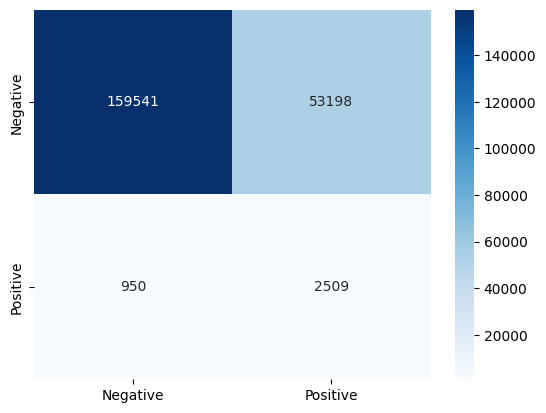

           acc  recall  percision   f0.5    f1    f2     f3
measures  0.75   0.725      0.045  0.055  0.12  0.18  0.289


In [96]:
print("_____________________________________________________________________________")
eval_new_rus(RandomForestClassifier(**best_params_RanF), X_train_k_selected, y_rus)

print("_____________________________________________________________________________")
eval_new_rus(xgb.XGBClassifier(**best_params_xgb, device="cuda"), X_train_k_selected, y_rus)

print("_____________________________________________________________________________")
eval_new_rus(GradientBoostingClassifier(**best_params_gb), X_train_k_selected, y_rus)

print("_____________________________________________________________________________")
eval_new_rus(CatBoostClassifier(**best_params_cb, logging_level='Silent'), X_train_k_selected, y_rus)


I have employed a voting classifer to attempt to boost the predictability performance of the model given the lackluster results

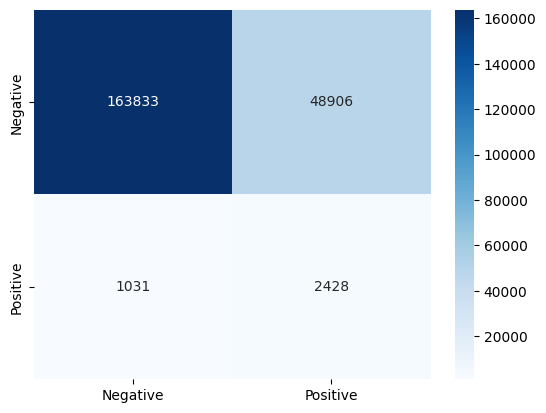

            acc  recall  percision   f0.5     f1     f2     f3
measures  0.769   0.702      0.047  0.058  0.125  0.186  0.294


In [102]:
from sklearn.ensemble import VotingClassifier
ranF_clf = RandomForestClassifier(**best_params_RanF)
xgb_clf = xgb.XGBClassifier(**best_params_xgb, device="cuda")
gb_clf = GradientBoostingClassifier(**best_params_gb)
cb_clf = CatBoostClassifier(**best_params_cb, logging_level='Silent')  


voting_clf = VotingClassifier(estimators=[('RF', ranF_clf), ('XGB', xgb_clf), ('gb', gb_clf), ('cat', cb_clf)], voting='hard')

model = voting_clf
eval_new_rus(model, X_train_k_selected, y_rus)

## Part 5F - Performance Curves

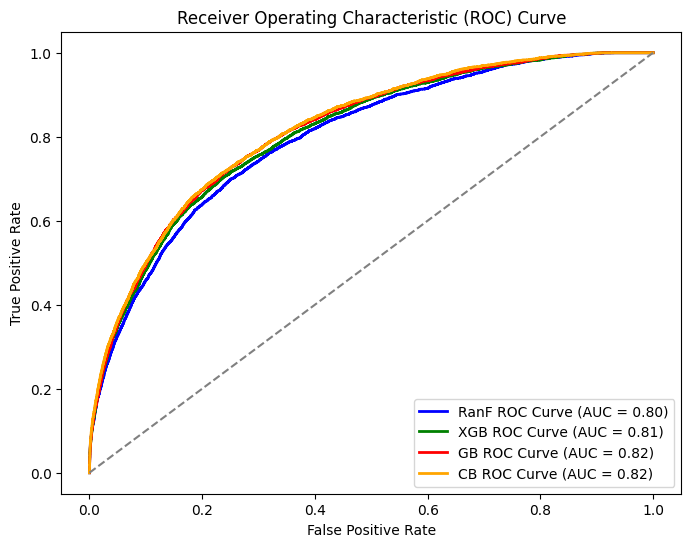

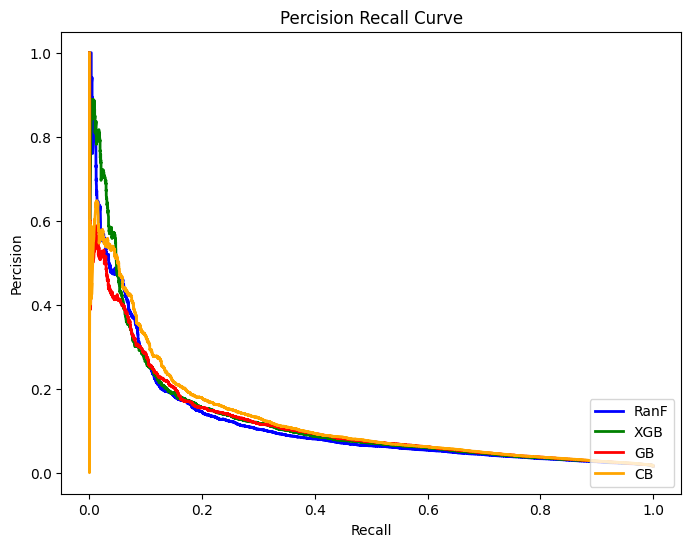

In [104]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

# fit models
ranF_clf.fit(X_train_k_selected, y_rus)
xgb_clf.fit(X_train_k_selected, y_rus)
gb_clf.fit(X_train_k_selected, y_rus)
cb_clf.fit(X_train_k_selected, y_rus)

# Generate predicted prob of the test dataset
y_pred_proba1 = ranF_clf.predict_proba(X_test_k_selected)[:, 1]
y_pred_proba2 = xgb_clf.predict_proba(X_test_k_selected)[:, 1]
y_pred_proba3 = gb_clf.predict_proba(X_test_k_selected)[:, 1]
y_pred_proba4 = cb_clf.predict_proba(X_test_k_selected)[:, 1]

# Compute ROC curve and calculate the AUC
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_proba1)
roc_auc_1 = roc_auc_score(y_test, y_pred_proba1)
p_1 , r_1 ,_1 = precision_recall_curve(y_test, y_pred_proba1)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_proba2)
roc_auc_2 = roc_auc_score(y_test, y_pred_proba2)
p_2 ,r_2 ,_2 = precision_recall_curve(y_test, y_pred_proba2)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, y_pred_proba3)
roc_auc_3 = roc_auc_score(y_test, y_pred_proba3)
p_3, r_3, _3 = precision_recall_curve(y_test, y_pred_proba3)

fpr_4, tpr_4, thresholds_4 = roc_curve(y_test, y_pred_proba4)
roc_auc_4 = roc_auc_score(y_test, y_pred_proba4)
p_4, r_4 ,_4 = precision_recall_curve(y_test, y_pred_proba4)


# Plot the ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, color='blue', lw=2, label=f'RanF ROC Curve (AUC = {roc_auc_1:.2f})')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label=f'XGB ROC Curve (AUC = {roc_auc_2:.2f})')
plt.plot(fpr_3, tpr_3, color='red', lw=2, label=f'GB ROC Curve (AUC = {roc_auc_3:.2f})')
plt.plot(fpr_4, tpr_4, color='orange', lw=2, label=f'CB ROC Curve (AUC = {roc_auc_4:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot the Percision Recall
plt.figure(figsize=(8, 6))
plt.plot(r_1, p_1, color='blue', lw=2, label=f'RanF')
plt.plot(r_2, p_2, color='green', lw=2, label=f'XGB')
plt.plot(r_3, p_3, color='red', lw=2, label=f'GB')
plt.plot(r_4, p_4, color='orange', lw=2, label=f'CB')
plt.xlabel('Recall')
plt.ylabel('Percision')
plt.title('Percision Recall Curve')
plt.legend(loc='lower right')
plt.show()

# Part 6 - Conclusion

Overall, the model were poor predictors of the fraudulent transactions when applied onto the imbalanced test data.

The recall, percision, and f-scores have minimal improvements no matter how much hyperparameter optimiziation, dimensionality reduction, and training data sampling.

Random Forest, Gradient Booster, XGBClassifier, CatBoostClassifier, and Voting Classifier performed roughly the same on the imbalance test data as evident by the similar recall, percision, and f-scores.

I would say the voting classiifer marginially outperformed the other models as it is an emsemble of the other 4 models and has best recall to percision ratio as evident by the higher f-scores

recall      0.704 
percision   0.048
f0.5        0.058
f1          0.126
f2          0.187
f3          0.296

Compared to the XGBClassifier test with purely imbalanced training data (Part 5B), these models have better precision percentages which would be ideal if we cared more about identifying all fraudulent transactions even if we end up with many false positives

Questions that I have?
1. I wonder why these models are poor predictors of fraudulent data. Could the features I selected be poor predictors?
2. Could we collect additioanl data from our user to better understand the data (age, gender, race, income status, & area of residence)?
3. What other feature engineering and transformation could I employ to add value to the model?

# Part 7 - Next Steps

Here are the items that I wish to investigate further with additional time

1. Examine additional feature engineering. Maybe exmaine multicative effects of continuous data, examine temporal variations between transaction, etc.
2. Check the importance of outliers, I kept the entire dataset due to minimal fraud observations. It may impact our model performance due to the model attempting to compensate for those rare observations.
3. Examine additional imbalance methods (combination of under and over sampling & TomekLinks) and examine the results of the other imbalance methods more closee
4. Explore other feature selection methods (Sequential Forward Selection and RFE)
5. Evaluate the other classification models
6. Find the optimal balance between recall and percision
7. Apply stratified k folds onto the training data to generate training and validation to ensure that the onepass  model performance is not due to chance
8. Explore possible impact of deep learning modelss, especially models that account for temporal variation. 
9. Clean up the Modeling process with Pipeline